In [1]:
from llama_cpp import Llama
import torch
import torch
# import torchaudio
import torchgen
# import torchvision
# import bitsandbytes
import accelerate
from torch.nn import functional as F
from torch.nn.functional import softmax
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
import time
import math
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

/opt/anaconda3/envs/llama/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Notebook: Testing Llama Cpp Functionality


In [2]:
# 6,8B
# model_path="/Users/jandh/.cache/huggingface/hub/models--bartowski--Meta-Llama-3.1-8B-Instruct-GGUF/snapshots/bf5b95e96dac0462e2a09145ec66cae9a3f12067/Meta-Llama-3.1-8B-Instruct-Q6_K.gguf"

In [3]:
# 8B perfect
model_path = "/Users/jandh/.cache/huggingface/hub/models--bartowski--Meta-Llama-3.1-8B-Instruct-GGUF/snapshots/bf5b95e96dac0462e2a09145ec66cae9a3f12067/Meta-Llama-3.1-8B-Instruct-Q8_0.gguf"

In [4]:
llm = Llama(
    model_path=model_path,
    n_gpu_layers=-1,   # push every layer to the Apple GPU
    n_ctx=4096,
    logits_all=True,
    verbose=False,
)

llama_init_from_model: n_ctx_per_seq (4096) < n_ctx_train (131072) -- the full capacity of the model will not be utilized
ggml_metal_init: skipping kernel_get_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_1row              (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_l4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_bf16                  (not supported)
ggml_metal_init: skipping kernel_mul_mv_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_mul_mm_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mm_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h64           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h80           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_

In [5]:
start_date = datetime(2021, 1, 1)
end_date = datetime(2023, 12, 1)
current_date = start_date
date_strs = []
while current_date <= end_date:
    date_strs.append(current_date.strftime("%Y-%m-%d"))
    current_date += relativedelta(months=1)



fact_df = pd.DataFrame(columns=['date','question','yes','no','inference_time','event_date'])
fact_df = fact_df.set_index(['question','date'])

In [6]:
questions = ['Is Queen Elizabeth II alive today?','Is Nancy Pelosi the Speaker of the U.S House of Representatives today?','Is Mike Johnson the Speaker of the U.S House of Representatives today?'
             "Is Kevin McCarthy the Speaker of the U.S House of Representatives today?","Did an earthquake occur in Turkey this Month?",
             "Did Argentina win the FIFA World Cup this year?"]
events_dates = ["2022-09-22","2023-01-03","2023-10-25","2023-01-03","2023-02-01","2022-12-18"]

In [7]:
def generate_fact_prompt(question,date):
    message = [
    {
    "role": "system",
    "content": 
        f"Assume today is {date}. Take is as a date cutoff and discard all knowledge after this date strictly"
    
    },
    {"role": "user", "content": f"{question}? Answer in a single Word: Yes or No only."}
    ]
    return message

In [8]:
def parse_yes_no(resp):
    """
    Extracts log-probs and computes probabilities for 'Yes' and 'No'
    from a llama_cpp response structure.
    """
    # Navigate to the top_logprobs list
    top_k = resp["choices"][0]["logprobs"]["content"][0]["top_logprobs"]
    
    # Build a map: token -> logprob
    logp_map = {item["token"].strip(): float(item["logprob"]) for item in top_k}
    # Try both capitalizations
    lp_yes = logp_map.get("Yes", logp_map.get("yes"))
    lp_no  = logp_map.get("No",  logp_map.get("no"))
    if lp_yes is None or lp_no is None:
        raise ValueError("Expected 'Yes' and 'No' tokens in top_logprobs.")
    
    # Convert log-probs to normalised probabilities
    p_yes = math.exp(lp_yes)
    p_no  = math.exp(lp_no)
    # total = p_yes + p_no
    
    return p_yes , p_no


In [9]:

for event_date,question in zip(events_dates,questions):
    # fact_df.loc[question,"event_date"] = event_date
    for date_str in date_strs:
        prompt = generate_fact_prompt(question,date_str)
        st = time.time()
        resp = llm.create_chat_completion(
        messages=prompt,
        max_tokens=1,
        temperature=0.0,
        logprobs=True,
        top_logprobs=2
        )
        

        # response = tokenizer.decode(outputs[:, inputs["input_ids"].shape[1]:][0], skip_special_tokens=True)
        fact_df.loc[(question, date_str),'inference_time'] = time.time() - st

        p_yes,p_no = parse_yes_no(resp)
  

        # print(f"\n\n{prompt[0]['content']}\n{prompt[1]['content']}")
        # print( {w: float(probs[tokenizer.encode(w, add_special_tokens=False)[0]])
        #     for w in ["Yes", "No"]})
        fact_df.loc[(question, date_str),"event_date"] = event_date
        fact_df.loc[(question, date_str),"yes"] = p_yes
        fact_df.loc[(question, date_str),"no"] = p_no

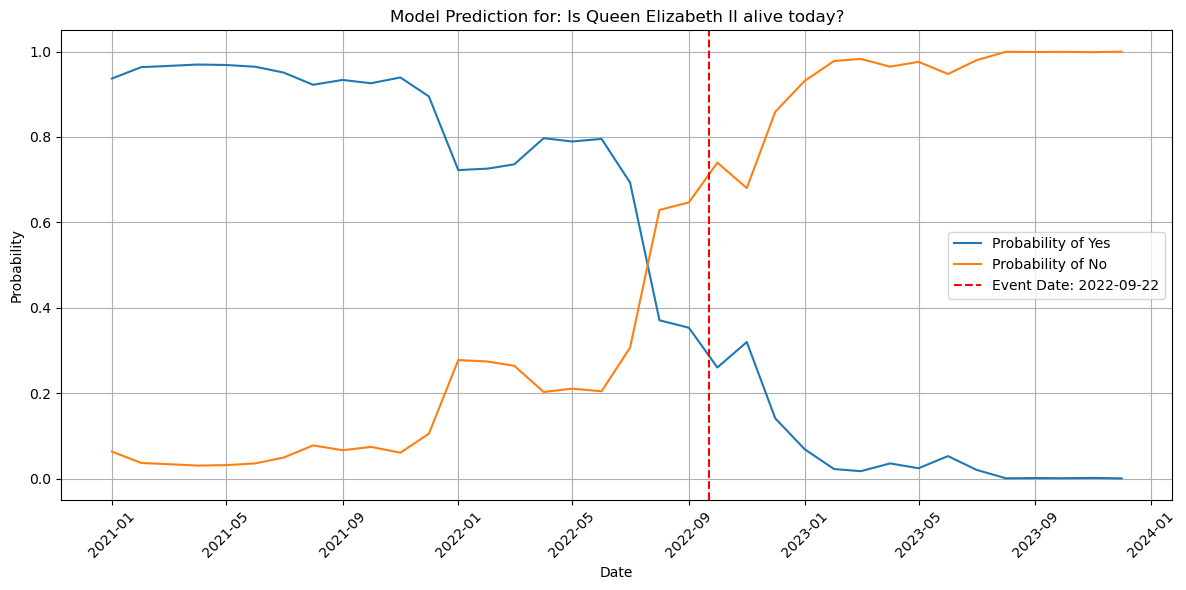

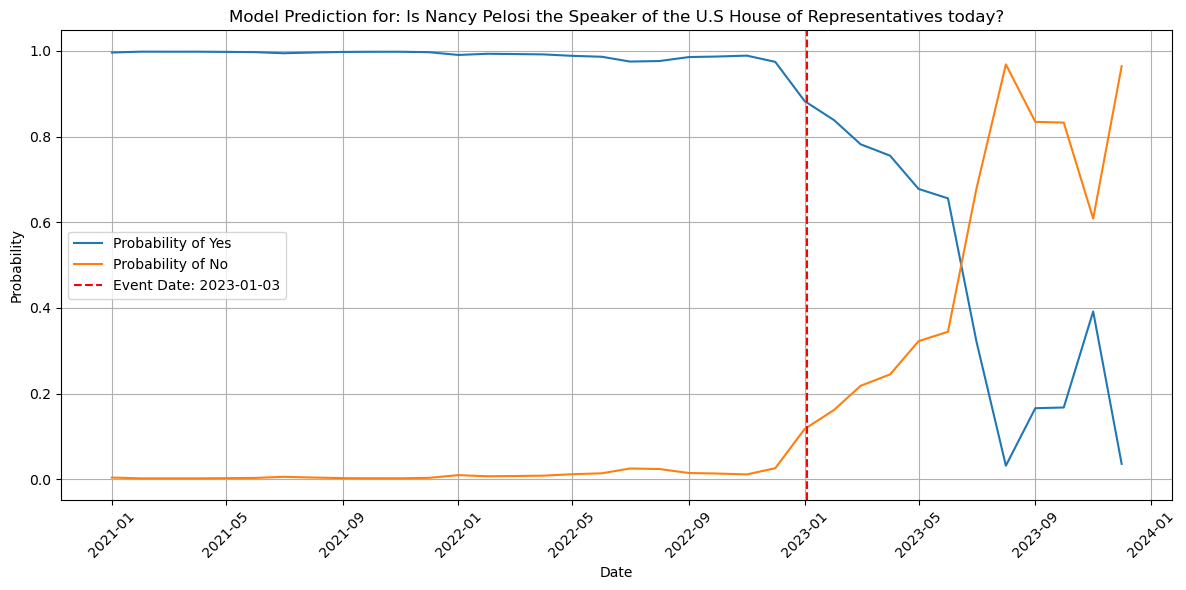

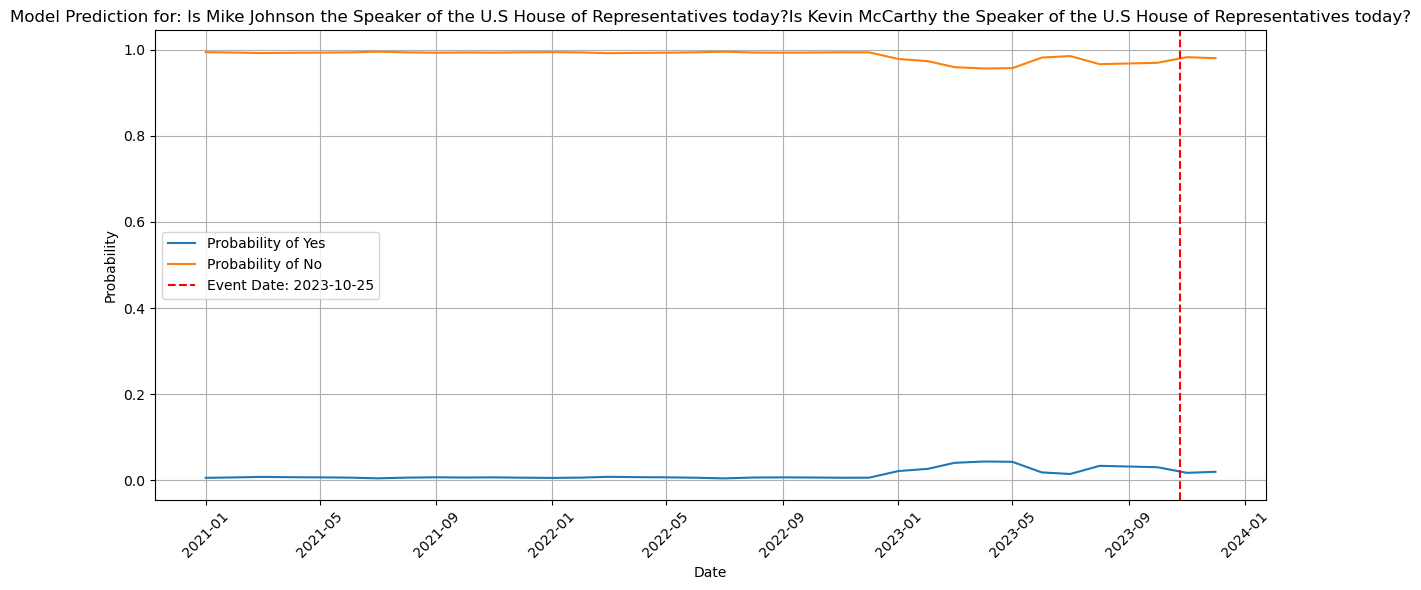

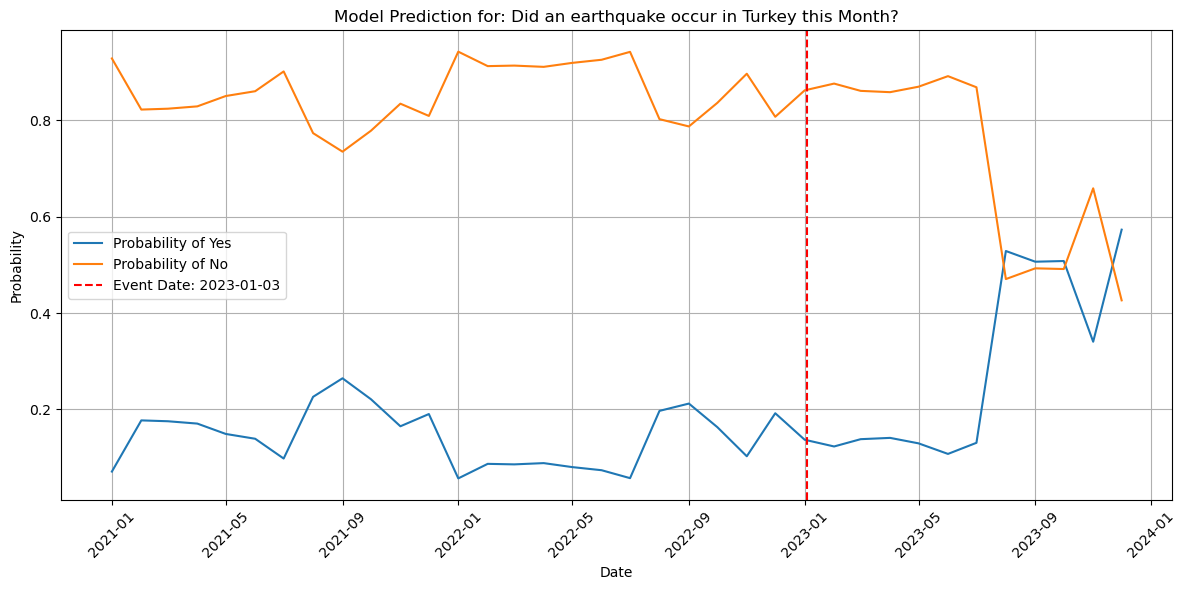

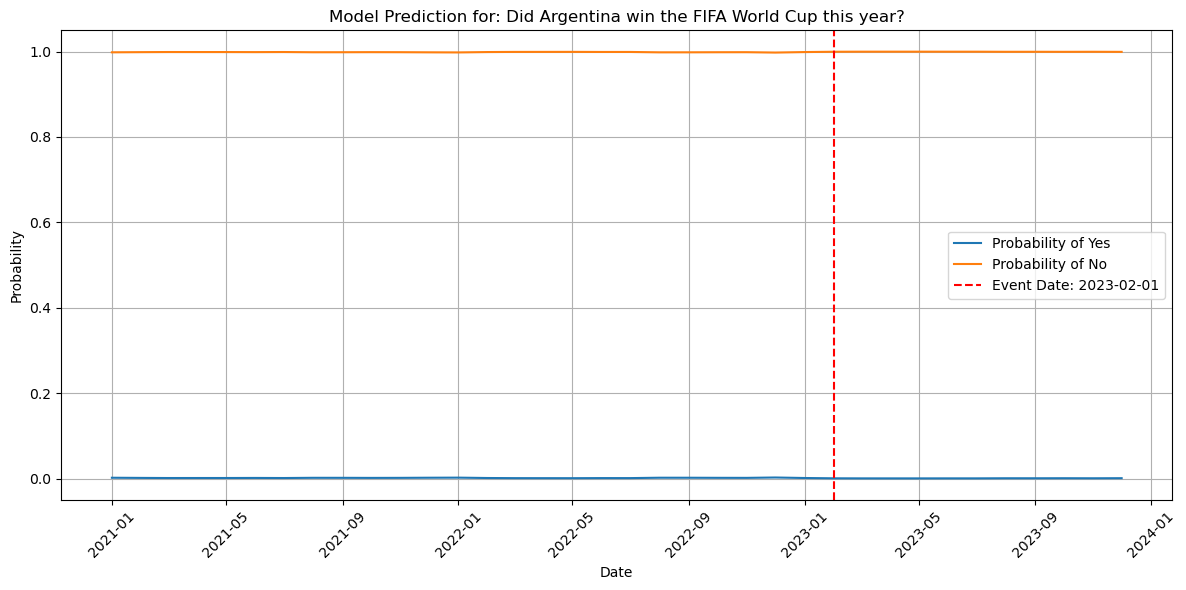

In [10]:
fact_df.index = fact_df.index.set_levels(pd.to_datetime(fact_df.index.levels[1]), level='date')


fact_df['event_date'] = pd.to_datetime(fact_df['event_date'])



unique_questions = fact_df.index.get_level_values('question').unique()
for question in unique_questions:
    question_df = fact_df.loc[question]
    plt.figure(figsize=(12, 6))
    plt.plot(question_df.index, question_df['yes'], label='Probability of Yes')
    plt.plot(question_df.index, question_df['no'], label='Probability of No')

    # Get the event date for the current question
    event_date = question_df['event_date'].iloc[0]
    plt.axvline(x=event_date, color='r', linestyle='--', label=f'Event Date: {event_date.strftime("%Y-%m-%d")}')

    plt.xlabel('Date')
    plt.ylabel('Probability')
    plt.title(f'Model Prediction for: {question}')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [11]:
# def yes_no_probs(resp):

#     top_k = resp["choices"][0]["logprobs"]["content"][0]["top_logprobs"]
    
#     # build {token: logprob}
#     logp = {item["token"].strip(): float(item["logprob"]) 
#             for item in top_k
#             if item["token"].strip().lower() in {"yes", "no"}}
    
#     yes_lp = logp.get("Yes") or logp.get("yes")
#     no_lp  = logp.get("No")  or logp.get("no")
    
#     if yes_lp is None or no_lp is None:
#         raise ValueError("Either 'Yes' or 'No' not found in top_logprobs")

#     # convert to plain probabilities
#     p_yes = math.exp(yes_lp)
#     p_no  = math.exp(no_lp)
#     total = p_yes + p_no

#     return {
#         "logp": {"Yes": yes_lp, "No": no_lp},
#         "prob": {"Yes": p_yes / total, "No": p_no / total}
#     }


In [12]:
def get_yes_no(resp):
    """
    Extracts log-probs and computes probabilities for 'Yes' and 'No'
    from a llama_cpp response structure.
    """
    # Navigate to the top_logprobs list
    top_k = resp["choices"][0]["logprobs"]["content"][0]["top_logprobs"]
    
    # # Build a map: token -> logprob
    # logp_map = {item["token"].strip(): float(item["logprob"]) for item in top_k}
    # # Try both capitalizations
    # lp_yes = logp_map.get("Yes", logp_map.get("yes"))
    # lp_no  = logp_map.get("No",  logp_map.get("no"))
    # if lp_yes is None or lp_no is None:
    #     raise ValueError("Expected 'Yes' and 'No' tokens in top_logprobs.")
    
    # Convert log-probs to normalised probabilities
    # p_yes = math.exp(lp_yes)
    # p_no  = math.exp(lp_no)


    p_yes = 0
    p_no = 0
    for item in top_k:
        if item['token'].strip() in ['No','no']:
            p_no += math.exp(float(item["logprob"]))
        if item['token'].strip() in ['Yes','yes'] :
            p_yes += math.exp(float(item["logprob"]))

    
    # p_yes = math.exp(lp_yes) if lp_yes else 0
    # p_no  = math.exp(lp_no) if lp_no else 0 


    # total = p_yes + p_no
    
    return p_yes , p_no

In [13]:
def generate_fact_prompt_2(date,question):
    message = [
    {
    "role": "system",
    "content": (
        f"You have to give a yes or no answer to each question based on your best knowledge and reasoning including and up to {date}. "
        "Do not provide explanations, details, or any other text. "
    )
    },
    {"role": "user", "content": f"{question}"}
    ]
    return message

def generate_fact_prompt_3(date,question):

    message1 = [
    {
        "role": "system",
        "content": (
            f"You have to give a yes or no answer to each question based on your best knowledge and reasoning including and up to {date}. "
            "Give specific factors you consider and end with yes/no and a period. I want no language of uncertainty."
        )
    },
    {"role": "user", "content": f"{question}"}
    ]
    return message1

In [95]:
df = pd.read_csv("precut_clean_llama.csv")
df.head()

,Unnamed: 0,question,Date
0,0,$ARB above $1.25 on April 7?,"March 31, 2023"
1,1,$ARB above $1.25 on April 7?,"April 30, 2023"
2,2,$ARB above $1.25 on April 7?,"April 30, 2023"
3,3,Another African coup by October 31?,"August 31, 2023"
4,4,Another African coup by October 31?,"September 30, 2023"


In [96]:
df['yes'] = None
df['no'] = None
df['inference_time'] = None
for i in df.index:
    prompt = generate_fact_prompt_2(df.loc[i,"Date"],df.loc[i,'question'])
    st = time.time()
    resp = llm.create_chat_completion(
    messages=prompt,
    max_tokens=1,
    temperature=0.0,
    logprobs=True,
    top_logprobs=5
    )
    

    # response = tokenizer.decode(outputs[:, inputs["input_ids"].shape[1]:][0], skip_special_tokens=True)
    df.loc[i,'inference_time'] = time.time() - st

    p_yes,p_no = get_yes_no(resp)


    # print(f"\n\n{prompt[0]['content']}\n{prompt[1]['content']}")
    # print( {w: float(probs[tokenizer.encode(w, add_special_tokens=False)[0]])
    #     for w in ["Yes", "No"]})
    # df.loc[(question, date_str),"event_date"] = event_date
    df.loc[i,"yes"] = p_yes
    df.loc[i,"no"] = p_no
    time.sleep(1)

    print(f"Question {i} done")

llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =    2544.10 ms /    90 tokens (   28.27 ms per token,    35.38 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =    2563.65 ms /    91 tokens


Question 0 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     539.64 ms /    42 tokens (   12.85 ms per token,    77.83 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     546.62 ms /    43 tokens


Question 1 done


Llama.generate: 89 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =     512.77 ms /     1 runs   (  512.77 ms per token,     1.95 tokens per second)
llama_perf_context_print:       total time =     514.72 ms /     2 tokens


Question 2 done


Llama.generate: 48 prefix-match hit, remaining 38 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     416.36 ms /    38 tokens (   10.96 ms per token,    91.27 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     417.81 ms /    39 tokens


Question 3 done


Llama.generate: 48 prefix-match hit, remaining 38 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     403.89 ms /    38 tokens (   10.63 ms per token,    94.08 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     406.97 ms /    39 tokens


Question 4 done


Llama.generate: 48 prefix-match hit, remaining 38 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     516.79 ms /    38 tokens (   13.60 ms per token,    73.53 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     522.15 ms /    39 tokens
Llama.generate: 85 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =     108.98 ms /     1 runs   (  108.98 ms per token,     9.18 tokens per second)
llama_perf_context_print:       total time =     111.30 ms /     2 tokens


Question 5 done
Question 6 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     657.08 ms /    42 tokens (   15.64 ms per token,    63.92 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     667.81 ms /    43 tokens


Question 7 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     524.25 ms /    42 tokens (   12.48 ms per token,    80.11 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     539.47 ms /    43 tokens
Llama.generate: 89 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =     115.41 ms /     1 runs   (  115.41 ms per token,     8.67 tokens per second)
llama_perf_context_print:       total time =     117.15 ms /     2 tokens


Question 8 done
Question 9 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     419.06 ms /    40 tokens (   10.48 ms per token,    95.45 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     436.06 ms /    41 tokens


Question 10 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     599.88 ms /    40 tokens (   15.00 ms per token,    66.68 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     605.25 ms /    41 tokens


Question 11 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     601.64 ms /    40 tokens (   15.04 ms per token,    66.48 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     604.14 ms /    41 tokens


Question 12 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     514.58 ms /    40 tokens (   12.86 ms per token,    77.73 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     515.90 ms /    41 tokens


Question 13 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     401.44 ms /    40 tokens (   10.04 ms per token,    99.64 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     407.41 ms /    41 tokens


Question 14 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     425.41 ms /    40 tokens (   10.64 ms per token,    94.03 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     426.66 ms /    41 tokens
Llama.generate: 87 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =     124.27 ms /     1 runs   (  124.27 ms per token,     8.05 tokens per second)
llama_perf_context_print:       total time =     126.26 ms /     2 tokens


Question 15 done
Question 16 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     408.40 ms /    40 tokens (   10.21 ms per token,    97.94 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     410.85 ms /    41 tokens


Question 17 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     496.80 ms /    40 tokens (   12.42 ms per token,    80.51 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     498.71 ms /    41 tokens


Question 18 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     400.25 ms /    40 tokens (   10.01 ms per token,    99.94 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     403.29 ms /    41 tokens
Llama.generate: 87 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =     100.87 ms /     1 runs   (  100.87 ms per token,     9.91 tokens per second)
llama_perf_context_print:       total time =     102.01 ms /     2 tokens


Question 19 done
Question 20 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     531.85 ms /    40 tokens (   13.30 ms per token,    75.21 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     533.31 ms /    41 tokens


Question 21 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     491.15 ms /    40 tokens (   12.28 ms per token,    81.44 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     492.55 ms /    41 tokens


Question 22 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     404.24 ms /    40 tokens (   10.11 ms per token,    98.95 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     407.27 ms /    41 tokens
Llama.generate: 87 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =     128.02 ms /     1 runs   (  128.02 ms per token,     7.81 tokens per second)
llama_perf_context_print:       total time =     128.83 ms /     2 tokens


Question 23 done
Question 24 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     424.23 ms /    41 tokens (   10.35 ms per token,    96.65 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     425.55 ms /    42 tokens


Question 25 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     515.24 ms /    41 tokens (   12.57 ms per token,    79.57 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     538.94 ms /    42 tokens
Llama.generate: 88 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =     114.96 ms /     1 runs   (  114.96 ms per token,     8.70 tokens per second)
llama_perf_context_print:       total time =     115.93 ms /     2 tokens


Question 26 done
Question 27 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     453.93 ms /    42 tokens (   10.81 ms per token,    92.52 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     469.10 ms /    43 tokens


Question 28 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     772.62 ms /    42 tokens (   18.40 ms per token,    54.36 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     777.16 ms /    43 tokens
Llama.generate: 89 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =     104.90 ms /     1 runs   (  104.90 ms per token,     9.53 tokens per second)
llama_perf_context_print:       total time =     106.96 ms /     2 tokens


Question 29 done
Question 30 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     413.84 ms /    40 tokens (   10.35 ms per token,    96.66 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     424.05 ms /    41 tokens


Question 31 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     395.37 ms /    40 tokens (    9.88 ms per token,   101.17 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     396.42 ms /    41 tokens
Llama.generate: 87 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =     100.58 ms /     1 runs   (  100.58 ms per token,     9.94 tokens per second)
llama_perf_context_print:       total time =     102.35 ms /     2 tokens


Question 32 done
Question 33 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     405.66 ms /    46 tokens (    8.82 ms per token,   113.40 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     408.52 ms /    47 tokens


Question 34 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     405.53 ms /    46 tokens (    8.82 ms per token,   113.43 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     406.58 ms /    47 tokens
Llama.generate: 93 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =      99.10 ms /     1 runs   (   99.10 ms per token,    10.09 tokens per second)
llama_perf_context_print:       total time =      99.73 ms /     2 tokens


Question 35 done
Question 36 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     401.64 ms /    40 tokens (   10.04 ms per token,    99.59 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     404.64 ms /    41 tokens


Question 37 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.16 ms /    40 tokens (    9.93 ms per token,   100.72 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.48 ms /    41 tokens
Llama.generate: 87 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =     109.50 ms /     1 runs   (  109.50 ms per token,     9.13 tokens per second)
llama_perf_context_print:       total time =     110.09 ms /     2 tokens


Question 38 done
Question 39 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     400.73 ms /    40 tokens (   10.02 ms per token,    99.82 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     402.66 ms /    41 tokens


Question 40 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     402.91 ms /    40 tokens (   10.07 ms per token,    99.28 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     405.01 ms /    41 tokens


Question 41 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.05 ms /    40 tokens (    9.90 ms per token,   101.00 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.69 ms /    41 tokens


Question 42 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     522.85 ms /    40 tokens (   13.07 ms per token,    76.50 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     524.87 ms /    41 tokens


Question 43 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     404.76 ms /    40 tokens (   10.12 ms per token,    98.82 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     407.07 ms /    41 tokens
Llama.generate: 87 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =     102.04 ms /     1 runs   (  102.04 ms per token,     9.80 tokens per second)
llama_perf_context_print:       total time =     102.91 ms /     2 tokens


Question 44 done
Question 45 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     408.45 ms /    40 tokens (   10.21 ms per token,    97.93 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     411.77 ms /    41 tokens


Question 46 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     406.51 ms /    40 tokens (   10.16 ms per token,    98.40 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     407.58 ms /    41 tokens


Question 47 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     404.87 ms /    40 tokens (   10.12 ms per token,    98.80 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     407.17 ms /    41 tokens
Llama.generate: 87 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =     101.37 ms /     1 runs   (  101.37 ms per token,     9.86 tokens per second)
llama_perf_context_print:       total time =     102.34 ms /     2 tokens


Question 48 done
Question 49 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.72 ms /    40 tokens (    9.92 ms per token,   100.83 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.80 ms /    41 tokens


Question 50 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     407.37 ms /    40 tokens (   10.18 ms per token,    98.19 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     410.51 ms /    41 tokens


Question 51 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     519.79 ms /    40 tokens (   12.99 ms per token,    76.95 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     522.57 ms /    41 tokens


Question 52 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     400.64 ms /    39 tokens (   10.27 ms per token,    97.34 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     402.58 ms /    40 tokens


Question 53 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     407.05 ms /    39 tokens (   10.44 ms per token,    95.81 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     409.09 ms /    40 tokens
Llama.generate: 86 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =     107.04 ms /     1 runs   (  107.04 ms per token,     9.34 tokens per second)
llama_perf_context_print:       total time =     109.13 ms /     2 tokens


Question 54 done
Question 55 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     399.79 ms /    43 tokens (    9.30 ms per token,   107.56 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     402.80 ms /    44 tokens


Question 56 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     401.17 ms /    43 tokens (    9.33 ms per token,   107.19 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     402.18 ms /    44 tokens
Llama.generate: 90 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =     101.05 ms /     1 runs   (  101.05 ms per token,     9.90 tokens per second)
llama_perf_context_print:       total time =     102.68 ms /     2 tokens


Question 57 done
Question 58 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     401.29 ms /    43 tokens (    9.33 ms per token,   107.15 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     404.40 ms /    44 tokens


Question 59 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     403.46 ms /    43 tokens (    9.38 ms per token,   106.58 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     406.15 ms /    44 tokens
Llama.generate: 90 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =     100.40 ms /     1 runs   (  100.40 ms per token,     9.96 tokens per second)
llama_perf_context_print:       total time =     100.94 ms /     2 tokens


Question 60 done
Question 61 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     406.98 ms /    46 tokens (    8.85 ms per token,   113.03 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     410.49 ms /    47 tokens


Question 62 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     401.59 ms /    46 tokens (    8.73 ms per token,   114.55 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     402.78 ms /    47 tokens
Llama.generate: 93 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =      99.61 ms /     1 runs   (   99.61 ms per token,    10.04 tokens per second)
llama_perf_context_print:       total time =     101.03 ms /     2 tokens


Question 63 done
Question 64 done


Llama.generate: 48 prefix-match hit, remaining 45 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     400.98 ms /    45 tokens (    8.91 ms per token,   112.22 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     405.13 ms /    46 tokens


Question 65 done


Llama.generate: 48 prefix-match hit, remaining 45 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     408.10 ms /    45 tokens (    9.07 ms per token,   110.27 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     409.75 ms /    46 tokens


Question 66 done


Llama.generate: 48 prefix-match hit, remaining 45 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     407.91 ms /    45 tokens (    9.06 ms per token,   110.32 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     408.91 ms /    46 tokens
Llama.generate: 92 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =      94.08 ms /     1 runs   (   94.08 ms per token,    10.63 tokens per second)
llama_perf_context_print:       total time =      95.12 ms /     2 tokens


Question 67 done
Question 68 done


Llama.generate: 48 prefix-match hit, remaining 45 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     411.76 ms /    45 tokens (    9.15 ms per token,   109.29 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     415.06 ms /    46 tokens


Question 69 done


Llama.generate: 48 prefix-match hit, remaining 45 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     401.31 ms /    45 tokens (    8.92 ms per token,   112.13 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     402.51 ms /    46 tokens
Llama.generate: 92 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =      94.16 ms /     1 runs   (   94.16 ms per token,    10.62 tokens per second)
llama_perf_context_print:       total time =      94.68 ms /     2 tokens


Question 70 done
Question 71 done


Llama.generate: 48 prefix-match hit, remaining 48 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     404.62 ms /    48 tokens (    8.43 ms per token,   118.63 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     408.58 ms /    49 tokens


Question 72 done


Llama.generate: 48 prefix-match hit, remaining 48 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     403.42 ms /    48 tokens (    8.40 ms per token,   118.98 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     404.51 ms /    49 tokens
Llama.generate: 95 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =      93.70 ms /     1 runs   (   93.70 ms per token,    10.67 tokens per second)
llama_perf_context_print:       total time =      94.36 ms /     2 tokens


Question 73 done
Question 74 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     401.41 ms /    43 tokens (    9.34 ms per token,   107.12 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     404.40 ms /    44 tokens


Question 75 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     404.19 ms /    43 tokens (    9.40 ms per token,   106.39 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     405.18 ms /    44 tokens


Question 76 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     444.57 ms /    43 tokens (   10.34 ms per token,    96.72 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     447.15 ms /    44 tokens


Question 77 done


Llama.generate: 90 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =     314.84 ms /     1 runs   (  314.84 ms per token,     3.18 tokens per second)
llama_perf_context_print:       total time =     315.30 ms /     2 tokens


Question 78 done


Llama.generate: 48 prefix-match hit, remaining 45 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     405.95 ms /    45 tokens (    9.02 ms per token,   110.85 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     406.96 ms /    46 tokens


Question 79 done


Llama.generate: 48 prefix-match hit, remaining 45 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     385.22 ms /    45 tokens (    8.56 ms per token,   116.82 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     387.69 ms /    46 tokens


Question 80 done


Llama.generate: 48 prefix-match hit, remaining 45 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     404.97 ms /    45 tokens (    9.00 ms per token,   111.12 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     405.98 ms /    46 tokens
Llama.generate: 92 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =      94.28 ms /     1 runs   (   94.28 ms per token,    10.61 tokens per second)
llama_perf_context_print:       total time =      95.31 ms /     2 tokens


Question 81 done
Question 82 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.42 ms /    42 tokens (    9.46 ms per token,   105.68 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     400.74 ms /    43 tokens


Question 83 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     402.40 ms /    42 tokens (    9.58 ms per token,   104.37 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     404.79 ms /    43 tokens


Question 84 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     406.59 ms /    43 tokens (    9.46 ms per token,   105.76 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     407.86 ms /    44 tokens


Question 85 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     400.78 ms /    43 tokens (    9.32 ms per token,   107.29 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     401.72 ms /    44 tokens
Llama.generate: 90 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =      99.42 ms /     1 runs   (   99.42 ms per token,    10.06 tokens per second)
llama_perf_context_print:       total time =     100.32 ms /     2 tokens


Question 86 done
Question 87 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     394.93 ms /    41 tokens (    9.63 ms per token,   103.82 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     397.94 ms /    42 tokens


Question 88 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     400.28 ms /    41 tokens (    9.76 ms per token,   102.43 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     401.22 ms /    42 tokens


Question 89 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     402.91 ms /    41 tokens (    9.83 ms per token,   101.76 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     403.89 ms /    42 tokens


Question 90 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     383.24 ms /    41 tokens (    9.35 ms per token,   106.98 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     384.18 ms /    42 tokens
Llama.generate: 88 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =      98.07 ms /     1 runs   (   98.07 ms per token,    10.20 tokens per second)
llama_perf_context_print:       total time =      99.12 ms /     2 tokens


Question 91 done
Question 92 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     391.57 ms /    40 tokens (    9.79 ms per token,   102.15 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     394.59 ms /    41 tokens


Question 93 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     399.38 ms /    40 tokens (    9.98 ms per token,   100.16 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     400.35 ms /    41 tokens
Llama.generate: 87 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =      99.38 ms /     1 runs   (   99.38 ms per token,    10.06 tokens per second)
llama_perf_context_print:       total time =     100.48 ms /     2 tokens


Question 94 done
Question 95 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.13 ms /    44 tokens (    9.05 ms per token,   110.52 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.81 ms /    45 tokens


Question 96 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     401.31 ms /    44 tokens (    9.12 ms per token,   109.64 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     402.34 ms /    45 tokens
Llama.generate: 91 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =      98.71 ms /     1 runs   (   98.71 ms per token,    10.13 tokens per second)
llama_perf_context_print:       total time =      99.21 ms /     2 tokens


Question 97 done
Question 98 done


Llama.generate: 48 prefix-match hit, remaining 50 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     546.54 ms /    50 tokens (   10.93 ms per token,    91.48 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     548.20 ms /    51 tokens


Question 99 done


Llama.generate: 48 prefix-match hit, remaining 50 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     676.20 ms /    50 tokens (   13.52 ms per token,    73.94 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     677.46 ms /    51 tokens


Question 100 done


Llama.generate: 48 prefix-match hit, remaining 50 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     520.42 ms /    50 tokens (   10.41 ms per token,    96.08 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     523.48 ms /    51 tokens


Question 101 done


Llama.generate: 48 prefix-match hit, remaining 50 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     408.92 ms /    50 tokens (    8.18 ms per token,   122.27 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     410.26 ms /    51 tokens


Question 102 done


Llama.generate: 48 prefix-match hit, remaining 50 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     403.75 ms /    50 tokens (    8.07 ms per token,   123.84 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     406.72 ms /    51 tokens
Llama.generate: 97 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =      97.13 ms /     1 runs   (   97.13 ms per token,    10.30 tokens per second)
llama_perf_context_print:       total time =      98.07 ms /     2 tokens


Question 103 done
Question 104 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     399.07 ms /    40 tokens (    9.98 ms per token,   100.23 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     401.88 ms /    41 tokens


Question 105 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     406.36 ms /    40 tokens (   10.16 ms per token,    98.44 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     408.99 ms /    41 tokens


Question 106 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     395.03 ms /    40 tokens (    9.88 ms per token,   101.26 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     397.28 ms /    41 tokens


Question 107 done


Llama.generate: 87 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =     375.38 ms /     1 runs   (  375.38 ms per token,     2.66 tokens per second)
llama_perf_context_print:       total time =     375.83 ms /     2 tokens


Question 108 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     390.39 ms /    43 tokens (    9.08 ms per token,   110.15 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     393.00 ms /    44 tokens


Question 109 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     422.12 ms /    43 tokens (    9.82 ms per token,   101.87 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     423.07 ms /    44 tokens


Question 110 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.97 ms /    43 tokens (    9.23 ms per token,   108.32 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     401.00 ms /    44 tokens


Question 111 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     503.32 ms /    43 tokens (   11.71 ms per token,    85.43 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     505.77 ms /    44 tokens


Question 112 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     401.38 ms /    44 tokens (    9.12 ms per token,   109.62 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     402.37 ms /    45 tokens


Question 113 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     403.03 ms /    44 tokens (    9.16 ms per token,   109.17 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     405.72 ms /    45 tokens


Question 114 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     387.18 ms /    44 tokens (    8.80 ms per token,   113.64 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     388.23 ms /    45 tokens


Question 115 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     403.88 ms /    44 tokens (    9.18 ms per token,   108.94 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     406.37 ms /    45 tokens


Question 116 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     394.49 ms /    44 tokens (    8.97 ms per token,   111.54 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     397.24 ms /    45 tokens


Question 117 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     401.05 ms /    44 tokens (    9.11 ms per token,   109.71 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     403.47 ms /    45 tokens


Question 118 done


Llama.generate: 48 prefix-match hit, remaining 52 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     407.84 ms /    52 tokens (    7.84 ms per token,   127.50 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     409.30 ms /    53 tokens


Question 119 done


Llama.generate: 48 prefix-match hit, remaining 52 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     426.13 ms /    52 tokens (    8.19 ms per token,   122.03 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     427.42 ms /    53 tokens
Llama.generate: 99 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =      99.97 ms /     1 runs   (   99.97 ms per token,    10.00 tokens per second)
llama_perf_context_print:       total time =     101.02 ms /     2 tokens


Question 120 done
Question 121 done


Llama.generate: 74 prefix-match hit, remaining 18 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     254.17 ms /    18 tokens (   14.12 ms per token,    70.82 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     260.47 ms /    19 tokens


Question 122 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     537.66 ms /    44 tokens (   12.22 ms per token,    81.84 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     538.69 ms /    45 tokens
Llama.generate: 91 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =      99.08 ms /     1 runs   (   99.08 ms per token,    10.09 tokens per second)
llama_perf_context_print:       total time =     100.12 ms /     2 tokens


Question 123 done
Question 124 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     407.38 ms /    44 tokens (    9.26 ms per token,   108.01 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     410.54 ms /    45 tokens


Question 125 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     390.24 ms /    44 tokens (    8.87 ms per token,   112.75 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     391.37 ms /    45 tokens


Question 126 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     402.78 ms /    44 tokens (    9.15 ms per token,   109.24 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     403.89 ms /    45 tokens


Question 127 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.57 ms /    44 tokens (    9.06 ms per token,   110.39 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.56 ms /    45 tokens


Question 128 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     403.50 ms /    44 tokens (    9.17 ms per token,   109.05 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     405.98 ms /    45 tokens


Question 129 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     405.44 ms /    44 tokens (    9.21 ms per token,   108.52 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     407.84 ms /    45 tokens
Llama.generate: 91 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =      94.25 ms /     1 runs   (   94.25 ms per token,    10.61 tokens per second)
llama_perf_context_print:       total time =      95.28 ms /     2 tokens


Question 130 done
Question 131 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     407.97 ms /    44 tokens (    9.27 ms per token,   107.85 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     410.85 ms /    45 tokens


Question 132 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     644.21 ms /    44 tokens (   14.64 ms per token,    68.30 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     645.35 ms /    45 tokens


Question 133 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     405.06 ms /    44 tokens (    9.21 ms per token,   108.63 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     407.71 ms /    45 tokens


Question 134 done


Llama.generate: 91 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =     363.64 ms /     1 runs   (  363.64 ms per token,     2.75 tokens per second)
llama_perf_context_print:       total time =     364.06 ms /     2 tokens


Question 135 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     400.22 ms /    39 tokens (   10.26 ms per token,    97.45 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     402.89 ms /    40 tokens


Question 136 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     507.18 ms /    39 tokens (   13.00 ms per token,    76.90 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     509.66 ms /    40 tokens
Llama.generate: 86 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =     100.18 ms /     1 runs   (  100.18 ms per token,     9.98 tokens per second)
llama_perf_context_print:       total time =     101.60 ms /     2 tokens


Question 137 done
Question 138 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     388.92 ms /    41 tokens (    9.49 ms per token,   105.42 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     392.40 ms /    42 tokens


Question 139 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     405.20 ms /    41 tokens (    9.88 ms per token,   101.19 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     407.39 ms /    42 tokens
Llama.generate: 88 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =     100.99 ms /     1 runs   (  100.99 ms per token,     9.90 tokens per second)
llama_perf_context_print:       total time =     102.06 ms /     2 tokens


Question 140 done
Question 141 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     431.56 ms /    46 tokens (    9.38 ms per token,   106.59 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     435.07 ms /    47 tokens


Question 142 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     402.94 ms /    46 tokens (    8.76 ms per token,   114.16 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     404.32 ms /    47 tokens
Llama.generate: 93 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =      92.80 ms /     1 runs   (   92.80 ms per token,    10.78 tokens per second)
llama_perf_context_print:       total time =      93.32 ms /     2 tokens


Question 143 done
Question 144 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     404.12 ms /    46 tokens (    8.79 ms per token,   113.83 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     407.37 ms /    47 tokens


Question 145 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     404.61 ms /    46 tokens (    8.80 ms per token,   113.69 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     407.22 ms /    47 tokens
Llama.generate: 93 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =      98.24 ms /     1 runs   (   98.24 ms per token,    10.18 tokens per second)
llama_perf_context_print:       total time =      98.64 ms /     2 tokens


Question 146 done
Question 147 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     406.13 ms /    41 tokens (    9.91 ms per token,   100.95 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     409.15 ms /    42 tokens


Question 148 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     407.85 ms /    41 tokens (    9.95 ms per token,   100.53 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     410.27 ms /    42 tokens


Question 149 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     522.68 ms /    41 tokens (   12.75 ms per token,    78.44 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     523.63 ms /    42 tokens
Llama.generate: 88 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =      99.42 ms /     1 runs   (   99.42 ms per token,    10.06 tokens per second)
llama_perf_context_print:       total time =     100.00 ms /     2 tokens


Question 150 done
Question 151 done


Llama.generate: 48 prefix-match hit, remaining 50 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     579.26 ms /    50 tokens (   11.59 ms per token,    86.32 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     582.42 ms /    51 tokens


Question 152 done


Llama.generate: 48 prefix-match hit, remaining 50 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     492.91 ms /    50 tokens (    9.86 ms per token,   101.44 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     494.07 ms /    51 tokens
Llama.generate: 97 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =     100.77 ms /     1 runs   (  100.77 ms per token,     9.92 tokens per second)
llama_perf_context_print:       total time =     101.19 ms /     2 tokens


Question 153 done
Question 154 done


Llama.generate: 74 prefix-match hit, remaining 17 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     374.98 ms /    17 tokens (   22.06 ms per token,    45.34 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     376.32 ms /    18 tokens


Question 155 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     593.42 ms /    43 tokens (   13.80 ms per token,    72.46 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     594.50 ms /    44 tokens
Llama.generate: 90 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =      99.64 ms /     1 runs   (   99.64 ms per token,    10.04 tokens per second)
llama_perf_context_print:       total time =     100.62 ms /     2 tokens


Question 156 done
Question 157 done


Llama.generate: 48 prefix-match hit, remaining 45 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     393.89 ms /    45 tokens (    8.75 ms per token,   114.24 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     396.67 ms /    46 tokens


Question 158 done


Llama.generate: 48 prefix-match hit, remaining 45 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     406.24 ms /    45 tokens (    9.03 ms per token,   110.77 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     408.82 ms /    46 tokens


Question 159 done


Llama.generate: 48 prefix-match hit, remaining 45 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     405.59 ms /    45 tokens (    9.01 ms per token,   110.95 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     408.06 ms /    46 tokens


Question 160 done


Llama.generate: 92 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =     291.58 ms /     1 runs   (  291.58 ms per token,     3.43 tokens per second)
llama_perf_context_print:       total time =     291.90 ms /     2 tokens


Question 161 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     399.00 ms /    39 tokens (   10.23 ms per token,    97.74 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     401.53 ms /    40 tokens


Question 162 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     394.14 ms /    39 tokens (   10.11 ms per token,    98.95 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     395.09 ms /    40 tokens
Llama.generate: 86 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =      98.66 ms /     1 runs   (   98.66 ms per token,    10.14 tokens per second)
llama_perf_context_print:       total time =      99.51 ms /     2 tokens


Question 163 done
Question 164 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     400.22 ms /    39 tokens (   10.26 ms per token,    97.45 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     403.29 ms /    40 tokens


Question 165 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     391.38 ms /    39 tokens (   10.04 ms per token,    99.65 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     392.34 ms /    40 tokens
Llama.generate: 86 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =      99.95 ms /     1 runs   (   99.95 ms per token,    10.01 tokens per second)
llama_perf_context_print:       total time =     101.00 ms /     2 tokens


Question 166 done
Question 167 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     405.96 ms /    41 tokens (    9.90 ms per token,   101.00 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     407.60 ms /    42 tokens


Question 168 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     401.31 ms /    41 tokens (    9.79 ms per token,   102.17 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     403.77 ms /    42 tokens
Llama.generate: 88 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =      98.41 ms /     1 runs   (   98.41 ms per token,    10.16 tokens per second)
llama_perf_context_print:       total time =      99.48 ms /     2 tokens


Question 169 done
Question 170 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     400.59 ms /    46 tokens (    8.71 ms per token,   114.83 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     403.91 ms /    47 tokens


Question 171 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     403.49 ms /    46 tokens (    8.77 ms per token,   114.00 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     404.54 ms /    47 tokens
Llama.generate: 93 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =      98.88 ms /     1 runs   (   98.88 ms per token,    10.11 tokens per second)
llama_perf_context_print:       total time =      99.31 ms /     2 tokens


Question 172 done
Question 173 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     408.36 ms /    41 tokens (    9.96 ms per token,   100.40 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     411.05 ms /    42 tokens


Question 174 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     386.40 ms /    41 tokens (    9.42 ms per token,   106.11 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     387.31 ms /    42 tokens


Question 175 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     401.54 ms /    41 tokens (    9.79 ms per token,   102.11 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     404.08 ms /    42 tokens
Llama.generate: 88 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =     100.01 ms /     1 runs   (  100.01 ms per token,    10.00 tokens per second)
llama_perf_context_print:       total time =     101.03 ms /     2 tokens


Question 176 done
Question 177 done


Llama.generate: 74 prefix-match hit, remaining 16 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     234.61 ms /    16 tokens (   14.66 ms per token,    68.20 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     236.35 ms /    17 tokens


Question 178 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     395.36 ms /    42 tokens (    9.41 ms per token,   106.23 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     396.38 ms /    43 tokens


Question 179 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     387.81 ms /    42 tokens (    9.23 ms per token,   108.30 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     388.70 ms /    43 tokens


Question 180 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     401.27 ms /    42 tokens (    9.55 ms per token,   104.67 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     403.83 ms /    43 tokens


Question 181 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     406.19 ms /    42 tokens (    9.67 ms per token,   103.40 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     408.54 ms /    43 tokens


Question 182 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     525.61 ms /    42 tokens (   12.51 ms per token,    79.91 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     528.16 ms /    43 tokens


Question 183 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     399.84 ms /    42 tokens (    9.52 ms per token,   105.04 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     400.88 ms /    43 tokens


Question 184 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     401.97 ms /    42 tokens (    9.57 ms per token,   104.49 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     404.31 ms /    43 tokens


Question 185 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     435.63 ms /    40 tokens (   10.89 ms per token,    91.82 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     436.67 ms /    41 tokens


Question 186 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     400.47 ms /    40 tokens (   10.01 ms per token,    99.88 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     401.38 ms /    41 tokens


Question 187 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     388.87 ms /    40 tokens (    9.72 ms per token,   102.86 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     389.82 ms /    41 tokens


Question 188 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     400.36 ms /    40 tokens (   10.01 ms per token,    99.91 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     401.33 ms /    41 tokens


Question 189 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     402.60 ms /    40 tokens (   10.07 ms per token,    99.35 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     404.88 ms /    41 tokens


Question 190 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     390.71 ms /    40 tokens (    9.77 ms per token,   102.38 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     391.67 ms /    41 tokens


Question 191 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     403.18 ms /    40 tokens (   10.08 ms per token,    99.21 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     405.57 ms /    41 tokens


Question 192 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     406.92 ms /    41 tokens (    9.92 ms per token,   100.76 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     407.95 ms /    42 tokens


Question 193 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     405.72 ms /    41 tokens (    9.90 ms per token,   101.06 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     406.69 ms /    42 tokens


Question 194 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     404.34 ms /    41 tokens (    9.86 ms per token,   101.40 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     406.52 ms /    42 tokens


Question 195 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     394.82 ms /    42 tokens (    9.40 ms per token,   106.38 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     397.36 ms /    43 tokens


Question 196 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     402.44 ms /    42 tokens (    9.58 ms per token,   104.36 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     404.92 ms /    43 tokens


Question 197 done


Llama.generate: 89 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =     327.00 ms /     1 runs   (  327.00 ms per token,     3.06 tokens per second)
llama_perf_context_print:       total time =     327.49 ms /     2 tokens


Question 198 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     416.54 ms /    46 tokens (    9.06 ms per token,   110.43 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     419.07 ms /    47 tokens


Question 199 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     400.65 ms /    46 tokens (    8.71 ms per token,   114.81 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     401.86 ms /    47 tokens


Question 200 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     403.06 ms /    46 tokens (    8.76 ms per token,   114.13 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     405.63 ms /    47 tokens


Question 201 done


Llama.generate: 93 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =     318.71 ms /     1 runs   (  318.71 ms per token,     3.14 tokens per second)
llama_perf_context_print:       total time =     319.14 ms /     2 tokens


Question 202 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.79 ms /    42 tokens (    9.49 ms per token,   105.32 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     401.91 ms /    43 tokens


Question 203 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     400.40 ms /    42 tokens (    9.53 ms per token,   104.90 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     401.53 ms /    43 tokens


Question 204 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     400.82 ms /    42 tokens (    9.54 ms per token,   104.78 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     401.80 ms /    43 tokens


Question 205 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     402.55 ms /    42 tokens (    9.58 ms per token,   104.34 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     405.05 ms /    43 tokens


Question 206 done


Llama.generate: 75 prefix-match hit, remaining 20 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     218.06 ms /    20 tokens (   10.90 ms per token,    91.72 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     219.73 ms /    21 tokens


Question 207 done


Llama.generate: 48 prefix-match hit, remaining 47 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     552.98 ms /    47 tokens (   11.77 ms per token,    84.99 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     554.06 ms /    48 tokens


Question 208 done


Llama.generate: 48 prefix-match hit, remaining 47 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     403.15 ms /    47 tokens (    8.58 ms per token,   116.58 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     405.72 ms /    48 tokens
Llama.generate: 94 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =      98.68 ms /     1 runs   (   98.68 ms per token,    10.13 tokens per second)
llama_perf_context_print:       total time =      99.19 ms /     2 tokens


Question 209 done
Question 210 done


Llama.generate: 48 prefix-match hit, remaining 47 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     405.71 ms /    47 tokens (    8.63 ms per token,   115.85 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     409.23 ms /    48 tokens


Question 211 done


Llama.generate: 48 prefix-match hit, remaining 47 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     434.33 ms /    47 tokens (    9.24 ms per token,   108.21 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     436.99 ms /    48 tokens


Question 212 done


Llama.generate: 48 prefix-match hit, remaining 47 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     587.68 ms /    47 tokens (   12.50 ms per token,    79.98 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     588.80 ms /    48 tokens


Question 213 done


Llama.generate: 48 prefix-match hit, remaining 47 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     402.84 ms /    47 tokens (    8.57 ms per token,   116.67 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     403.85 ms /    48 tokens


Question 214 done


Llama.generate: 48 prefix-match hit, remaining 47 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     386.85 ms /    47 tokens (    8.23 ms per token,   121.49 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     389.25 ms /    48 tokens
Llama.generate: 94 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =     100.96 ms /     1 runs   (  100.96 ms per token,     9.90 tokens per second)
llama_perf_context_print:       total time =     101.93 ms /     2 tokens


Question 215 done
Question 216 done


Llama.generate: 48 prefix-match hit, remaining 47 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     395.57 ms /    47 tokens (    8.42 ms per token,   118.81 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.39 ms /    48 tokens


Question 217 done


Llama.generate: 48 prefix-match hit, remaining 47 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     443.83 ms /    47 tokens (    9.44 ms per token,   105.90 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     444.90 ms /    48 tokens


Question 218 done


Llama.generate: 48 prefix-match hit, remaining 47 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.63 ms /    47 tokens (    8.46 ms per token,   118.20 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     400.38 ms /    48 tokens


Question 219 done


Llama.generate: 48 prefix-match hit, remaining 47 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     504.21 ms /    47 tokens (   10.73 ms per token,    93.22 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     505.37 ms /    48 tokens


Question 220 done


Llama.generate: 48 prefix-match hit, remaining 47 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     404.00 ms /    47 tokens (    8.60 ms per token,   116.34 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     406.83 ms /    48 tokens


Question 221 done


Llama.generate: 48 prefix-match hit, remaining 47 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     548.82 ms /    47 tokens (   11.68 ms per token,    85.64 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     549.93 ms /    48 tokens


Question 222 done


Llama.generate: 48 prefix-match hit, remaining 47 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     399.08 ms /    47 tokens (    8.49 ms per token,   117.77 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     401.77 ms /    48 tokens


Question 223 done


Llama.generate: 94 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =     324.74 ms /     1 runs   (  324.74 ms per token,     3.08 tokens per second)
llama_perf_context_print:       total time =     325.18 ms /     2 tokens


Question 224 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     406.28 ms /    41 tokens (    9.91 ms per token,   100.92 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     408.93 ms /    42 tokens


Question 225 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     406.20 ms /    41 tokens (    9.91 ms per token,   100.94 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     408.47 ms /    42 tokens


Question 226 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     406.88 ms /    41 tokens (    9.92 ms per token,   100.77 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     407.83 ms /    42 tokens


Question 227 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.08 ms /    41 tokens (    9.66 ms per token,   103.51 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     397.02 ms /    42 tokens


Question 228 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.63 ms /    40 tokens (    9.94 ms per token,   100.60 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.74 ms /    41 tokens


Question 229 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     401.87 ms /    40 tokens (   10.05 ms per token,    99.54 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     404.04 ms /    41 tokens


Question 230 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     506.55 ms /    40 tokens (   12.66 ms per token,    78.97 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     507.55 ms /    41 tokens
Llama.generate: 87 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =      99.90 ms /     1 runs   (   99.90 ms per token,    10.01 tokens per second)
llama_perf_context_print:       total time =     100.75 ms /     2 tokens


Question 231 done
Question 232 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     555.93 ms /    39 tokens (   14.25 ms per token,    70.15 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     557.40 ms /    40 tokens


Question 233 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     402.18 ms /    39 tokens (   10.31 ms per token,    96.97 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     404.74 ms /    40 tokens


Question 234 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     405.93 ms /    39 tokens (   10.41 ms per token,    96.08 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     406.97 ms /    40 tokens


Question 235 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     386.97 ms /    39 tokens (    9.92 ms per token,   100.78 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     389.15 ms /    40 tokens


Question 236 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     399.91 ms /    39 tokens (   10.25 ms per token,    97.52 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     402.15 ms /    40 tokens


Question 237 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     499.61 ms /    39 tokens (   12.81 ms per token,    78.06 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     500.59 ms /    40 tokens


Question 238 done


Llama.generate: 74 prefix-match hit, remaining 15 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     228.97 ms /    15 tokens (   15.26 ms per token,    65.51 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     230.08 ms /    16 tokens


Question 239 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     403.33 ms /    41 tokens (    9.84 ms per token,   101.65 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     404.43 ms /    42 tokens
Llama.generate: 88 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =     100.67 ms /     1 runs   (  100.67 ms per token,     9.93 tokens per second)
llama_perf_context_print:       total time =     101.70 ms /     2 tokens


Question 240 done
Question 241 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     409.69 ms /    41 tokens (    9.99 ms per token,   100.07 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     412.73 ms /    42 tokens


Question 242 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     406.00 ms /    41 tokens (    9.90 ms per token,   100.98 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     407.35 ms /    42 tokens


Question 243 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     446.29 ms /    41 tokens (   10.89 ms per token,    91.87 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     447.18 ms /    42 tokens


Question 244 done


Llama.generate: 88 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =     366.35 ms /     1 runs   (  366.35 ms per token,     2.73 tokens per second)
llama_perf_context_print:       total time =     366.85 ms /     2 tokens


Question 245 done


Llama.generate: 48 prefix-match hit, remaining 45 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     403.90 ms /    45 tokens (    8.98 ms per token,   111.41 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     406.26 ms /    46 tokens


Question 246 done


Llama.generate: 48 prefix-match hit, remaining 45 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     528.43 ms /    45 tokens (   11.74 ms per token,    85.16 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     530.99 ms /    46 tokens


Question 247 done


Llama.generate: 48 prefix-match hit, remaining 45 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     399.53 ms /    45 tokens (    8.88 ms per token,   112.63 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     401.98 ms /    46 tokens
Llama.generate: 92 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =      94.37 ms /     1 runs   (   94.37 ms per token,    10.60 tokens per second)
llama_perf_context_print:       total time =      95.34 ms /     2 tokens


Question 248 done
Question 249 done


Llama.generate: 48 prefix-match hit, remaining 45 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     400.52 ms /    45 tokens (    8.90 ms per token,   112.35 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     403.55 ms /    46 tokens


Question 250 done


Llama.generate: 48 prefix-match hit, remaining 45 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     406.47 ms /    45 tokens (    9.03 ms per token,   110.71 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     409.06 ms /    46 tokens


Question 251 done


Llama.generate: 48 prefix-match hit, remaining 45 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     445.44 ms /    45 tokens (    9.90 ms per token,   101.02 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     448.18 ms /    46 tokens


Question 252 done


Llama.generate: 48 prefix-match hit, remaining 45 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     514.23 ms /    45 tokens (   11.43 ms per token,    87.51 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     515.35 ms /    46 tokens


Question 253 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     388.90 ms /    44 tokens (    8.84 ms per token,   113.14 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     391.22 ms /    45 tokens


Question 254 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     537.84 ms /    44 tokens (   12.22 ms per token,    81.81 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     538.84 ms /    45 tokens


Question 255 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     404.50 ms /    44 tokens (    9.19 ms per token,   108.78 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     407.16 ms /    45 tokens


Question 256 done


Llama.generate: 91 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =     290.51 ms /     1 runs   (  290.51 ms per token,     3.44 tokens per second)
llama_perf_context_print:       total time =     290.95 ms /     2 tokens


Question 257 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     400.79 ms /    42 tokens (    9.54 ms per token,   104.79 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     401.75 ms /    43 tokens


Question 258 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     400.44 ms /    42 tokens (    9.53 ms per token,   104.88 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     402.62 ms /    43 tokens


Question 259 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     387.72 ms /    42 tokens (    9.23 ms per token,   108.32 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     388.64 ms /    43 tokens


Question 260 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     399.71 ms /    39 tokens (   10.25 ms per token,    97.57 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     400.58 ms /    40 tokens


Question 261 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     389.36 ms /    39 tokens (    9.98 ms per token,   100.16 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     391.48 ms /    40 tokens


Question 262 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     405.31 ms /    39 tokens (   10.39 ms per token,    96.22 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     406.44 ms /    40 tokens


Question 263 done


Llama.generate: 48 prefix-match hit, remaining 47 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     403.62 ms /    47 tokens (    8.59 ms per token,   116.44 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     404.74 ms /    48 tokens


Question 264 done


Llama.generate: 48 prefix-match hit, remaining 47 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     392.14 ms /    47 tokens (    8.34 ms per token,   119.85 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     394.87 ms /    48 tokens


Question 265 done


Llama.generate: 48 prefix-match hit, remaining 47 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     404.83 ms /    47 tokens (    8.61 ms per token,   116.10 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     407.60 ms /    48 tokens
Llama.generate: 94 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =      99.78 ms /     1 runs   (   99.78 ms per token,    10.02 tokens per second)
llama_perf_context_print:       total time =     100.79 ms /     2 tokens


Question 266 done
Question 267 done


Llama.generate: 48 prefix-match hit, remaining 48 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     393.60 ms /    48 tokens (    8.20 ms per token,   121.95 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     397.25 ms /    49 tokens


Question 268 done


Llama.generate: 48 prefix-match hit, remaining 48 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     399.45 ms /    48 tokens (    8.32 ms per token,   120.16 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     400.58 ms /    49 tokens


Question 269 done


Llama.generate: 48 prefix-match hit, remaining 48 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     403.80 ms /    48 tokens (    8.41 ms per token,   118.87 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     404.85 ms /    49 tokens


Question 270 done


Llama.generate: 48 prefix-match hit, remaining 48 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     391.18 ms /    48 tokens (    8.15 ms per token,   122.71 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     392.22 ms /    49 tokens
Llama.generate: 95 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =      96.95 ms /     1 runs   (   96.95 ms per token,    10.32 tokens per second)
llama_perf_context_print:       total time =      97.70 ms /     2 tokens


Question 271 done
Question 272 done


Llama.generate: 83 prefix-match hit, remaining 13 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     376.88 ms /    13 tokens (   28.99 ms per token,    34.49 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     378.02 ms /    14 tokens


Question 273 done


Llama.generate: 48 prefix-match hit, remaining 48 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     576.93 ms /    48 tokens (   12.02 ms per token,    83.20 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     578.04 ms /    49 tokens


Question 274 done


Llama.generate: 48 prefix-match hit, remaining 48 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     403.80 ms /    48 tokens (    8.41 ms per token,   118.87 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     406.71 ms /    49 tokens


Question 275 done


Llama.generate: 48 prefix-match hit, remaining 48 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     504.33 ms /    48 tokens (   10.51 ms per token,    95.18 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     505.57 ms /    49 tokens


Question 276 done


Llama.generate: 48 prefix-match hit, remaining 48 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     399.16 ms /    48 tokens (    8.32 ms per token,   120.25 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     401.73 ms /    49 tokens


Question 277 done


Llama.generate: 48 prefix-match hit, remaining 48 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     391.62 ms /    48 tokens (    8.16 ms per token,   122.57 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     394.42 ms /    49 tokens


Question 278 done


Llama.generate: 48 prefix-match hit, remaining 48 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     410.41 ms /    48 tokens (    8.55 ms per token,   116.96 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     413.03 ms /    49 tokens


Question 279 done


Llama.generate: 48 prefix-match hit, remaining 48 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     403.70 ms /    48 tokens (    8.41 ms per token,   118.90 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     406.30 ms /    49 tokens


Question 280 done


Llama.generate: 48 prefix-match hit, remaining 48 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.25 ms /    48 tokens (    8.30 ms per token,   120.53 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     400.82 ms /    49 tokens


Question 281 done


Llama.generate: 48 prefix-match hit, remaining 48 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     400.61 ms /    48 tokens (    8.35 ms per token,   119.82 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     403.27 ms /    49 tokens


Question 282 done


Llama.generate: 48 prefix-match hit, remaining 48 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     399.62 ms /    48 tokens (    8.33 ms per token,   120.12 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     400.73 ms /    49 tokens


Question 283 done


Llama.generate: 83 prefix-match hit, remaining 13 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     210.12 ms /    13 tokens (   16.16 ms per token,    61.87 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     211.23 ms /    14 tokens


Question 284 done


Llama.generate: 48 prefix-match hit, remaining 48 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     535.06 ms /    48 tokens (   11.15 ms per token,    89.71 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     536.20 ms /    49 tokens


Question 285 done


Llama.generate: 48 prefix-match hit, remaining 48 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.08 ms /    48 tokens (    8.27 ms per token,   120.88 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.62 ms /    49 tokens


Question 286 done


Llama.generate: 48 prefix-match hit, remaining 48 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     407.31 ms /    48 tokens (    8.49 ms per token,   117.85 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     408.44 ms /    49 tokens


Question 287 done


Llama.generate: 48 prefix-match hit, remaining 48 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     399.70 ms /    48 tokens (    8.33 ms per token,   120.09 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     403.02 ms /    49 tokens


Question 288 done


Llama.generate: 48 prefix-match hit, remaining 47 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     517.82 ms /    47 tokens (   11.02 ms per token,    90.76 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     520.23 ms /    48 tokens


Question 289 done


Llama.generate: 48 prefix-match hit, remaining 47 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     402.86 ms /    47 tokens (    8.57 ms per token,   116.67 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     403.96 ms /    48 tokens


Question 290 done


Llama.generate: 48 prefix-match hit, remaining 47 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.59 ms /    47 tokens (    8.48 ms per token,   117.91 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     401.38 ms /    48 tokens
Llama.generate: 94 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =      93.73 ms /     1 runs   (   93.73 ms per token,    10.67 tokens per second)
llama_perf_context_print:       total time =      94.79 ms /     2 tokens


Question 291 done
Question 292 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     394.16 ms /    46 tokens (    8.57 ms per token,   116.70 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     396.76 ms /    47 tokens


Question 293 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.41 ms /    46 tokens (    8.62 ms per token,   116.04 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     397.95 ms /    47 tokens


Question 294 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     400.45 ms /    43 tokens (    9.31 ms per token,   107.38 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     401.56 ms /    44 tokens


Question 295 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     406.20 ms /    43 tokens (    9.45 ms per token,   105.86 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     407.14 ms /    44 tokens


Question 296 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     400.93 ms /    43 tokens (    9.32 ms per token,   107.25 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     401.87 ms /    44 tokens


Question 297 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     400.80 ms /    44 tokens (    9.11 ms per token,   109.78 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     403.25 ms /    45 tokens


Question 298 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     403.45 ms /    44 tokens (    9.17 ms per token,   109.06 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     405.95 ms /    45 tokens


Question 299 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     389.35 ms /    44 tokens (    8.85 ms per token,   113.01 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     390.41 ms /    45 tokens
Llama.generate: 91 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =     100.74 ms /     1 runs   (  100.74 ms per token,     9.93 tokens per second)
llama_perf_context_print:       total time =     101.07 ms /     2 tokens


Question 300 done
Question 301 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.97 ms /    44 tokens (    9.07 ms per token,   110.29 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     402.14 ms /    45 tokens


Question 302 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     409.08 ms /    44 tokens (    9.30 ms per token,   107.56 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     411.65 ms /    45 tokens


Question 303 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     402.90 ms /    44 tokens (    9.16 ms per token,   109.21 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     405.22 ms /    45 tokens


Question 304 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     390.84 ms /    44 tokens (    8.88 ms per token,   112.58 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     391.95 ms /    45 tokens


Question 305 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     401.38 ms /    41 tokens (    9.79 ms per token,   102.15 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     403.50 ms /    42 tokens


Question 306 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     401.34 ms /    41 tokens (    9.79 ms per token,   102.16 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     402.44 ms /    42 tokens


Question 307 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     387.53 ms /    41 tokens (    9.45 ms per token,   105.80 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     390.18 ms /    42 tokens


Question 308 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     400.57 ms /    41 tokens (    9.77 ms per token,   102.35 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     402.94 ms /    42 tokens


Question 309 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     389.86 ms /    41 tokens (    9.51 ms per token,   105.17 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     390.94 ms /    42 tokens


Question 310 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     404.48 ms /    44 tokens (    9.19 ms per token,   108.78 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     406.90 ms /    45 tokens


Question 311 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     403.21 ms /    44 tokens (    9.16 ms per token,   109.12 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     406.12 ms /    45 tokens


Question 312 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     390.30 ms /    44 tokens (    8.87 ms per token,   112.73 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     392.50 ms /    45 tokens


Question 313 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     400.95 ms /    44 tokens (    9.11 ms per token,   109.74 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     403.39 ms /    45 tokens


Question 314 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     399.96 ms /    42 tokens (    9.52 ms per token,   105.01 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     402.21 ms /    43 tokens


Question 315 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     387.59 ms /    42 tokens (    9.23 ms per token,   108.36 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     389.88 ms /    43 tokens


Question 316 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     403.89 ms /    42 tokens (    9.62 ms per token,   103.99 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     404.88 ms /    43 tokens


Question 317 done


Llama.generate: 48 prefix-match hit, remaining 37 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     399.61 ms /    37 tokens (   10.80 ms per token,    92.59 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     400.75 ms /    38 tokens


Question 318 done


Llama.generate: 48 prefix-match hit, remaining 37 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     530.86 ms /    37 tokens (   14.35 ms per token,    69.70 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     533.04 ms /    38 tokens


Question 319 done


Llama.generate: 48 prefix-match hit, remaining 37 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     400.09 ms /    37 tokens (   10.81 ms per token,    92.48 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     402.23 ms /    38 tokens


Question 320 done


Llama.generate: 48 prefix-match hit, remaining 37 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.58 ms /    37 tokens (   10.77 ms per token,    92.83 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     400.63 ms /    38 tokens


Question 321 done


Llama.generate: 74 prefix-match hit, remaining 13 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     234.42 ms /    13 tokens (   18.03 ms per token,    55.46 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     235.43 ms /    14 tokens


Question 322 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     517.06 ms /    39 tokens (   13.26 ms per token,    75.43 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     519.21 ms /    40 tokens
Llama.generate: 86 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =      95.68 ms /     1 runs   (   95.68 ms per token,    10.45 tokens per second)
llama_perf_context_print:       total time =      96.72 ms /     2 tokens


Question 323 done
Question 324 done


Llama.generate: 48 prefix-match hit, remaining 45 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     543.38 ms /    45 tokens (   12.08 ms per token,    82.81 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     546.62 ms /    46 tokens


Question 325 done


Llama.generate: 48 prefix-match hit, remaining 45 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     502.10 ms /    45 tokens (   11.16 ms per token,    89.62 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     503.30 ms /    46 tokens
Llama.generate: 92 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =      98.58 ms /     1 runs   (   98.58 ms per token,    10.14 tokens per second)
llama_perf_context_print:       total time =      99.30 ms /     2 tokens


Question 326 done
Question 327 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     553.34 ms /    39 tokens (   14.19 ms per token,    70.48 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     554.69 ms /    40 tokens


Question 328 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     418.22 ms /    39 tokens (   10.72 ms per token,    93.25 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     419.20 ms /    40 tokens
Llama.generate: 86 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =     100.84 ms /     1 runs   (  100.84 ms per token,     9.92 tokens per second)
llama_perf_context_print:       total time =     101.85 ms /     2 tokens


Question 329 done
Question 330 done


Llama.generate: 48 prefix-match hit, remaining 47 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     408.46 ms /    47 tokens (    8.69 ms per token,   115.07 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     411.72 ms /    48 tokens


Question 331 done


Llama.generate: 48 prefix-match hit, remaining 47 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     527.60 ms /    47 tokens (   11.23 ms per token,    89.08 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     529.24 ms /    48 tokens


Question 332 done


Llama.generate: 48 prefix-match hit, remaining 47 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     409.41 ms /    47 tokens (    8.71 ms per token,   114.80 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     411.84 ms /    48 tokens


Question 333 done


Llama.generate: 48 prefix-match hit, remaining 47 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     402.52 ms /    47 tokens (    8.56 ms per token,   116.77 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     403.58 ms /    48 tokens
Llama.generate: 94 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =      99.02 ms /     1 runs   (   99.02 ms per token,    10.10 tokens per second)
llama_perf_context_print:       total time =      99.82 ms /     2 tokens


Question 334 done


ggml_metal_free: deallocating


Question 335 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     557.31 ms /    41 tokens (   13.59 ms per token,    73.57 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     558.73 ms /    42 tokens


Question 336 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     387.19 ms /    41 tokens (    9.44 ms per token,   105.89 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     389.48 ms /    42 tokens


Question 337 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     395.63 ms /    41 tokens (    9.65 ms per token,   103.63 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     396.62 ms /    42 tokens


Question 338 done


Llama.generate: 48 prefix-match hit, remaining 38 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.42 ms /    38 tokens (   10.46 ms per token,    95.62 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     400.09 ms /    39 tokens


Question 339 done


Llama.generate: 48 prefix-match hit, remaining 38 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     402.62 ms /    38 tokens (   10.60 ms per token,    94.38 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     405.07 ms /    39 tokens


Question 340 done


Llama.generate: 48 prefix-match hit, remaining 38 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     401.20 ms /    38 tokens (   10.56 ms per token,    94.72 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     402.33 ms /    39 tokens


Question 341 done


Llama.generate: 48 prefix-match hit, remaining 38 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     392.47 ms /    38 tokens (   10.33 ms per token,    96.82 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     393.42 ms /    39 tokens
Llama.generate: 85 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =      98.87 ms /     1 runs   (   98.87 ms per token,    10.11 tokens per second)
llama_perf_context_print:       total time =      99.97 ms /     2 tokens


Question 342 done
Question 343 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     405.33 ms /    39 tokens (   10.39 ms per token,    96.22 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     408.43 ms /    40 tokens


Question 344 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     390.22 ms /    39 tokens (   10.01 ms per token,    99.94 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     392.67 ms /    40 tokens


Question 345 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     401.12 ms /    39 tokens (   10.29 ms per token,    97.23 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     403.52 ms /    40 tokens


Question 346 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     401.57 ms /    43 tokens (    9.34 ms per token,   107.08 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     402.59 ms /    44 tokens


Question 347 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     443.13 ms /    43 tokens (   10.31 ms per token,    97.04 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     445.82 ms /    44 tokens


Question 348 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     484.99 ms /    43 tokens (   11.28 ms per token,    88.66 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     486.13 ms /    44 tokens


Question 349 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     424.00 ms /    43 tokens (    9.86 ms per token,   101.41 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     426.59 ms /    44 tokens


Question 350 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     395.99 ms /    41 tokens (    9.66 ms per token,   103.54 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.49 ms /    42 tokens


Question 351 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     399.70 ms /    41 tokens (    9.75 ms per token,   102.58 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     400.59 ms /    42 tokens
Llama.generate: 88 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =      93.14 ms /     1 runs   (   93.14 ms per token,    10.74 tokens per second)
llama_perf_context_print:       total time =      93.72 ms /     2 tokens


Question 352 done
Question 353 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     544.56 ms /    41 tokens (   13.28 ms per token,    75.29 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     547.19 ms /    42 tokens


Question 354 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     497.33 ms /    41 tokens (   12.13 ms per token,    82.44 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     500.06 ms /    42 tokens
Llama.generate: 88 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =      99.95 ms /     1 runs   (   99.95 ms per token,    10.00 tokens per second)
llama_perf_context_print:       total time =     101.06 ms /     2 tokens


Question 355 done
Question 356 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     537.61 ms /    41 tokens (   13.11 ms per token,    76.26 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     540.22 ms /    42 tokens


Question 357 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     488.27 ms /    41 tokens (   11.91 ms per token,    83.97 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     490.59 ms /    42 tokens


Question 358 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     535.48 ms /    41 tokens (   13.06 ms per token,    76.57 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     537.73 ms /    42 tokens
Llama.generate: 88 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =      93.59 ms /     1 runs   (   93.59 ms per token,    10.69 tokens per second)
llama_perf_context_print:       total time =      94.55 ms /     2 tokens


Question 359 done
Question 360 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     418.68 ms /    44 tokens (    9.52 ms per token,   105.09 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     421.98 ms /    45 tokens


Question 361 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     510.45 ms /    44 tokens (   11.60 ms per token,    86.20 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     513.07 ms /    45 tokens


Question 362 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     399.25 ms /    44 tokens (    9.07 ms per token,   110.21 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     401.74 ms /    45 tokens
Llama.generate: 91 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =      99.08 ms /     1 runs   (   99.08 ms per token,    10.09 tokens per second)
llama_perf_context_print:       total time =     100.03 ms /     2 tokens


Question 363 done
Question 364 done


Llama.generate: 48 prefix-match hit, remaining 49 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     405.11 ms /    49 tokens (    8.27 ms per token,   120.95 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     409.28 ms /    50 tokens


Question 365 done


Llama.generate: 48 prefix-match hit, remaining 49 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     394.17 ms /    49 tokens (    8.04 ms per token,   124.31 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     396.79 ms /    50 tokens
Llama.generate: 96 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =     100.44 ms /     1 runs   (  100.44 ms per token,     9.96 tokens per second)
llama_perf_context_print:       total time =     101.40 ms /     2 tokens


Question 366 done
Question 367 done


Llama.generate: 74 prefix-match hit, remaining 20 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     231.65 ms /    20 tokens (   11.58 ms per token,    86.34 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     238.77 ms /    21 tokens


Question 368 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     591.31 ms /    46 tokens (   12.85 ms per token,    77.79 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     592.38 ms /    47 tokens
Llama.generate: 93 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =      97.96 ms /     1 runs   (   97.96 ms per token,    10.21 tokens per second)
llama_perf_context_print:       total time =      98.53 ms /     2 tokens


Question 369 done
Question 370 done


Llama.generate: 76 prefix-match hit, remaining 13 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     233.17 ms /    13 tokens (   17.94 ms per token,    55.75 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     244.63 ms /    14 tokens


Question 371 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     574.37 ms /    41 tokens (   14.01 ms per token,    71.38 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     575.41 ms /    42 tokens
Llama.generate: 88 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =      99.01 ms /     1 runs   (   99.01 ms per token,    10.10 tokens per second)
llama_perf_context_print:       total time =      99.58 ms /     2 tokens


Question 372 done
Question 373 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     388.61 ms /    41 tokens (    9.48 ms per token,   105.50 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     391.59 ms /    42 tokens


Question 374 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     399.60 ms /    41 tokens (    9.75 ms per token,   102.60 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     400.49 ms /    42 tokens
Llama.generate: 88 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =      99.54 ms /     1 runs   (   99.54 ms per token,    10.05 tokens per second)
llama_perf_context_print:       total time =     100.23 ms /     2 tokens


Question 375 done
Question 376 done


Llama.generate: 74 prefix-match hit, remaining 15 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     233.46 ms /    15 tokens (   15.56 ms per token,    64.25 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     234.66 ms /    16 tokens


Question 377 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     517.77 ms /    41 tokens (   12.63 ms per token,    79.19 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     520.00 ms /    42 tokens


Question 378 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     402.57 ms /    41 tokens (    9.82 ms per token,   101.85 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     403.53 ms /    42 tokens


Question 379 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     399.75 ms /    41 tokens (    9.75 ms per token,   102.57 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     402.38 ms /    42 tokens


Question 380 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.74 ms /    41 tokens (    9.70 ms per token,   103.08 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.88 ms /    42 tokens
Llama.generate: 88 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =      93.68 ms /     1 runs   (   93.68 ms per token,    10.67 tokens per second)
llama_perf_context_print:       total time =      94.04 ms /     2 tokens


Question 381 done
Question 382 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     412.18 ms /    40 tokens (   10.30 ms per token,    97.05 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     414.95 ms /    41 tokens


Question 383 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     403.92 ms /    40 tokens (   10.10 ms per token,    99.03 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     406.11 ms /    41 tokens
Llama.generate: 87 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =      96.20 ms /     1 runs   (   96.20 ms per token,    10.40 tokens per second)
llama_perf_context_print:       total time =      97.16 ms /     2 tokens


Question 384 done
Question 385 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.28 ms /    40 tokens (    9.91 ms per token,   100.94 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.19 ms /    41 tokens


Question 386 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     403.40 ms /    40 tokens (   10.08 ms per token,    99.16 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     405.74 ms /    41 tokens
Llama.generate: 87 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =      93.86 ms /     1 runs   (   93.86 ms per token,    10.65 tokens per second)
llama_perf_context_print:       total time =      94.83 ms /     2 tokens


Question 387 done
Question 388 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     400.62 ms /    42 tokens (    9.54 ms per token,   104.84 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     403.20 ms /    43 tokens


Question 389 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     407.83 ms /    42 tokens (    9.71 ms per token,   102.98 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     410.10 ms /    43 tokens


Question 390 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     422.16 ms /    42 tokens (   10.05 ms per token,    99.49 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     424.59 ms /    43 tokens


Question 391 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     503.44 ms /    43 tokens (   11.71 ms per token,    85.41 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     505.79 ms /    44 tokens


Question 392 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     390.07 ms /    43 tokens (    9.07 ms per token,   110.24 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     392.47 ms /    44 tokens


Question 393 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     402.33 ms /    43 tokens (    9.36 ms per token,   106.88 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     404.56 ms /    44 tokens


Question 394 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     402.92 ms /    43 tokens (    9.37 ms per token,   106.72 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     405.19 ms /    44 tokens
Llama.generate: 90 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =      97.98 ms /     1 runs   (   97.98 ms per token,    10.21 tokens per second)
llama_perf_context_print:       total time =      98.38 ms /     2 tokens


Question 395 done
Question 396 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     406.71 ms /    43 tokens (    9.46 ms per token,   105.73 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     409.59 ms /    44 tokens


Question 397 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     403.46 ms /    43 tokens (    9.38 ms per token,   106.58 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     405.80 ms /    44 tokens


Question 398 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     400.35 ms /    43 tokens (    9.31 ms per token,   107.41 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     402.58 ms /    44 tokens
Llama.generate: 90 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =      99.14 ms /     1 runs   (   99.14 ms per token,    10.09 tokens per second)
llama_perf_context_print:       total time =     100.24 ms /     2 tokens


Question 399 done
Question 400 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     402.47 ms /    43 tokens (    9.36 ms per token,   106.84 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     405.52 ms /    44 tokens


Question 401 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     387.16 ms /    43 tokens (    9.00 ms per token,   111.06 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     388.19 ms /    44 tokens


Question 402 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.31 ms /    43 tokens (    9.24 ms per token,   108.23 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.63 ms /    44 tokens


Question 403 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     402.89 ms /    43 tokens (    9.37 ms per token,   106.73 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     405.18 ms /    44 tokens


Question 404 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     402.33 ms /    43 tokens (    9.36 ms per token,   106.88 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     403.36 ms /    44 tokens


Question 405 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     401.66 ms /    43 tokens (    9.34 ms per token,   107.06 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     403.90 ms /    44 tokens


Question 406 done


Llama.generate: 90 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =     319.58 ms /     1 runs   (  319.58 ms per token,     3.13 tokens per second)
llama_perf_context_print:       total time =     320.11 ms /     2 tokens


Question 407 done


Llama.generate: 48 prefix-match hit, remaining 48 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     399.23 ms /    48 tokens (    8.32 ms per token,   120.23 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     402.04 ms /    49 tokens


Question 408 done


Llama.generate: 48 prefix-match hit, remaining 48 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     407.36 ms /    48 tokens (    8.49 ms per token,   117.83 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     408.34 ms /    49 tokens


Question 409 done


Llama.generate: 48 prefix-match hit, remaining 48 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     388.94 ms /    48 tokens (    8.10 ms per token,   123.41 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     391.13 ms /    49 tokens
Llama.generate: 95 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =      98.03 ms /     1 runs   (   98.03 ms per token,    10.20 tokens per second)
llama_perf_context_print:       total time =      98.65 ms /     2 tokens


Question 410 done
Question 411 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     393.88 ms /    39 tokens (   10.10 ms per token,    99.01 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     396.43 ms /    40 tokens


Question 412 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     443.53 ms /    39 tokens (   11.37 ms per token,    87.93 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     444.51 ms /    40 tokens
Llama.generate: 86 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =      99.36 ms /     1 runs   (   99.36 ms per token,    10.06 tokens per second)
llama_perf_context_print:       total time =     100.43 ms /     2 tokens


Question 413 done
Question 414 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     387.86 ms /    39 tokens (    9.95 ms per token,   100.55 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     390.62 ms /    40 tokens


Question 415 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     406.56 ms /    39 tokens (   10.42 ms per token,    95.93 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     409.19 ms /    40 tokens


Question 416 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     401.92 ms /    39 tokens (   10.31 ms per token,    97.03 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     402.92 ms /    40 tokens


Question 417 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     410.66 ms /    39 tokens (   10.53 ms per token,    94.97 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     412.77 ms /    40 tokens


Question 418 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     399.05 ms /    39 tokens (   10.23 ms per token,    97.73 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     401.21 ms /    40 tokens


Question 419 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     389.64 ms /    39 tokens (    9.99 ms per token,   100.09 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     391.71 ms /    40 tokens
Llama.generate: 86 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =      94.01 ms /     1 runs   (   94.01 ms per token,    10.64 tokens per second)
llama_perf_context_print:       total time =      95.05 ms /     2 tokens


Question 420 done
Question 421 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     403.33 ms /    39 tokens (   10.34 ms per token,    96.70 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     406.00 ms /    40 tokens


Question 422 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     403.45 ms /    39 tokens (   10.34 ms per token,    96.67 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     405.83 ms /    40 tokens
Llama.generate: 86 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =     101.53 ms /     1 runs   (  101.53 ms per token,     9.85 tokens per second)
llama_perf_context_print:       total time =     102.54 ms /     2 tokens


Question 423 done
Question 424 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     404.87 ms /    39 tokens (   10.38 ms per token,    96.33 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     407.49 ms /    40 tokens


Question 425 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     395.83 ms /    39 tokens (   10.15 ms per token,    98.53 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.06 ms /    40 tokens


Question 426 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     400.72 ms /    39 tokens (   10.27 ms per token,    97.33 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     401.67 ms /    40 tokens


Question 427 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     400.45 ms /    39 tokens (   10.27 ms per token,    97.39 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     402.60 ms /    40 tokens
Llama.generate: 86 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =      92.59 ms /     1 runs   (   92.59 ms per token,    10.80 tokens per second)
llama_perf_context_print:       total time =      93.65 ms /     2 tokens


Question 428 done
Question 429 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     399.83 ms /    39 tokens (   10.25 ms per token,    97.54 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     402.46 ms /    40 tokens


Question 430 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     401.66 ms /    39 tokens (   10.30 ms per token,    97.10 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     402.56 ms /    40 tokens


Question 431 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     384.98 ms /    39 tokens (    9.87 ms per token,   101.31 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     387.38 ms /    40 tokens


Question 432 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     408.43 ms /    43 tokens (    9.50 ms per token,   105.28 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     410.74 ms /    44 tokens


Question 433 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     402.63 ms /    43 tokens (    9.36 ms per token,   106.80 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     404.86 ms /    44 tokens


Question 434 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     519.26 ms /    43 tokens (   12.08 ms per token,    82.81 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     520.24 ms /    44 tokens
Llama.generate: 90 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =      98.50 ms /     1 runs   (   98.50 ms per token,    10.15 tokens per second)
llama_perf_context_print:       total time =      99.63 ms /     2 tokens


Question 435 done
Question 436 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     562.67 ms /    44 tokens (   12.79 ms per token,    78.20 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     564.29 ms /    45 tokens


Question 437 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.80 ms /    44 tokens (    9.02 ms per token,   110.89 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.13 ms /    45 tokens


Question 438 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     402.38 ms /    44 tokens (    9.14 ms per token,   109.35 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     404.77 ms /    45 tokens


Question 439 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     650.52 ms /    39 tokens (   16.68 ms per token,    59.95 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     651.46 ms /    40 tokens


Question 440 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     401.12 ms /    39 tokens (   10.29 ms per token,    97.23 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     403.31 ms /    40 tokens


Question 441 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     516.91 ms /    39 tokens (   13.25 ms per token,    75.45 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     517.89 ms /    40 tokens


Question 442 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     553.82 ms /    42 tokens (   13.19 ms per token,    75.84 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     556.14 ms /    43 tokens


Question 443 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     516.07 ms /    42 tokens (   12.29 ms per token,    81.38 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     517.17 ms /    43 tokens


Question 444 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     399.95 ms /    42 tokens (    9.52 ms per token,   105.01 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     402.28 ms /    43 tokens


Question 445 done


Llama.generate: 48 prefix-match hit, remaining 38 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     400.45 ms /    38 tokens (   10.54 ms per token,    94.89 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     402.56 ms /    39 tokens


Question 446 done


Llama.generate: 48 prefix-match hit, remaining 38 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     387.89 ms /    38 tokens (   10.21 ms per token,    97.97 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     390.19 ms /    39 tokens
Llama.generate: 85 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =      99.13 ms /     1 runs   (   99.13 ms per token,    10.09 tokens per second)
llama_perf_context_print:       total time =     100.24 ms /     2 tokens


Question 447 done
Question 448 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     400.17 ms /    39 tokens (   10.26 ms per token,    97.46 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     402.94 ms /    40 tokens


Question 449 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     392.09 ms /    39 tokens (   10.05 ms per token,    99.47 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     394.18 ms /    40 tokens
Llama.generate: 86 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =     101.33 ms /     1 runs   (  101.33 ms per token,     9.87 tokens per second)
llama_perf_context_print:       total time =     102.41 ms /     2 tokens


Question 450 done
Question 451 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     405.61 ms /    39 tokens (   10.40 ms per token,    96.15 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     408.23 ms /    40 tokens


Question 452 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     387.29 ms /    39 tokens (    9.93 ms per token,   100.70 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     389.42 ms /    40 tokens
Llama.generate: 86 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =      98.82 ms /     1 runs   (   98.82 ms per token,    10.12 tokens per second)
llama_perf_context_print:       total time =      99.87 ms /     2 tokens


Question 453 done
Question 454 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     538.01 ms /    44 tokens (   12.23 ms per token,    81.78 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     539.39 ms /    45 tokens


Question 455 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.60 ms /    44 tokens (    9.04 ms per token,   110.66 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.88 ms /    45 tokens


Question 456 done


Llama.generate: 91 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =     372.87 ms /     1 runs   (  372.87 ms per token,     2.68 tokens per second)
llama_perf_context_print:       total time =     373.40 ms /     2 tokens


Question 457 done


Llama.generate: 48 prefix-match hit, remaining 49 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     394.73 ms /    49 tokens (    8.06 ms per token,   124.14 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     397.13 ms /    50 tokens


Question 458 done


Llama.generate: 48 prefix-match hit, remaining 49 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     518.70 ms /    49 tokens (   10.59 ms per token,    94.47 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     521.64 ms /    50 tokens


Question 459 done


Llama.generate: 48 prefix-match hit, remaining 49 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     406.01 ms /    49 tokens (    8.29 ms per token,   120.69 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     408.63 ms /    50 tokens
Llama.generate: 96 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =      93.93 ms /     1 runs   (   93.93 ms per token,    10.65 tokens per second)
llama_perf_context_print:       total time =      94.95 ms /     2 tokens


Question 460 done
Question 461 done


Llama.generate: 48 prefix-match hit, remaining 45 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     401.96 ms /    45 tokens (    8.93 ms per token,   111.95 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     404.67 ms /    46 tokens


Question 462 done


Llama.generate: 48 prefix-match hit, remaining 45 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     403.19 ms /    45 tokens (    8.96 ms per token,   111.61 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     405.57 ms /    46 tokens


Question 463 done


Llama.generate: 48 prefix-match hit, remaining 45 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     402.83 ms /    45 tokens (    8.95 ms per token,   111.71 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     403.85 ms /    46 tokens


Question 464 done


Llama.generate: 48 prefix-match hit, remaining 45 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     402.28 ms /    45 tokens (    8.94 ms per token,   111.86 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     404.65 ms /    46 tokens


Question 465 done


Llama.generate: 48 prefix-match hit, remaining 45 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.59 ms /    45 tokens (    8.84 ms per token,   113.18 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.87 ms /    46 tokens
Llama.generate: 92 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =     101.18 ms /     1 runs   (  101.18 ms per token,     9.88 tokens per second)
llama_perf_context_print:       total time =     101.78 ms /     2 tokens


Question 466 done
Question 467 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     395.46 ms /    39 tokens (   10.14 ms per token,    98.62 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     397.98 ms /    40 tokens


Question 468 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.01 ms /    39 tokens (   10.18 ms per token,    98.23 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.28 ms /    40 tokens


Question 469 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     400.51 ms /    39 tokens (   10.27 ms per token,    97.38 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     402.65 ms /    40 tokens


Question 470 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     406.45 ms /    42 tokens (    9.68 ms per token,   103.33 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     407.42 ms /    43 tokens


Question 471 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     418.31 ms /    42 tokens (    9.96 ms per token,   100.40 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     420.73 ms /    43 tokens


Question 472 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     399.26 ms /    42 tokens (    9.51 ms per token,   105.19 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     400.20 ms /    43 tokens
Llama.generate: 89 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =      98.21 ms /     1 runs   (   98.21 ms per token,    10.18 tokens per second)
llama_perf_context_print:       total time =      98.78 ms /     2 tokens


Question 473 done
Question 474 done


Llama.generate: 48 prefix-match hit, remaining 48 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     407.84 ms /    48 tokens (    8.50 ms per token,   117.69 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     410.94 ms /    49 tokens


Question 475 done


Llama.generate: 48 prefix-match hit, remaining 48 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     400.59 ms /    48 tokens (    8.35 ms per token,   119.82 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     401.66 ms /    49 tokens
Llama.generate: 95 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =      98.34 ms /     1 runs   (   98.34 ms per token,    10.17 tokens per second)
llama_perf_context_print:       total time =      99.35 ms /     2 tokens


Question 476 done
Question 477 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     458.88 ms /    40 tokens (   11.47 ms per token,    87.17 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     466.53 ms /    41 tokens


Question 478 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     404.99 ms /    40 tokens (   10.12 ms per token,    98.77 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     406.76 ms /    41 tokens


Question 479 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     446.34 ms /    40 tokens (   11.16 ms per token,    89.62 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     447.90 ms /    41 tokens


Question 480 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     510.78 ms /    46 tokens (   11.10 ms per token,    90.06 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     512.98 ms /    47 tokens


Question 481 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     452.35 ms /    46 tokens (    9.83 ms per token,   101.69 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     453.62 ms /    47 tokens


Question 482 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     447.59 ms /    46 tokens (    9.73 ms per token,   102.77 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     449.17 ms /    47 tokens


Question 483 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     394.30 ms /    46 tokens (    8.57 ms per token,   116.66 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     395.76 ms /    47 tokens


Question 484 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     408.08 ms /    46 tokens (    8.87 ms per token,   112.72 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     409.54 ms /    47 tokens
Llama.generate: 93 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =     102.14 ms /     1 runs   (  102.14 ms per token,     9.79 tokens per second)
llama_perf_context_print:       total time =     104.28 ms /     2 tokens


Question 485 done
Question 486 done


Llama.generate: 48 prefix-match hit, remaining 49 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     400.42 ms /    49 tokens (    8.17 ms per token,   122.37 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     402.26 ms /    50 tokens


Question 487 done


Llama.generate: 48 prefix-match hit, remaining 49 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     450.87 ms /    49 tokens (    9.20 ms per token,   108.68 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     452.29 ms /    50 tokens
Llama.generate: 96 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =     109.50 ms /     1 runs   (  109.50 ms per token,     9.13 tokens per second)
llama_perf_context_print:       total time =     111.01 ms /     2 tokens


Question 488 done
Question 489 done


Llama.generate: 74 prefix-match hit, remaining 20 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     229.09 ms /    20 tokens (   11.45 ms per token,    87.30 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     230.82 ms /    21 tokens


Question 490 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     569.46 ms /    46 tokens (   12.38 ms per token,    80.78 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     570.49 ms /    47 tokens
Llama.generate: 93 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =     103.52 ms /     1 runs   (  103.52 ms per token,     9.66 tokens per second)
llama_perf_context_print:       total time =     104.74 ms /     2 tokens


Question 491 done
Question 492 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     391.92 ms /    40 tokens (    9.80 ms per token,   102.06 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     393.28 ms /    41 tokens


Question 493 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     445.99 ms /    40 tokens (   11.15 ms per token,    89.69 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     447.66 ms /    41 tokens


Question 494 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     443.45 ms /    40 tokens (   11.09 ms per token,    90.20 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     444.84 ms /    41 tokens


Question 495 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     656.51 ms /    41 tokens (   16.01 ms per token,    62.45 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     657.92 ms /    42 tokens


Question 496 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     439.94 ms /    41 tokens (   10.73 ms per token,    93.20 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     441.28 ms /    42 tokens


Question 497 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     683.68 ms /    41 tokens (   16.68 ms per token,    59.97 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     685.01 ms /    42 tokens


Question 498 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     637.14 ms /    42 tokens (   15.17 ms per token,    65.92 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     638.47 ms /    43 tokens


Question 499 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     647.16 ms /    42 tokens (   15.41 ms per token,    64.90 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     648.70 ms /    43 tokens
Llama.generate: 89 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =     107.87 ms /     1 runs   (  107.87 ms per token,     9.27 tokens per second)
llama_perf_context_print:       total time =     109.06 ms /     2 tokens


Question 500 done
Question 501 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     392.64 ms /    41 tokens (    9.58 ms per token,   104.42 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     393.94 ms /    42 tokens


Question 502 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     445.25 ms /    41 tokens (   10.86 ms per token,    92.08 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     446.99 ms /    42 tokens


Question 503 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     646.97 ms /    41 tokens (   15.78 ms per token,    63.37 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     648.38 ms /    42 tokens


Question 504 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     410.40 ms /    41 tokens (   10.01 ms per token,    99.90 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     411.96 ms /    42 tokens


Question 505 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     454.20 ms /    41 tokens (   11.08 ms per token,    90.27 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     455.70 ms /    42 tokens


Question 506 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     630.88 ms /    41 tokens (   15.39 ms per token,    64.99 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     632.44 ms /    42 tokens


Question 507 done


Llama.generate: 88 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =     352.97 ms /     1 runs   (  352.97 ms per token,     2.83 tokens per second)
llama_perf_context_print:       total time =     354.86 ms /     2 tokens


Question 508 done


Llama.generate: 48 prefix-match hit, remaining 52 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     399.70 ms /    52 tokens (    7.69 ms per token,   130.10 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     401.50 ms /    53 tokens


Question 509 done


Llama.generate: 48 prefix-match hit, remaining 52 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     408.72 ms /    52 tokens (    7.86 ms per token,   127.23 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     409.79 ms /    53 tokens


Question 510 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     410.09 ms /    46 tokens (    8.91 ms per token,   112.17 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     411.54 ms /    47 tokens


Question 511 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     453.01 ms /    46 tokens (    9.85 ms per token,   101.54 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     454.08 ms /    47 tokens


Question 512 done


Llama.generate: 93 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =     328.81 ms /     1 runs   (  328.81 ms per token,     3.04 tokens per second)
llama_perf_context_print:       total time =     329.77 ms /     2 tokens


Question 513 done


Llama.generate: 86 prefix-match hit, remaining 8 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     322.99 ms /     8 tokens (   40.37 ms per token,    24.77 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     323.68 ms /     9 tokens


Question 514 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     558.78 ms /    46 tokens (   12.15 ms per token,    82.32 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     560.27 ms /    47 tokens


Question 515 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     409.85 ms /    46 tokens (    8.91 ms per token,   112.24 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     411.39 ms /    47 tokens


Question 516 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     400.38 ms /    46 tokens (    8.70 ms per token,   114.89 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     401.87 ms /    47 tokens


Question 517 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.65 ms /    46 tokens (    8.67 ms per token,   115.39 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     400.10 ms /    47 tokens


Question 518 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     446.63 ms /    46 tokens (    9.71 ms per token,   102.99 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     448.08 ms /    47 tokens
Llama.generate: 93 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =     103.16 ms /     1 runs   (  103.16 ms per token,     9.69 tokens per second)
llama_perf_context_print:       total time =     104.28 ms /     2 tokens


Question 519 done
Question 520 done


Llama.generate: 86 prefix-match hit, remaining 8 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     339.24 ms /     8 tokens (   42.41 ms per token,    23.58 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     340.11 ms /     9 tokens


Question 521 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     450.04 ms /    46 tokens (    9.78 ms per token,   102.21 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     451.65 ms /    47 tokens
Llama.generate: 93 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =     107.85 ms /     1 runs   (  107.85 ms per token,     9.27 tokens per second)
llama_perf_context_print:       total time =     109.40 ms /     2 tokens


Question 522 done
Question 523 done


Llama.generate: 86 prefix-match hit, remaining 8 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     332.03 ms /     8 tokens (   41.50 ms per token,    24.09 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     332.91 ms /     9 tokens


Question 524 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     399.29 ms /    46 tokens (    8.68 ms per token,   115.20 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     400.65 ms /    47 tokens


Question 525 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     568.11 ms /    46 tokens (   12.35 ms per token,    80.97 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     569.76 ms /    47 tokens


Question 526 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     644.82 ms /    46 tokens (   14.02 ms per token,    71.34 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     646.56 ms /    47 tokens


Question 527 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     445.22 ms /    46 tokens (    9.68 ms per token,   103.32 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     446.21 ms /    47 tokens


Question 528 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     675.19 ms /    46 tokens (   14.68 ms per token,    68.13 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     676.66 ms /    47 tokens
Llama.generate: 93 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =     109.52 ms /     1 runs   (  109.52 ms per token,     9.13 tokens per second)
llama_perf_context_print:       total time =     111.00 ms /     2 tokens


Question 529 done
Question 530 done


Llama.generate: 86 prefix-match hit, remaining 8 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     325.18 ms /     8 tokens (   40.65 ms per token,    24.60 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     326.12 ms /     9 tokens


Question 531 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     438.26 ms /    46 tokens (    9.53 ms per token,   104.96 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     439.33 ms /    47 tokens
Llama.generate: 93 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =     108.04 ms /     1 runs   (  108.04 ms per token,     9.26 tokens per second)
llama_perf_context_print:       total time =     109.46 ms /     2 tokens


Question 532 done
Question 533 done


Llama.generate: 86 prefix-match hit, remaining 8 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     334.83 ms /     8 tokens (   41.85 ms per token,    23.89 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     335.67 ms /     9 tokens


Question 534 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     589.55 ms /    46 tokens (   12.82 ms per token,    78.03 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     590.98 ms /    47 tokens


Question 535 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     447.19 ms /    46 tokens (    9.72 ms per token,   102.87 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     450.70 ms /    47 tokens


Question 536 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     601.51 ms /    46 tokens (   13.08 ms per token,    76.47 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     603.00 ms /    47 tokens


Question 537 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.34 ms /    46 tokens (    8.66 ms per token,   115.48 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.79 ms /    47 tokens


Question 538 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     408.69 ms /    46 tokens (    8.88 ms per token,   112.56 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     410.32 ms /    47 tokens
Llama.generate: 93 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =     105.56 ms /     1 runs   (  105.56 ms per token,     9.47 tokens per second)
llama_perf_context_print:       total time =     107.03 ms /     2 tokens


Question 539 done
Question 540 done


Llama.generate: 86 prefix-match hit, remaining 8 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     338.83 ms /     8 tokens (   42.35 ms per token,    23.61 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     339.71 ms /     9 tokens


Question 541 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     457.74 ms /    46 tokens (    9.95 ms per token,   100.49 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     459.21 ms /    47 tokens
Llama.generate: 93 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =     106.05 ms /     1 runs   (  106.05 ms per token,     9.43 tokens per second)
llama_perf_context_print:       total time =     107.63 ms /     2 tokens


Question 542 done
Question 543 done


Llama.generate: 86 prefix-match hit, remaining 8 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     331.64 ms /     8 tokens (   41.45 ms per token,    24.12 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     332.47 ms /     9 tokens


Question 544 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     564.77 ms /    46 tokens (   12.28 ms per token,    81.45 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     566.19 ms /    47 tokens


Question 545 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     412.96 ms /    46 tokens (    8.98 ms per token,   111.39 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     414.83 ms /    47 tokens


Question 546 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     655.97 ms /    46 tokens (   14.26 ms per token,    70.13 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     657.47 ms /    47 tokens


Question 547 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     401.68 ms /    46 tokens (    8.73 ms per token,   114.52 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     403.17 ms /    47 tokens


Question 548 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     439.29 ms /    46 tokens (    9.55 ms per token,   104.71 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     440.76 ms /    47 tokens


Question 549 done


Llama.generate: 93 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =     307.92 ms /     1 runs   (  307.92 ms per token,     3.25 tokens per second)
llama_perf_context_print:       total time =     308.82 ms /     2 tokens


Question 550 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     412.48 ms /    46 tokens (    8.97 ms per token,   111.52 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     413.91 ms /    47 tokens


Question 551 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     452.34 ms /    46 tokens (    9.83 ms per token,   101.69 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     453.78 ms /    47 tokens
Llama.generate: 93 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =     107.28 ms /     1 runs   (  107.28 ms per token,     9.32 tokens per second)
llama_perf_context_print:       total time =     109.13 ms /     2 tokens


Question 552 done
Question 553 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     401.99 ms /    46 tokens (    8.74 ms per token,   114.43 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     403.66 ms /    47 tokens


Question 554 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     450.78 ms /    46 tokens (    9.80 ms per token,   102.05 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     452.19 ms /    47 tokens


Question 555 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     504.26 ms /    46 tokens (   10.96 ms per token,    91.22 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     505.95 ms /    47 tokens


Question 556 done


Llama.generate: 81 prefix-match hit, remaining 13 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.86 ms /    13 tokens (   30.68 ms per token,    32.59 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     400.01 ms /    14 tokens


Question 557 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     590.90 ms /    46 tokens (   12.85 ms per token,    77.85 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     592.50 ms /    47 tokens
Llama.generate: 93 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =     103.59 ms /     1 runs   (  103.59 ms per token,     9.65 tokens per second)
llama_perf_context_print:       total time =     105.07 ms /     2 tokens


Question 558 done
Question 559 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     395.62 ms /    46 tokens (    8.60 ms per token,   116.27 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     397.22 ms /    47 tokens


Question 560 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     408.39 ms /    46 tokens (    8.88 ms per token,   112.64 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     412.50 ms /    47 tokens


Question 561 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     452.23 ms /    46 tokens (    9.83 ms per token,   101.72 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     453.31 ms /    47 tokens


Question 562 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     634.60 ms /    43 tokens (   14.76 ms per token,    67.76 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     635.99 ms /    44 tokens


Question 563 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     447.09 ms /    43 tokens (   10.40 ms per token,    96.18 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     448.75 ms /    44 tokens


Question 564 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     667.75 ms /    43 tokens (   15.53 ms per token,    64.39 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     669.04 ms /    44 tokens


Question 565 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     451.51 ms /    41 tokens (   11.01 ms per token,    90.81 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     452.81 ms /    42 tokens


Question 566 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     596.14 ms /    41 tokens (   14.54 ms per token,    68.78 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     597.53 ms /    42 tokens
Llama.generate: 88 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =     109.89 ms /     1 runs   (  109.89 ms per token,     9.10 tokens per second)
llama_perf_context_print:       total time =     110.51 ms /     2 tokens


Question 567 done
Question 568 done


Llama.generate: 75 prefix-match hit, remaining 16 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     231.82 ms /    16 tokens (   14.49 ms per token,    69.02 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     233.00 ms /    17 tokens


Question 569 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     628.88 ms /    43 tokens (   14.63 ms per token,    68.37 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     630.14 ms /    44 tokens


Question 570 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     410.91 ms /    43 tokens (    9.56 ms per token,   104.65 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     412.41 ms /    44 tokens


Question 571 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     450.43 ms /    43 tokens (   10.48 ms per token,    95.46 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     451.93 ms /    44 tokens


Question 572 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     647.85 ms /    43 tokens (   15.07 ms per token,    66.37 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     649.21 ms /    44 tokens


Question 573 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     644.48 ms /    40 tokens (   16.11 ms per token,    62.07 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     646.01 ms /    41 tokens


Question 574 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     684.62 ms /    40 tokens (   17.12 ms per token,    58.43 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     686.19 ms /    41 tokens


Question 575 done


Llama.generate: 87 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =     325.03 ms /     1 runs   (  325.03 ms per token,     3.08 tokens per second)
llama_perf_context_print:       total time =     325.79 ms /     2 tokens


Question 576 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.90 ms /    44 tokens (    9.07 ms per token,   110.30 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     400.40 ms /    45 tokens


Question 577 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     449.91 ms /    44 tokens (   10.23 ms per token,    97.80 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     451.31 ms /    45 tokens


Question 578 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     437.41 ms /    44 tokens (    9.94 ms per token,   100.59 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     438.83 ms /    45 tokens


Question 579 done


Llama.generate: 91 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =     344.03 ms /     1 runs   (  344.03 ms per token,     2.91 tokens per second)
llama_perf_context_print:       total time =     344.64 ms /     2 tokens


Question 580 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     394.78 ms /    41 tokens (    9.63 ms per token,   103.86 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     396.29 ms /    42 tokens


Question 581 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     406.61 ms /    41 tokens (    9.92 ms per token,   100.83 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     407.95 ms /    42 tokens
Llama.generate: 88 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =     108.90 ms /     1 runs   (  108.90 ms per token,     9.18 tokens per second)
llama_perf_context_print:       total time =     110.59 ms /     2 tokens


Question 582 done
Question 583 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     407.74 ms /    42 tokens (    9.71 ms per token,   103.01 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     409.26 ms /    43 tokens


Question 584 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     405.50 ms /    42 tokens (    9.65 ms per token,   103.58 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     408.13 ms /    43 tokens


Question 585 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     407.82 ms /    42 tokens (    9.71 ms per token,   102.99 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     409.22 ms /    43 tokens


Question 586 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     451.95 ms /    42 tokens (   10.76 ms per token,    92.93 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     453.56 ms /    43 tokens


Question 587 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     451.51 ms /    42 tokens (   10.75 ms per token,    93.02 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     452.87 ms /    43 tokens


Question 588 done


Llama.generate: 89 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =     311.32 ms /     1 runs   (  311.32 ms per token,     3.21 tokens per second)
llama_perf_context_print:       total time =     311.65 ms /     2 tokens


Question 589 done


Llama.generate: 48 prefix-match hit, remaining 49 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     408.11 ms /    49 tokens (    8.33 ms per token,   120.07 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     411.11 ms /    50 tokens


Question 590 done


Llama.generate: 48 prefix-match hit, remaining 49 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     405.34 ms /    49 tokens (    8.27 ms per token,   120.89 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     408.73 ms /    50 tokens


Question 591 done


Llama.generate: 48 prefix-match hit, remaining 49 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     407.75 ms /    49 tokens (    8.32 ms per token,   120.17 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     409.35 ms /    50 tokens


Question 592 done


Llama.generate: 48 prefix-match hit, remaining 49 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     439.88 ms /    49 tokens (    8.98 ms per token,   111.39 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     440.98 ms /    50 tokens


Question 593 done


Llama.generate: 48 prefix-match hit, remaining 49 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     530.30 ms /    49 tokens (   10.82 ms per token,    92.40 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     531.85 ms /    50 tokens
Llama.generate: 96 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =     107.55 ms /     1 runs   (  107.55 ms per token,     9.30 tokens per second)
llama_perf_context_print:       total time =     108.72 ms /     2 tokens


Question 594 done
Question 595 done


Llama.generate: 48 prefix-match hit, remaining 49 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     556.16 ms /    49 tokens (   11.35 ms per token,    88.10 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     557.76 ms /    50 tokens


Question 596 done


Llama.generate: 48 prefix-match hit, remaining 49 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     635.45 ms /    49 tokens (   12.97 ms per token,    77.11 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     636.95 ms /    50 tokens
Llama.generate: 96 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =     107.84 ms /     1 runs   (  107.84 ms per token,     9.27 tokens per second)
llama_perf_context_print:       total time =     108.67 ms /     2 tokens


Question 597 done
Question 598 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     642.50 ms /    46 tokens (   13.97 ms per token,    71.59 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     643.99 ms /    47 tokens


Question 599 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     439.84 ms /    46 tokens (    9.56 ms per token,   104.58 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     441.45 ms /    47 tokens


Question 600 done


Llama.generate: 48 prefix-match hit, remaining 48 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     637.48 ms /    48 tokens (   13.28 ms per token,    75.30 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     639.12 ms /    49 tokens


Question 601 done


Llama.generate: 48 prefix-match hit, remaining 48 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     448.56 ms /    48 tokens (    9.35 ms per token,   107.01 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     450.05 ms /    49 tokens


Question 602 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     643.27 ms /    46 tokens (   13.98 ms per token,    71.51 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     644.93 ms /    47 tokens


Question 603 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     446.63 ms /    46 tokens (    9.71 ms per token,   102.99 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     448.03 ms /    47 tokens


Question 604 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     466.14 ms /    40 tokens (   11.65 ms per token,    85.81 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     467.05 ms /    41 tokens


Question 605 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     556.51 ms /    40 tokens (   13.91 ms per token,    71.88 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     557.97 ms /    41 tokens


Question 606 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     446.08 ms /    40 tokens (   11.15 ms per token,    89.67 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     447.34 ms /    41 tokens


Question 607 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     682.26 ms /    40 tokens (   17.06 ms per token,    58.63 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     683.79 ms /    41 tokens


Question 608 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     449.66 ms /    42 tokens (   10.71 ms per token,    93.40 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     451.01 ms /    43 tokens


Question 609 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     628.46 ms /    42 tokens (   14.96 ms per token,    66.83 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     629.83 ms /    43 tokens


Question 610 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     440.85 ms /    42 tokens (   10.50 ms per token,    95.27 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     442.56 ms /    43 tokens


Question 611 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     630.63 ms /    42 tokens (   15.01 ms per token,    66.60 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     632.51 ms /    43 tokens


Question 612 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     437.32 ms /    42 tokens (   10.41 ms per token,    96.04 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     438.82 ms /    43 tokens


Question 613 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     440.89 ms /    42 tokens (   10.50 ms per token,    95.26 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     442.31 ms /    43 tokens


Question 614 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     647.81 ms /    42 tokens (   15.42 ms per token,    64.83 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     648.89 ms /    43 tokens


Question 615 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     514.11 ms /    42 tokens (   12.24 ms per token,    81.70 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     515.04 ms /    43 tokens


Question 616 done


Llama.generate: 48 prefix-match hit, remaining 38 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     453.41 ms /    38 tokens (   11.93 ms per token,    83.81 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     454.79 ms /    39 tokens


Question 617 done


Llama.generate: 48 prefix-match hit, remaining 38 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     445.29 ms /    38 tokens (   11.72 ms per token,    85.34 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     446.79 ms /    39 tokens


Question 618 done


Llama.generate: 48 prefix-match hit, remaining 38 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     440.35 ms /    38 tokens (   11.59 ms per token,    86.30 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     441.49 ms /    39 tokens


Question 619 done


Llama.generate: 48 prefix-match hit, remaining 38 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     438.72 ms /    38 tokens (   11.55 ms per token,    86.62 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     440.20 ms /    39 tokens


Question 620 done


Llama.generate: 48 prefix-match hit, remaining 38 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     678.40 ms /    38 tokens (   17.85 ms per token,    56.01 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     679.80 ms /    39 tokens


Question 621 done


Llama.generate: 48 prefix-match hit, remaining 38 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     627.09 ms /    38 tokens (   16.50 ms per token,    60.60 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     628.17 ms /    39 tokens


Question 622 done


Llama.generate: 48 prefix-match hit, remaining 38 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     436.48 ms /    38 tokens (   11.49 ms per token,    87.06 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     437.82 ms /    39 tokens


Question 623 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     682.74 ms /    42 tokens (   16.26 ms per token,    61.52 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     684.24 ms /    43 tokens


Question 624 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     630.02 ms /    42 tokens (   15.00 ms per token,    66.66 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     631.43 ms /    43 tokens


Question 625 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     400.11 ms /    42 tokens (    9.53 ms per token,   104.97 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     401.59 ms /    43 tokens


Question 626 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     400.36 ms /    42 tokens (    9.53 ms per token,   104.90 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     403.14 ms /    43 tokens


Question 627 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     414.28 ms /    42 tokens (    9.86 ms per token,   101.38 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     415.72 ms /    43 tokens


Question 628 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     659.55 ms /    42 tokens (   15.70 ms per token,    63.68 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     660.95 ms /    43 tokens


Question 629 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     455.01 ms /    42 tokens (   10.83 ms per token,    92.31 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     456.55 ms /    43 tokens


Question 630 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     629.27 ms /    42 tokens (   14.98 ms per token,    66.74 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     630.75 ms /    43 tokens


Question 631 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     449.36 ms /    40 tokens (   11.23 ms per token,    89.02 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     450.86 ms /    41 tokens


Question 632 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     645.29 ms /    40 tokens (   16.13 ms per token,    61.99 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     646.57 ms /    41 tokens


Question 633 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     439.40 ms /    40 tokens (   10.99 ms per token,    91.03 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     440.83 ms /    41 tokens


Question 634 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     677.72 ms /    40 tokens (   16.94 ms per token,    59.02 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     679.06 ms /    41 tokens


Question 635 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     637.56 ms /    40 tokens (   15.94 ms per token,    62.74 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     638.81 ms /    41 tokens


Question 636 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     409.21 ms /    40 tokens (   10.23 ms per token,    97.75 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     410.61 ms /    41 tokens


Question 637 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     447.57 ms /    40 tokens (   11.19 ms per token,    89.37 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     448.97 ms /    41 tokens


Question 638 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     629.73 ms /    40 tokens (   15.74 ms per token,    63.52 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     631.24 ms /    41 tokens


Question 639 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     400.53 ms /    40 tokens (   10.01 ms per token,    99.87 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     401.91 ms /    41 tokens


Question 640 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     442.88 ms /    40 tokens (   11.07 ms per token,    90.32 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     443.99 ms /    41 tokens


Question 641 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     639.51 ms /    40 tokens (   15.99 ms per token,    62.55 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     640.72 ms /    41 tokens


Question 642 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     450.37 ms /    40 tokens (   11.26 ms per token,    88.82 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     452.01 ms /    41 tokens


Question 643 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     653.93 ms /    40 tokens (   16.35 ms per token,    61.17 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     656.68 ms /    41 tokens


Question 644 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     647.09 ms /    40 tokens (   16.18 ms per token,    61.82 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     648.38 ms /    41 tokens


Question 645 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     452.70 ms /    40 tokens (   11.32 ms per token,    88.36 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     455.27 ms /    41 tokens


Question 646 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     616.78 ms /    40 tokens (   15.42 ms per token,    64.85 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     618.14 ms /    41 tokens


Question 647 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     443.95 ms /    40 tokens (   11.10 ms per token,    90.10 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     445.29 ms /    41 tokens


Question 648 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     690.05 ms /    40 tokens (   17.25 ms per token,    57.97 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     691.41 ms /    41 tokens


Question 649 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     653.48 ms /    41 tokens (   15.94 ms per token,    62.74 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     654.54 ms /    42 tokens


Question 650 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     633.67 ms /    41 tokens (   15.46 ms per token,    64.70 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     635.27 ms /    42 tokens


Question 651 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     452.68 ms /    41 tokens (   11.04 ms per token,    90.57 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     454.17 ms /    42 tokens


Question 652 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     639.54 ms /    41 tokens (   15.60 ms per token,    64.11 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     641.09 ms /    42 tokens


Question 653 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     442.11 ms /    41 tokens (   10.78 ms per token,    92.74 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     443.63 ms /    42 tokens


Question 654 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     534.49 ms /    41 tokens (   13.04 ms per token,    76.71 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     535.76 ms /    42 tokens


Question 655 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     452.87 ms /    41 tokens (   11.05 ms per token,    90.53 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     454.13 ms /    42 tokens


Question 656 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     448.56 ms /    41 tokens (   10.94 ms per token,    91.40 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     449.93 ms /    42 tokens


Question 657 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     410.03 ms /    42 tokens (    9.76 ms per token,   102.43 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     411.33 ms /    43 tokens


Question 658 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     449.04 ms /    42 tokens (   10.69 ms per token,    93.53 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     450.42 ms /    43 tokens


Question 659 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     690.06 ms /    42 tokens (   16.43 ms per token,    60.86 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     691.62 ms /    43 tokens


Question 660 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     631.08 ms /    42 tokens (   15.03 ms per token,    66.55 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     632.47 ms /    43 tokens


Question 661 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     399.47 ms /    42 tokens (    9.51 ms per token,   105.14 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     400.87 ms /    43 tokens


Question 662 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     407.63 ms /    42 tokens (    9.71 ms per token,   103.03 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     409.46 ms /    43 tokens


Question 663 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     645.60 ms /    42 tokens (   15.37 ms per token,    65.06 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     647.44 ms /    43 tokens


Question 664 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     454.38 ms /    42 tokens (   10.82 ms per token,    92.43 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     455.91 ms /    43 tokens


Question 665 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     643.00 ms /    40 tokens (   16.08 ms per token,    62.21 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     644.23 ms /    41 tokens


Question 666 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     654.14 ms /    40 tokens (   16.35 ms per token,    61.15 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     655.49 ms /    41 tokens


Question 667 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     410.05 ms /    40 tokens (   10.25 ms per token,    97.55 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     411.53 ms /    41 tokens


Question 668 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     449.63 ms /    40 tokens (   11.24 ms per token,    88.96 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     451.03 ms /    41 tokens


Question 669 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     638.28 ms /    40 tokens (   15.96 ms per token,    62.67 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     639.60 ms /    41 tokens


Question 670 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     408.64 ms /    40 tokens (   10.22 ms per token,    97.89 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     410.63 ms /    41 tokens


Question 671 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     643.90 ms /    40 tokens (   16.10 ms per token,    62.12 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     645.10 ms /    41 tokens


Question 672 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     439.47 ms /    40 tokens (   10.99 ms per token,    91.02 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     440.88 ms /    41 tokens


Question 673 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     659.77 ms /    46 tokens (   14.34 ms per token,    69.72 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     661.41 ms /    47 tokens


Question 674 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     642.44 ms /    46 tokens (   13.97 ms per token,    71.60 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     643.72 ms /    47 tokens


Question 675 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     400.28 ms /    46 tokens (    8.70 ms per token,   114.92 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     401.73 ms /    47 tokens


Question 676 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     410.13 ms /    46 tokens (    8.92 ms per token,   112.16 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     411.57 ms /    47 tokens


Question 677 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     412.41 ms /    46 tokens (    8.97 ms per token,   111.54 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     414.07 ms /    47 tokens


Question 678 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     684.74 ms /    46 tokens (   14.89 ms per token,    67.18 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     686.32 ms /    47 tokens


Question 679 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     623.74 ms /    46 tokens (   13.56 ms per token,    73.75 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     625.36 ms /    47 tokens


Question 680 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     412.25 ms /    46 tokens (    8.96 ms per token,   111.58 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     414.06 ms /    47 tokens


Question 681 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     451.23 ms /    40 tokens (   11.28 ms per token,    88.65 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     452.69 ms /    41 tokens


Question 682 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     620.99 ms /    40 tokens (   15.52 ms per token,    64.41 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     622.40 ms /    41 tokens


Question 683 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     452.25 ms /    40 tokens (   11.31 ms per token,    88.45 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     453.71 ms /    41 tokens


Question 684 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     625.25 ms /    40 tokens (   15.63 ms per token,    63.97 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     626.66 ms /    41 tokens


Question 685 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     452.29 ms /    40 tokens (   11.31 ms per token,    88.44 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     453.59 ms /    41 tokens


Question 686 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     484.86 ms /    40 tokens (   12.12 ms per token,    82.50 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     485.90 ms /    41 tokens


Question 687 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     564.70 ms /    40 tokens (   14.12 ms per token,    70.83 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     566.08 ms /    41 tokens


Question 688 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     446.88 ms /    40 tokens (   11.17 ms per token,    89.51 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     448.27 ms /    41 tokens


Question 689 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     682.21 ms /    40 tokens (   17.06 ms per token,    58.63 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     683.61 ms /    41 tokens


Question 690 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     410.34 ms /    40 tokens (   10.26 ms per token,    97.48 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     411.63 ms /    41 tokens


Question 691 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     448.28 ms /    40 tokens (   11.21 ms per token,    89.23 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     449.66 ms /    41 tokens


Question 692 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     605.89 ms /    40 tokens (   15.15 ms per token,    66.02 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     607.35 ms /    41 tokens


Question 693 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     410.34 ms /    40 tokens (   10.26 ms per token,    97.48 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     411.69 ms /    41 tokens


Question 694 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     451.03 ms /    40 tokens (   11.28 ms per token,    88.69 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     452.41 ms /    41 tokens


Question 695 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     650.38 ms /    40 tokens (   16.26 ms per token,    61.50 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     651.91 ms /    41 tokens


Question 696 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     409.42 ms /    40 tokens (   10.24 ms per token,    97.70 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     410.75 ms /    41 tokens


Question 697 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     434.84 ms /    40 tokens (   10.87 ms per token,    91.99 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     436.23 ms /    41 tokens


Question 698 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     641.98 ms /    40 tokens (   16.05 ms per token,    62.31 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     643.35 ms /    41 tokens


Question 699 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     454.25 ms /    40 tokens (   11.36 ms per token,    88.06 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     455.86 ms /    41 tokens


Question 700 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     613.30 ms /    40 tokens (   15.33 ms per token,    65.22 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     614.55 ms /    41 tokens


Question 701 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     440.46 ms /    40 tokens (   11.01 ms per token,    90.81 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     442.21 ms /    41 tokens


Question 702 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     676.57 ms /    40 tokens (   16.91 ms per token,    59.12 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     677.94 ms /    41 tokens


Question 703 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     449.30 ms /    40 tokens (   11.23 ms per token,    89.03 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     450.43 ms /    41 tokens


Question 704 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     635.45 ms /    40 tokens (   15.89 ms per token,    62.95 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     636.61 ms /    41 tokens


Question 705 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     454.81 ms /    40 tokens (   11.37 ms per token,    87.95 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     456.45 ms /    41 tokens


Question 706 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     613.49 ms /    40 tokens (   15.34 ms per token,    65.20 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     615.18 ms /    41 tokens


Question 707 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     451.73 ms /    40 tokens (   11.29 ms per token,    88.55 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     453.19 ms /    41 tokens


Question 708 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     659.37 ms /    40 tokens (   16.48 ms per token,    60.66 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     660.78 ms /    41 tokens


Question 709 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     401.20 ms /    40 tokens (   10.03 ms per token,    99.70 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     402.55 ms /    41 tokens


Question 710 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     440.64 ms /    40 tokens (   11.02 ms per token,    90.78 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     442.13 ms /    41 tokens


Question 711 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     658.01 ms /    40 tokens (   16.45 ms per token,    60.79 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     659.42 ms /    41 tokens


Question 712 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     453.56 ms /    40 tokens (   11.34 ms per token,    88.19 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     454.91 ms /    41 tokens


Question 713 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     650.26 ms /    40 tokens (   16.26 ms per token,    61.51 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     651.57 ms /    41 tokens


Question 714 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     437.70 ms /    40 tokens (   10.94 ms per token,    91.39 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     439.19 ms /    41 tokens


Question 715 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     638.28 ms /    40 tokens (   15.96 ms per token,    62.67 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     639.44 ms /    41 tokens


Question 716 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     443.06 ms /    40 tokens (   11.08 ms per token,    90.28 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     444.69 ms /    41 tokens


Question 717 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     629.63 ms /    40 tokens (   15.74 ms per token,    63.53 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     631.07 ms /    41 tokens


Question 718 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     439.16 ms /    39 tokens (   11.26 ms per token,    88.81 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     440.59 ms /    40 tokens


Question 719 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     658.36 ms /    39 tokens (   16.88 ms per token,    59.24 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     659.96 ms /    40 tokens


Question 720 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     412.87 ms /    39 tokens (   10.59 ms per token,    94.46 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     414.30 ms /    40 tokens


Question 721 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     443.44 ms /    39 tokens (   11.37 ms per token,    87.95 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     444.80 ms /    40 tokens


Question 722 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     656.58 ms /    39 tokens (   16.84 ms per token,    59.40 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     658.10 ms /    40 tokens


Question 723 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     451.04 ms /    39 tokens (   11.57 ms per token,    86.47 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     452.47 ms /    40 tokens


Question 724 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     652.95 ms /    39 tokens (   16.74 ms per token,    59.73 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     654.36 ms /    40 tokens


Question 725 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     410.37 ms /    39 tokens (   10.52 ms per token,    95.04 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     411.67 ms /    40 tokens


Question 726 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     400.96 ms /    43 tokens (    9.32 ms per token,   107.24 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     401.86 ms /    44 tokens


Question 727 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     412.85 ms /    43 tokens (    9.60 ms per token,   104.15 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     414.47 ms /    44 tokens


Question 728 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     453.80 ms /    43 tokens (   10.55 ms per token,    94.76 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     455.47 ms /    44 tokens


Question 729 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     624.68 ms /    43 tokens (   14.53 ms per token,    68.84 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     626.02 ms /    44 tokens


Question 730 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.97 ms /    43 tokens (    9.28 ms per token,   107.78 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     400.38 ms /    44 tokens


Question 731 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     450.63 ms /    43 tokens (   10.48 ms per token,    95.42 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     452.03 ms /    44 tokens


Question 732 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     627.48 ms /    43 tokens (   14.59 ms per token,    68.53 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     628.76 ms /    44 tokens


Question 733 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     448.48 ms /    43 tokens (   10.43 ms per token,    95.88 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     449.93 ms /    44 tokens


Question 734 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     645.60 ms /    43 tokens (   15.01 ms per token,    66.60 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     646.93 ms /    44 tokens


Question 735 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     438.38 ms /    43 tokens (   10.19 ms per token,    98.09 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     439.97 ms /    44 tokens


Question 736 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     518.46 ms /    43 tokens (   12.06 ms per token,    82.94 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     519.60 ms /    44 tokens


Question 737 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.97 ms /    43 tokens (    9.28 ms per token,   107.78 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     400.46 ms /    44 tokens


Question 738 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     452.72 ms /    43 tokens (   10.53 ms per token,    94.98 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     454.18 ms /    44 tokens


Question 739 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     408.85 ms /    43 tokens (    9.51 ms per token,   105.17 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     410.28 ms /    44 tokens


Question 740 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     453.15 ms /    43 tokens (   10.54 ms per token,    94.89 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     454.59 ms /    44 tokens


Question 741 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     437.05 ms /    43 tokens (   10.16 ms per token,    98.39 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     438.45 ms /    44 tokens


Question 742 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     446.01 ms /    46 tokens (    9.70 ms per token,   103.14 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     447.59 ms /    47 tokens


Question 743 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     672.48 ms /    46 tokens (   14.62 ms per token,    68.40 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     674.02 ms /    47 tokens


Question 744 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     626.52 ms /    46 tokens (   13.62 ms per token,    73.42 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     627.97 ms /    47 tokens


Question 745 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     453.73 ms /    46 tokens (    9.86 ms per token,   101.38 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     455.21 ms /    47 tokens


Question 746 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     622.73 ms /    46 tokens (   13.54 ms per token,    73.87 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     624.16 ms /    47 tokens


Question 747 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     400.29 ms /    46 tokens (    8.70 ms per token,   114.92 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     401.80 ms /    47 tokens


Question 748 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     448.19 ms /    46 tokens (    9.74 ms per token,   102.64 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     449.73 ms /    47 tokens


Question 749 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     641.72 ms /    46 tokens (   13.95 ms per token,    71.68 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     643.05 ms /    47 tokens


Question 750 done


Llama.generate: 48 prefix-match hit, remaining 45 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     399.89 ms /    45 tokens (    8.89 ms per token,   112.53 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     401.34 ms /    46 tokens


Question 751 done


Llama.generate: 48 prefix-match hit, remaining 45 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     413.96 ms /    45 tokens (    9.20 ms per token,   108.71 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     415.53 ms /    46 tokens


Question 752 done


Llama.generate: 48 prefix-match hit, remaining 45 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     452.69 ms /    45 tokens (   10.06 ms per token,    99.41 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     455.76 ms /    46 tokens


Question 753 done


Llama.generate: 48 prefix-match hit, remaining 45 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     562.83 ms /    45 tokens (   12.51 ms per token,    79.95 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     563.86 ms /    46 tokens


Question 754 done


Llama.generate: 48 prefix-match hit, remaining 45 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.70 ms /    45 tokens (    8.82 ms per token,   113.44 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.20 ms /    46 tokens


Question 755 done


Llama.generate: 48 prefix-match hit, remaining 45 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     408.96 ms /    45 tokens (    9.09 ms per token,   110.04 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     410.61 ms /    46 tokens


Question 756 done


Llama.generate: 48 prefix-match hit, remaining 45 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     412.59 ms /    45 tokens (    9.17 ms per token,   109.07 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     414.05 ms /    46 tokens


Question 757 done


Llama.generate: 48 prefix-match hit, remaining 45 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     452.82 ms /    45 tokens (   10.06 ms per token,    99.38 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     454.39 ms /    46 tokens


Question 758 done


Llama.generate: 48 prefix-match hit, remaining 45 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     657.67 ms /    45 tokens (   14.61 ms per token,    68.42 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     659.13 ms /    46 tokens


Question 759 done


Llama.generate: 48 prefix-match hit, remaining 45 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     413.84 ms /    45 tokens (    9.20 ms per token,   108.74 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     415.38 ms /    46 tokens


Question 760 done


Llama.generate: 48 prefix-match hit, remaining 45 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     449.08 ms /    45 tokens (    9.98 ms per token,   100.20 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     450.17 ms /    46 tokens


Question 761 done


Llama.generate: 48 prefix-match hit, remaining 45 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     623.12 ms /    45 tokens (   13.85 ms per token,    72.22 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     624.65 ms /    46 tokens


Question 762 done


Llama.generate: 48 prefix-match hit, remaining 45 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     449.30 ms /    45 tokens (    9.98 ms per token,   100.16 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     450.84 ms /    46 tokens


Question 763 done


Llama.generate: 48 prefix-match hit, remaining 45 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     659.23 ms /    45 tokens (   14.65 ms per token,    68.26 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     660.80 ms /    46 tokens


Question 764 done


Llama.generate: 48 prefix-match hit, remaining 45 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     635.17 ms /    45 tokens (   14.11 ms per token,    70.85 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     636.53 ms /    46 tokens


Question 765 done


Llama.generate: 48 prefix-match hit, remaining 48 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     409.97 ms /    48 tokens (    8.54 ms per token,   117.08 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     411.36 ms /    49 tokens


Question 766 done


Llama.generate: 48 prefix-match hit, remaining 48 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     660.25 ms /    48 tokens (   13.76 ms per token,    72.70 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     662.14 ms /    49 tokens


Question 767 done


Llama.generate: 48 prefix-match hit, remaining 48 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     452.42 ms /    48 tokens (    9.43 ms per token,   106.10 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     454.05 ms /    49 tokens


Question 768 done


Llama.generate: 48 prefix-match hit, remaining 48 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     615.97 ms /    48 tokens (   12.83 ms per token,    77.93 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     617.54 ms /    49 tokens


Question 769 done


Llama.generate: 48 prefix-match hit, remaining 48 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     447.39 ms /    48 tokens (    9.32 ms per token,   107.29 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     449.11 ms /    49 tokens


Question 770 done


Llama.generate: 48 prefix-match hit, remaining 48 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     660.05 ms /    48 tokens (   13.75 ms per token,    72.72 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     661.60 ms /    49 tokens


Question 771 done


Llama.generate: 48 prefix-match hit, remaining 48 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     632.75 ms /    48 tokens (   13.18 ms per token,    75.86 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     634.20 ms /    49 tokens


Question 772 done


Llama.generate: 48 prefix-match hit, remaining 48 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     446.21 ms /    48 tokens (    9.30 ms per token,   107.57 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     447.32 ms /    49 tokens


Question 773 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     595.22 ms /    43 tokens (   13.84 ms per token,    72.24 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     596.60 ms /    44 tokens


Question 774 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     408.00 ms /    43 tokens (    9.49 ms per token,   105.39 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     409.54 ms /    44 tokens


Question 775 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     452.93 ms /    43 tokens (   10.53 ms per token,    94.94 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     454.84 ms /    44 tokens


Question 776 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     638.12 ms /    43 tokens (   14.84 ms per token,    67.39 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     639.54 ms /    44 tokens


Question 777 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     450.95 ms /    43 tokens (   10.49 ms per token,    95.35 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     452.39 ms /    44 tokens


Question 778 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     645.20 ms /    43 tokens (   15.00 ms per token,    66.65 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     646.59 ms /    44 tokens


Question 779 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     453.82 ms /    43 tokens (   10.55 ms per token,    94.75 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     455.19 ms /    44 tokens


Question 780 done


Llama.generate: 48 prefix-match hit, remaining 45 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     642.56 ms /    45 tokens (   14.28 ms per token,    70.03 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     644.10 ms /    46 tokens


Question 781 done


Llama.generate: 48 prefix-match hit, remaining 45 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     452.16 ms /    45 tokens (   10.05 ms per token,    99.52 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     453.63 ms /    46 tokens


Question 782 done


Llama.generate: 48 prefix-match hit, remaining 45 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     642.33 ms /    45 tokens (   14.27 ms per token,    70.06 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     643.82 ms /    46 tokens


Question 783 done


Llama.generate: 48 prefix-match hit, remaining 45 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     452.76 ms /    45 tokens (   10.06 ms per token,    99.39 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     454.28 ms /    46 tokens


Question 784 done


Llama.generate: 48 prefix-match hit, remaining 45 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     642.60 ms /    45 tokens (   14.28 ms per token,    70.03 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     644.13 ms /    46 tokens


Question 785 done


Llama.generate: 48 prefix-match hit, remaining 45 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     399.10 ms /    45 tokens (    8.87 ms per token,   112.75 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     400.55 ms /    46 tokens


Question 786 done


Llama.generate: 48 prefix-match hit, remaining 45 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.76 ms /    45 tokens (    8.86 ms per token,   112.85 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     400.34 ms /    46 tokens


Question 787 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     437.45 ms /    42 tokens (   10.42 ms per token,    96.01 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     438.89 ms /    43 tokens


Question 788 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     682.05 ms /    42 tokens (   16.24 ms per token,    61.58 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     683.42 ms /    43 tokens


Question 789 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     649.85 ms /    42 tokens (   15.47 ms per token,    64.63 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     651.52 ms /    43 tokens


Question 790 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     406.99 ms /    42 tokens (    9.69 ms per token,   103.20 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     408.43 ms /    43 tokens


Question 791 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     452.93 ms /    42 tokens (   10.78 ms per token,    92.73 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     454.73 ms /    43 tokens


Question 792 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     624.39 ms /    42 tokens (   14.87 ms per token,    67.27 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     625.75 ms /    43 tokens


Question 793 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     412.86 ms /    42 tokens (    9.83 ms per token,   101.73 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     414.30 ms /    43 tokens


Question 794 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     452.89 ms /    42 tokens (   10.78 ms per token,    92.74 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     454.27 ms /    43 tokens


Question 795 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     626.18 ms /    42 tokens (   14.91 ms per token,    67.07 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     627.57 ms /    43 tokens


Question 796 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     452.83 ms /    43 tokens (   10.53 ms per token,    94.96 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     454.28 ms /    44 tokens


Question 797 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     625.57 ms /    43 tokens (   14.55 ms per token,    68.74 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     627.07 ms /    44 tokens


Question 798 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.72 ms /    43 tokens (    9.27 ms per token,   107.84 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     400.11 ms /    44 tokens


Question 799 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     413.15 ms /    43 tokens (    9.61 ms per token,   104.08 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     414.68 ms /    44 tokens


Question 800 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     449.91 ms /    43 tokens (   10.46 ms per token,    95.57 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     451.34 ms /    44 tokens


Question 801 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     669.62 ms /    43 tokens (   15.57 ms per token,    64.22 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     670.99 ms /    44 tokens


Question 802 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     646.20 ms /    43 tokens (   15.03 ms per token,    66.54 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     647.51 ms /    44 tokens


Question 803 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     649.29 ms /    43 tokens (   15.10 ms per token,    66.23 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     650.87 ms /    44 tokens


Question 804 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     408.08 ms /    41 tokens (    9.95 ms per token,   100.47 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     409.50 ms /    42 tokens


Question 805 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     672.63 ms /    41 tokens (   16.41 ms per token,    60.95 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     674.69 ms /    42 tokens


Question 806 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     450.65 ms /    41 tokens (   10.99 ms per token,    90.98 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     452.08 ms /    42 tokens


Question 807 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     625.65 ms /    41 tokens (   15.26 ms per token,    65.53 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     627.27 ms /    42 tokens


Question 808 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     453.21 ms /    41 tokens (   11.05 ms per token,    90.47 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     454.62 ms /    42 tokens


Question 809 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     614.62 ms /    41 tokens (   14.99 ms per token,    66.71 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     616.03 ms /    42 tokens


Question 810 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     407.66 ms /    40 tokens (   10.19 ms per token,    98.12 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     409.09 ms /    41 tokens


Question 811 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     412.21 ms /    40 tokens (   10.31 ms per token,    97.04 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     413.64 ms /    41 tokens


Question 812 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     450.33 ms /    40 tokens (   11.26 ms per token,    88.82 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     451.72 ms /    41 tokens


Question 813 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     630.33 ms /    40 tokens (   15.76 ms per token,    63.46 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     631.77 ms /    41 tokens


Question 814 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.09 ms /    40 tokens (    9.93 ms per token,   100.73 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.50 ms /    41 tokens


Question 815 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.07 ms /    40 tokens (    9.95 ms per token,   100.48 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.38 ms /    41 tokens


Question 816 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.79 ms /    40 tokens (    9.97 ms per token,   100.30 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     400.27 ms /    41 tokens


Question 817 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.47 ms /    40 tokens (    9.94 ms per token,   100.64 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.86 ms /    41 tokens


Question 818 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     453.62 ms /    44 tokens (   10.31 ms per token,    97.00 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     455.49 ms /    45 tokens


Question 819 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     677.19 ms /    44 tokens (   15.39 ms per token,    64.97 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     678.92 ms /    45 tokens


Question 820 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     636.97 ms /    44 tokens (   14.48 ms per token,    69.08 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     638.40 ms /    45 tokens


Question 821 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     657.08 ms /    44 tokens (   14.93 ms per token,    66.96 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     658.54 ms /    45 tokens


Question 822 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     450.97 ms /    44 tokens (   10.25 ms per token,    97.57 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     452.42 ms /    45 tokens


Question 823 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     642.31 ms /    44 tokens (   14.60 ms per token,    68.50 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     643.76 ms /    45 tokens


Question 824 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     452.95 ms /    44 tokens (   10.29 ms per token,    97.14 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     454.39 ms /    45 tokens


Question 825 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     610.61 ms /    44 tokens (   13.88 ms per token,    72.06 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     611.91 ms /    45 tokens


Question 826 done


Llama.generate: 48 prefix-match hit, remaining 50 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     454.65 ms /    50 tokens (    9.09 ms per token,   109.97 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     456.44 ms /    51 tokens


Question 827 done


Llama.generate: 48 prefix-match hit, remaining 50 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     669.11 ms /    50 tokens (   13.38 ms per token,    74.73 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     670.63 ms /    51 tokens


Question 828 done


Llama.generate: 48 prefix-match hit, remaining 50 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     453.54 ms /    50 tokens (    9.07 ms per token,   110.24 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     456.69 ms /    51 tokens


Question 829 done


Llama.generate: 48 prefix-match hit, remaining 50 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     590.83 ms /    50 tokens (   11.82 ms per token,    84.63 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     592.53 ms /    51 tokens


Question 830 done


Llama.generate: 48 prefix-match hit, remaining 50 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     412.91 ms /    50 tokens (    8.26 ms per token,   121.09 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     414.48 ms /    51 tokens


Question 831 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     674.80 ms /    40 tokens (   16.87 ms per token,    59.28 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     676.22 ms /    41 tokens


Question 832 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     637.37 ms /    40 tokens (   15.93 ms per token,    62.76 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     638.74 ms /    41 tokens


Question 833 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     408.98 ms /    40 tokens (   10.22 ms per token,    97.80 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     410.31 ms /    41 tokens


Question 834 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     402.29 ms /    40 tokens (   10.06 ms per token,    99.43 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     403.72 ms /    41 tokens


Question 835 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     696.03 ms /    40 tokens (   17.40 ms per token,    57.47 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     697.62 ms /    41 tokens


Question 836 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     635.97 ms /    40 tokens (   15.90 ms per token,    62.90 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     637.34 ms /    41 tokens


Question 837 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     446.73 ms /    40 tokens (   11.17 ms per token,    89.54 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     448.15 ms /    41 tokens


Question 838 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     628.84 ms /    43 tokens (   14.62 ms per token,    68.38 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     630.23 ms /    44 tokens


Question 839 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     400.38 ms /    43 tokens (    9.31 ms per token,   107.40 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     403.67 ms /    44 tokens


Question 840 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     663.16 ms /    43 tokens (   15.42 ms per token,    64.84 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     664.66 ms /    44 tokens


Question 841 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     453.57 ms /    43 tokens (   10.55 ms per token,    94.80 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     454.90 ms /    44 tokens


Question 842 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     482.25 ms /    43 tokens (   11.22 ms per token,    89.17 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     483.24 ms /    44 tokens


Question 843 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     598.32 ms /    43 tokens (   13.91 ms per token,    71.87 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     599.74 ms /    44 tokens


Question 844 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     400.87 ms /    44 tokens (    9.11 ms per token,   109.76 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     402.36 ms /    45 tokens


Question 845 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     413.49 ms /    44 tokens (    9.40 ms per token,   106.41 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     415.32 ms /    45 tokens


Question 846 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     650.64 ms /    44 tokens (   14.79 ms per token,    67.63 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     652.14 ms /    45 tokens


Question 847 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     440.13 ms /    44 tokens (   10.00 ms per token,    99.97 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     441.62 ms /    45 tokens


Question 848 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     651.13 ms /    44 tokens (   14.80 ms per token,    67.57 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     652.76 ms /    45 tokens


Question 849 done


Llama.generate: 48 prefix-match hit, remaining 52 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     415.36 ms /    52 tokens (    7.99 ms per token,   125.19 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     417.17 ms /    53 tokens


Question 850 done


Llama.generate: 48 prefix-match hit, remaining 52 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     677.27 ms /    52 tokens (   13.02 ms per token,    76.78 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     679.20 ms /    53 tokens


Question 851 done


Llama.generate: 48 prefix-match hit, remaining 52 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     411.46 ms /    52 tokens (    7.91 ms per token,   126.38 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     413.05 ms /    53 tokens


Question 852 done


Llama.generate: 48 prefix-match hit, remaining 52 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     649.66 ms /    52 tokens (   12.49 ms per token,    80.04 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     651.28 ms /    53 tokens


Question 853 done


Llama.generate: 48 prefix-match hit, remaining 52 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     460.36 ms /    52 tokens (    8.85 ms per token,   112.96 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     461.95 ms /    53 tokens


Question 854 done


Llama.generate: 48 prefix-match hit, remaining 52 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     657.73 ms /    52 tokens (   12.65 ms per token,    79.06 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     659.43 ms /    53 tokens


Question 855 done


Llama.generate: 48 prefix-match hit, remaining 52 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     410.91 ms /    52 tokens (    7.90 ms per token,   126.55 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     412.64 ms /    53 tokens


Question 856 done


Llama.generate: 48 prefix-match hit, remaining 52 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     676.83 ms /    52 tokens (   13.02 ms per token,    76.83 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     678.64 ms /    53 tokens


Question 857 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     673.97 ms /    44 tokens (   15.32 ms per token,    65.29 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     675.50 ms /    45 tokens


Question 858 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     648.90 ms /    44 tokens (   14.75 ms per token,    67.81 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     650.26 ms /    45 tokens


Question 859 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     450.75 ms /    44 tokens (   10.24 ms per token,    97.62 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     452.18 ms /    45 tokens


Question 860 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     635.57 ms /    44 tokens (   14.44 ms per token,    69.23 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     637.21 ms /    45 tokens


Question 861 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.64 ms /    44 tokens (    9.01 ms per token,   110.93 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.07 ms /    45 tokens


Question 862 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     399.79 ms /    44 tokens (    9.09 ms per token,   110.06 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     401.34 ms /    45 tokens


Question 863 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     392.83 ms /    44 tokens (    8.93 ms per token,   112.01 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     394.21 ms /    45 tokens


Question 864 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.77 ms /    44 tokens (    9.02 ms per token,   110.90 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.27 ms /    45 tokens


Question 865 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.67 ms /    44 tokens (    9.06 ms per token,   110.37 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.94 ms /    45 tokens


Question 866 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     389.19 ms /    44 tokens (    8.85 ms per token,   113.05 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     392.32 ms /    45 tokens


Question 867 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     399.13 ms /    44 tokens (    9.07 ms per token,   110.24 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     401.90 ms /    45 tokens


Question 868 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     391.28 ms /    44 tokens (    8.89 ms per token,   112.45 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     392.81 ms /    45 tokens


Question 869 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.30 ms /    44 tokens (    9.03 ms per token,   110.75 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.66 ms /    45 tokens


Question 870 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.15 ms /    44 tokens (    9.05 ms per token,   110.51 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.50 ms /    45 tokens


Question 871 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     399.21 ms /    44 tokens (    9.07 ms per token,   110.22 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     400.56 ms /    45 tokens


Question 872 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.63 ms /    44 tokens (    9.06 ms per token,   110.38 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     400.28 ms /    45 tokens


Question 873 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     392.10 ms /    44 tokens (    8.91 ms per token,   112.22 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     393.42 ms /    45 tokens


Question 874 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     547.62 ms /    44 tokens (   12.45 ms per token,    80.35 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     548.91 ms /    45 tokens


Question 875 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     399.69 ms /    44 tokens (    9.08 ms per token,   110.08 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     401.02 ms /    45 tokens


Question 876 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     386.91 ms /    39 tokens (    9.92 ms per token,   100.80 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     389.97 ms /    40 tokens


Question 877 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     392.67 ms /    39 tokens (   10.07 ms per token,    99.32 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     393.97 ms /    40 tokens


Question 878 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.72 ms /    39 tokens (   10.22 ms per token,    97.81 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     401.80 ms /    40 tokens


Question 879 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.85 ms /    39 tokens (   10.20 ms per token,    98.03 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.14 ms /    40 tokens


Question 880 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     387.10 ms /    39 tokens (    9.93 ms per token,   100.75 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     388.39 ms /    40 tokens


Question 881 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     386.22 ms /    39 tokens (    9.90 ms per token,   100.98 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     387.47 ms /    40 tokens


Question 882 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     701.75 ms /    39 tokens (   17.99 ms per token,    55.58 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     703.07 ms /    40 tokens


Question 883 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.38 ms /    39 tokens (   10.16 ms per token,    98.39 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     397.81 ms /    40 tokens


Question 884 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     389.22 ms /    41 tokens (    9.49 ms per token,   105.34 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     390.56 ms /    42 tokens


Question 885 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     392.22 ms /    41 tokens (    9.57 ms per token,   104.53 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     395.09 ms /    42 tokens


Question 886 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     390.43 ms /    41 tokens (    9.52 ms per token,   105.01 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     394.14 ms /    42 tokens


Question 887 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     395.88 ms /    41 tokens (    9.66 ms per token,   103.57 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     397.59 ms /    42 tokens


Question 888 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     389.07 ms /    41 tokens (    9.49 ms per token,   105.38 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     390.35 ms /    42 tokens


Question 889 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.42 ms /    41 tokens (    9.72 ms per token,   102.91 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.73 ms /    42 tokens


Question 890 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.98 ms /    41 tokens (    9.71 ms per token,   103.02 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.23 ms /    42 tokens


Question 891 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.70 ms /    41 tokens (    9.72 ms per token,   102.83 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     400.22 ms /    42 tokens


Question 892 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.26 ms /    46 tokens (    8.66 ms per token,   115.50 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.99 ms /    47 tokens


Question 893 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     399.24 ms /    46 tokens (    8.68 ms per token,   115.22 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     400.70 ms /    47 tokens


Question 894 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.37 ms /    46 tokens (    8.64 ms per token,   115.76 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.79 ms /    47 tokens


Question 895 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     399.16 ms /    46 tokens (    8.68 ms per token,   115.24 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     400.74 ms /    47 tokens


Question 896 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     700.82 ms /    46 tokens (   15.24 ms per token,    65.64 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     702.30 ms /    47 tokens


Question 897 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.33 ms /    46 tokens (    8.66 ms per token,   115.48 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.75 ms /    47 tokens


Question 898 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     399.52 ms /    46 tokens (    8.69 ms per token,   115.14 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     400.95 ms /    47 tokens


Question 899 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.00 ms /    46 tokens (    8.65 ms per token,   115.58 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.33 ms /    47 tokens


Question 900 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     399.27 ms /    46 tokens (    8.68 ms per token,   115.21 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     400.65 ms /    47 tokens


Question 901 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     399.19 ms /    46 tokens (    8.68 ms per token,   115.23 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     400.48 ms /    47 tokens


Question 902 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.91 ms /    46 tokens (    8.67 ms per token,   115.32 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     400.26 ms /    47 tokens


Question 903 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     399.27 ms /    46 tokens (    8.68 ms per token,   115.21 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     400.66 ms /    47 tokens


Question 904 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     399.33 ms /    46 tokens (    8.68 ms per token,   115.19 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     400.71 ms /    47 tokens


Question 905 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     567.21 ms /    46 tokens (   12.33 ms per token,    81.10 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     568.63 ms /    47 tokens


Question 906 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.72 ms /    46 tokens (    8.62 ms per token,   115.95 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.53 ms /    47 tokens


Question 907 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     391.55 ms /    46 tokens (    8.51 ms per token,   117.48 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     394.88 ms /    47 tokens


Question 908 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     394.84 ms /    46 tokens (    8.58 ms per token,   116.50 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.20 ms /    47 tokens


Question 909 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     392.71 ms /    41 tokens (    9.58 ms per token,   104.40 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     394.04 ms /    42 tokens


Question 910 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     387.31 ms /    41 tokens (    9.45 ms per token,   105.86 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     390.55 ms /    42 tokens


Question 911 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     393.22 ms /    41 tokens (    9.59 ms per token,   104.27 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     394.52 ms /    42 tokens


Question 912 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     386.05 ms /    41 tokens (    9.42 ms per token,   106.20 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     387.15 ms /    42 tokens


Question 913 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     395.86 ms /    41 tokens (    9.66 ms per token,   103.57 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     397.37 ms /    42 tokens


Question 914 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     388.15 ms /    41 tokens (    9.47 ms per token,   105.63 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     389.22 ms /    42 tokens


Question 915 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.92 ms /    41 tokens (    9.68 ms per token,   103.29 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.27 ms /    42 tokens


Question 916 done


Llama.generate: 48 prefix-match hit, remaining 50 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     539.52 ms /    50 tokens (   10.79 ms per token,    92.68 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     540.97 ms /    51 tokens


Question 917 done


Llama.generate: 48 prefix-match hit, remaining 50 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     395.25 ms /    50 tokens (    7.90 ms per token,   126.50 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     396.71 ms /    51 tokens


Question 918 done


Llama.generate: 48 prefix-match hit, remaining 50 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.10 ms /    50 tokens (    7.94 ms per token,   125.91 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.59 ms /    51 tokens


Question 919 done


Llama.generate: 48 prefix-match hit, remaining 50 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     395.98 ms /    50 tokens (    7.92 ms per token,   126.27 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     397.42 ms /    51 tokens


Question 920 done


Llama.generate: 48 prefix-match hit, remaining 50 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.64 ms /    50 tokens (    7.97 ms per token,   125.43 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     401.67 ms /    51 tokens


Question 921 done


Llama.generate: 48 prefix-match hit, remaining 50 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     399.60 ms /    50 tokens (    7.99 ms per token,   125.13 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     401.08 ms /    51 tokens


Question 922 done


Llama.generate: 48 prefix-match hit, remaining 50 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.85 ms /    50 tokens (    7.96 ms per token,   125.68 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.34 ms /    51 tokens


Question 923 done


Llama.generate: 48 prefix-match hit, remaining 50 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.15 ms /    50 tokens (    7.92 ms per token,   126.21 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     397.63 ms /    51 tokens


Question 924 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     395.08 ms /    43 tokens (    9.19 ms per token,   108.84 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.31 ms /    44 tokens


Question 925 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     394.66 ms /    43 tokens (    9.18 ms per token,   108.96 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     395.96 ms /    44 tokens


Question 926 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.59 ms /    43 tokens (    9.27 ms per token,   107.88 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.99 ms /    44 tokens


Question 927 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     387.68 ms /    43 tokens (    9.02 ms per token,   110.92 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     389.04 ms /    44 tokens


Question 928 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     548.66 ms /    43 tokens (   12.76 ms per token,    78.37 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     550.00 ms /    44 tokens


Question 929 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     399.17 ms /    43 tokens (    9.28 ms per token,   107.72 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     400.44 ms /    44 tokens


Question 930 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.48 ms /    43 tokens (    9.27 ms per token,   107.91 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.79 ms /    44 tokens


Question 931 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     400.15 ms /    43 tokens (    9.31 ms per token,   107.46 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     401.50 ms /    44 tokens


Question 932 done


Llama.generate: 48 prefix-match hit, remaining 45 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.36 ms /    45 tokens (    8.85 ms per token,   112.96 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.66 ms /    46 tokens


Question 933 done


Llama.generate: 48 prefix-match hit, remaining 45 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.95 ms /    45 tokens (    8.84 ms per token,   113.08 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.49 ms /    46 tokens


Question 934 done


Llama.generate: 48 prefix-match hit, remaining 45 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     390.56 ms /    45 tokens (    8.68 ms per token,   115.22 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     393.63 ms /    46 tokens


Question 935 done


Llama.generate: 48 prefix-match hit, remaining 45 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     392.46 ms /    45 tokens (    8.72 ms per token,   114.66 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     393.82 ms /    46 tokens


Question 936 done


Llama.generate: 48 prefix-match hit, remaining 45 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.26 ms /    45 tokens (    8.85 ms per token,   112.99 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.69 ms /    46 tokens


Question 937 done


Llama.generate: 48 prefix-match hit, remaining 45 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     399.48 ms /    45 tokens (    8.88 ms per token,   112.65 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     400.88 ms /    46 tokens


Question 938 done


Llama.generate: 48 prefix-match hit, remaining 45 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.18 ms /    45 tokens (    8.83 ms per token,   113.30 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.65 ms /    46 tokens


Question 939 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     540.23 ms /    39 tokens (   13.85 ms per token,    72.19 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     541.34 ms /    40 tokens


Question 940 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.55 ms /    39 tokens (   10.17 ms per token,    98.35 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     397.84 ms /    40 tokens


Question 941 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     387.34 ms /    39 tokens (    9.93 ms per token,   100.69 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     388.72 ms /    40 tokens


Question 942 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     395.25 ms /    39 tokens (   10.13 ms per token,    98.67 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.28 ms /    40 tokens


Question 943 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.86 ms /    39 tokens (   10.18 ms per token,    98.27 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.19 ms /    40 tokens


Question 944 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     395.65 ms /    39 tokens (   10.14 ms per token,    98.57 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.75 ms /    40 tokens


Question 945 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     395.66 ms /    39 tokens (   10.15 ms per token,    98.57 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     397.28 ms /    40 tokens


Question 946 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     393.34 ms /    39 tokens (   10.09 ms per token,    99.15 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     394.58 ms /    40 tokens


Question 947 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     385.78 ms /    39 tokens (    9.89 ms per token,   101.09 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     387.06 ms /    40 tokens


Question 948 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     710.94 ms /    39 tokens (   18.23 ms per token,    54.86 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     712.18 ms /    40 tokens


Question 949 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     386.81 ms /    39 tokens (    9.92 ms per token,   100.83 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     388.14 ms /    40 tokens


Question 950 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.38 ms /    39 tokens (   10.19 ms per token,    98.14 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.60 ms /    40 tokens


Question 951 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     387.26 ms /    39 tokens (    9.93 ms per token,   100.71 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     388.57 ms /    40 tokens


Question 952 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     386.07 ms /    39 tokens (    9.90 ms per token,   101.02 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     387.28 ms /    40 tokens


Question 953 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     547.45 ms /    39 tokens (   14.04 ms per token,    71.24 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     548.73 ms /    40 tokens


Question 954 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     387.98 ms /    39 tokens (    9.95 ms per token,   100.52 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     389.57 ms /    40 tokens


Question 955 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     394.89 ms /    41 tokens (    9.63 ms per token,   103.83 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     396.43 ms /    42 tokens


Question 956 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     387.56 ms /    41 tokens (    9.45 ms per token,   105.79 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     389.04 ms /    42 tokens


Question 957 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     391.12 ms /    41 tokens (    9.54 ms per token,   104.83 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     392.39 ms /    42 tokens


Question 958 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     399.23 ms /    41 tokens (    9.74 ms per token,   102.70 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     400.91 ms /    42 tokens


Question 959 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     395.53 ms /    41 tokens (    9.65 ms per token,   103.66 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     396.89 ms /    42 tokens


Question 960 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.35 ms /    41 tokens (    9.69 ms per token,   103.18 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.89 ms /    42 tokens


Question 961 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     389.62 ms /    41 tokens (    9.50 ms per token,   105.23 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     390.91 ms /    42 tokens


Question 962 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.03 ms /    41 tokens (    9.68 ms per token,   103.27 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.52 ms /    42 tokens


Question 963 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     391.91 ms /    46 tokens (    8.52 ms per token,   117.37 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     395.18 ms /    47 tokens


Question 964 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     573.94 ms /    46 tokens (   12.48 ms per token,    80.15 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     575.37 ms /    47 tokens


Question 965 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.77 ms /    46 tokens (    8.67 ms per token,   115.36 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     400.33 ms /    47 tokens


Question 966 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     390.72 ms /    46 tokens (    8.49 ms per token,   117.73 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     394.09 ms /    47 tokens


Question 967 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     395.49 ms /    46 tokens (    8.60 ms per token,   116.31 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     396.87 ms /    47 tokens


Question 968 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.11 ms /    46 tokens (    8.65 ms per token,   115.55 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.48 ms /    47 tokens


Question 969 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.87 ms /    46 tokens (    8.65 ms per token,   115.62 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.24 ms /    47 tokens


Question 970 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     399.04 ms /    46 tokens (    8.67 ms per token,   115.28 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     400.48 ms /    47 tokens


Question 971 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.74 ms /    41 tokens (    9.70 ms per token,   103.08 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.04 ms /    42 tokens


Question 972 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     388.03 ms /    41 tokens (    9.46 ms per token,   105.66 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     389.35 ms /    42 tokens


Question 973 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     650.04 ms /    41 tokens (   15.85 ms per token,    63.07 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     651.32 ms /    42 tokens


Question 974 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     387.10 ms /    41 tokens (    9.44 ms per token,   105.92 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     388.39 ms /    42 tokens


Question 975 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.86 ms /    41 tokens (    9.68 ms per token,   103.31 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.38 ms /    42 tokens


Question 976 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     390.46 ms /    41 tokens (    9.52 ms per token,   105.00 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     391.78 ms /    42 tokens


Question 977 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.74 ms /    41 tokens (    9.73 ms per token,   102.82 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     400.24 ms /    42 tokens


Question 978 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     390.42 ms /    42 tokens (    9.30 ms per token,   107.58 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     393.62 ms /    43 tokens


Question 979 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     390.97 ms /    42 tokens (    9.31 ms per token,   107.42 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     392.35 ms /    43 tokens


Question 980 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     391.36 ms /    42 tokens (    9.32 ms per token,   107.32 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     392.66 ms /    43 tokens


Question 981 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.31 ms /    40 tokens (    9.91 ms per token,   100.93 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     397.84 ms /    41 tokens


Question 982 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     589.50 ms /    40 tokens (   14.74 ms per token,    67.85 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     590.80 ms /    41 tokens


Question 983 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     389.43 ms /    40 tokens (    9.74 ms per token,   102.71 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     392.16 ms /    41 tokens


Question 984 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     399.22 ms /    40 tokens (    9.98 ms per token,   100.19 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     401.83 ms /    41 tokens


Question 985 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     391.29 ms /    40 tokens (    9.78 ms per token,   102.23 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     393.99 ms /    41 tokens


Question 986 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.12 ms /    40 tokens (    9.90 ms per token,   100.98 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     397.34 ms /    41 tokens


Question 987 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     386.98 ms /    40 tokens (    9.67 ms per token,   103.37 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     388.22 ms /    41 tokens


Question 988 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     399.61 ms /    40 tokens (    9.99 ms per token,   100.10 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     402.77 ms /    41 tokens


Question 989 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.46 ms /    40 tokens (    9.94 ms per token,   100.64 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.70 ms /    41 tokens


Question 990 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     387.03 ms /    40 tokens (    9.68 ms per token,   103.35 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     388.28 ms /    41 tokens


Question 991 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.77 ms /    40 tokens (    9.92 ms per token,   100.81 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.00 ms /    41 tokens


Question 992 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     386.80 ms /    40 tokens (    9.67 ms per token,   103.41 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     388.06 ms /    41 tokens


Question 993 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     522.40 ms /    40 tokens (   13.06 ms per token,    76.57 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     523.55 ms /    41 tokens


Question 994 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.98 ms /    41 tokens (    9.71 ms per token,   103.02 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.27 ms /    42 tokens


Question 995 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.80 ms /    41 tokens (    9.73 ms per token,   102.81 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     400.07 ms /    42 tokens


Question 996 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.64 ms /    41 tokens (    9.72 ms per token,   102.85 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.92 ms /    42 tokens


Question 997 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     386.76 ms /    41 tokens (    9.43 ms per token,   106.01 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     388.07 ms /    42 tokens


Question 998 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.39 ms /    41 tokens (    9.67 ms per token,   103.43 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     397.69 ms /    42 tokens


Question 999 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.64 ms /    41 tokens (    9.72 ms per token,   102.85 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.91 ms /    42 tokens


Question 1000 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     570.09 ms /    41 tokens (   13.90 ms per token,    71.92 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     571.34 ms /    42 tokens


Question 1001 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.63 ms /    42 tokens (    9.44 ms per token,   105.89 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     397.93 ms /    43 tokens


Question 1002 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     388.64 ms /    42 tokens (    9.25 ms per token,   108.07 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     390.22 ms /    43 tokens


Question 1003 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     395.40 ms /    42 tokens (    9.41 ms per token,   106.22 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     396.74 ms /    43 tokens


Question 1004 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     399.35 ms /    42 tokens (    9.51 ms per token,   105.17 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     401.04 ms /    43 tokens


Question 1005 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     395.93 ms /    42 tokens (    9.43 ms per token,   106.08 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     397.26 ms /    43 tokens


Question 1006 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     399.88 ms /    42 tokens (    9.52 ms per token,   105.03 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     402.46 ms /    43 tokens


Question 1007 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.19 ms /    42 tokens (    9.43 ms per token,   106.01 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     397.48 ms /    43 tokens


Question 1008 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     399.11 ms /    42 tokens (    9.50 ms per token,   105.24 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     400.69 ms /    43 tokens


Question 1009 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     391.73 ms /    46 tokens (    8.52 ms per token,   117.43 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     395.20 ms /    47 tokens


Question 1010 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     395.53 ms /    46 tokens (    8.60 ms per token,   116.30 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     397.15 ms /    47 tokens


Question 1011 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     400.17 ms /    46 tokens (    8.70 ms per token,   114.95 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     401.62 ms /    47 tokens


Question 1012 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     399.20 ms /    46 tokens (    8.68 ms per token,   115.23 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     400.85 ms /    47 tokens


Question 1013 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     388.56 ms /    46 tokens (    8.45 ms per token,   118.39 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     389.98 ms /    47 tokens


Question 1014 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     395.79 ms /    46 tokens (    8.60 ms per token,   116.22 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     397.34 ms /    47 tokens


Question 1015 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     539.14 ms /    46 tokens (   11.72 ms per token,    85.32 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     540.56 ms /    47 tokens


Question 1016 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     392.68 ms /    42 tokens (    9.35 ms per token,   106.96 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     395.40 ms /    43 tokens


Question 1017 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     395.35 ms /    42 tokens (    9.41 ms per token,   106.23 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     396.73 ms /    43 tokens


Question 1018 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.98 ms /    42 tokens (    9.48 ms per token,   105.53 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.34 ms /    43 tokens


Question 1019 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     387.00 ms /    42 tokens (    9.21 ms per token,   108.53 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     388.34 ms /    43 tokens


Question 1020 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     390.80 ms /    42 tokens (    9.30 ms per token,   107.47 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     393.68 ms /    43 tokens


Question 1021 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     395.24 ms /    42 tokens (    9.41 ms per token,   106.27 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     396.55 ms /    43 tokens


Question 1022 done


Llama.generate: 48 prefix-match hit, remaining 47 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     399.98 ms /    47 tokens (    8.51 ms per token,   117.51 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     401.43 ms /    48 tokens


Question 1023 done


Llama.generate: 48 prefix-match hit, remaining 47 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     399.61 ms /    47 tokens (    8.50 ms per token,   117.61 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     401.03 ms /    48 tokens


Question 1024 done


Llama.generate: 48 prefix-match hit, remaining 47 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     399.35 ms /    47 tokens (    8.50 ms per token,   117.69 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     400.88 ms /    48 tokens


Question 1025 done


Llama.generate: 48 prefix-match hit, remaining 47 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     566.76 ms /    47 tokens (   12.06 ms per token,    82.93 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     568.21 ms /    48 tokens


Question 1026 done


Llama.generate: 48 prefix-match hit, remaining 47 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     395.15 ms /    47 tokens (    8.41 ms per token,   118.94 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     396.61 ms /    48 tokens


Question 1027 done


Llama.generate: 48 prefix-match hit, remaining 47 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.17 ms /    47 tokens (    8.43 ms per token,   118.64 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     397.66 ms /    48 tokens


Question 1028 done


Llama.generate: 48 prefix-match hit, remaining 47 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.26 ms /    47 tokens (    8.45 ms per token,   118.31 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.70 ms /    48 tokens


Question 1029 done


Llama.generate: 48 prefix-match hit, remaining 47 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.88 ms /    47 tokens (    8.47 ms per token,   118.13 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.32 ms /    48 tokens


Question 1030 done


Llama.generate: 48 prefix-match hit, remaining 47 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.32 ms /    47 tokens (    8.45 ms per token,   118.29 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.79 ms /    48 tokens


Question 1031 done


Llama.generate: 48 prefix-match hit, remaining 47 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.91 ms /    47 tokens (    8.44 ms per token,   118.41 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.35 ms /    48 tokens


Question 1032 done


Llama.generate: 48 prefix-match hit, remaining 47 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     399.53 ms /    47 tokens (    8.50 ms per token,   117.64 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     402.38 ms /    48 tokens


Question 1033 done


Llama.generate: 48 prefix-match hit, remaining 47 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     390.30 ms /    47 tokens (    8.30 ms per token,   120.42 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     391.66 ms /    48 tokens


Question 1034 done


Llama.generate: 48 prefix-match hit, remaining 47 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.17 ms /    47 tokens (    8.43 ms per token,   118.64 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     397.65 ms /    48 tokens


Question 1035 done


Llama.generate: 48 prefix-match hit, remaining 47 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     585.56 ms /    47 tokens (   12.46 ms per token,    80.26 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     587.10 ms /    48 tokens


Question 1036 done


Llama.generate: 48 prefix-match hit, remaining 47 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.59 ms /    47 tokens (    8.44 ms per token,   118.51 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.06 ms /    48 tokens


Question 1037 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     394.68 ms /    41 tokens (    9.63 ms per token,   103.88 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     396.19 ms /    42 tokens


Question 1038 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     393.88 ms /    41 tokens (    9.61 ms per token,   104.09 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     395.19 ms /    42 tokens


Question 1039 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.81 ms /    41 tokens (    9.70 ms per token,   103.06 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.36 ms /    42 tokens


Question 1040 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     390.42 ms /    41 tokens (    9.52 ms per token,   105.01 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     391.77 ms /    42 tokens


Question 1041 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.94 ms /    41 tokens (    9.68 ms per token,   103.29 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.32 ms /    42 tokens


Question 1042 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     394.79 ms /    41 tokens (    9.63 ms per token,   103.85 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     396.09 ms /    42 tokens


Question 1043 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     386.71 ms /    40 tokens (    9.67 ms per token,   103.44 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     388.34 ms /    41 tokens


Question 1044 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     627.18 ms /    40 tokens (   15.68 ms per token,    63.78 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     628.56 ms /    41 tokens


Question 1045 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     387.84 ms /    40 tokens (    9.70 ms per token,   103.14 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     389.07 ms /    41 tokens


Question 1046 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.73 ms /    40 tokens (    9.97 ms per token,   100.32 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     401.29 ms /    41 tokens


Question 1047 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     391.38 ms /    40 tokens (    9.78 ms per token,   102.20 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     392.63 ms /    41 tokens


Question 1048 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     387.47 ms /    40 tokens (    9.69 ms per token,   103.23 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     388.69 ms /    41 tokens


Question 1049 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     395.92 ms /    40 tokens (    9.90 ms per token,   101.03 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     397.22 ms /    41 tokens


Question 1050 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.19 ms /    39 tokens (   10.21 ms per token,    97.94 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.44 ms /    40 tokens


Question 1051 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     703.49 ms /    39 tokens (   18.04 ms per token,    55.44 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     704.75 ms /    40 tokens


Question 1052 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.95 ms /    39 tokens (   10.20 ms per token,    98.00 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.31 ms /    40 tokens


Question 1053 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     395.63 ms /    39 tokens (   10.14 ms per token,    98.58 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     396.84 ms /    40 tokens


Question 1054 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     387.44 ms /    39 tokens (    9.93 ms per token,   100.66 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     389.08 ms /    40 tokens


Question 1055 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     387.87 ms /    39 tokens (    9.95 ms per token,   100.55 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     390.41 ms /    40 tokens


Question 1056 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     388.37 ms /    39 tokens (    9.96 ms per token,   100.42 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     389.74 ms /    40 tokens


Question 1057 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     390.72 ms /    39 tokens (   10.02 ms per token,    99.82 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     391.92 ms /    40 tokens


Question 1058 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.55 ms /    39 tokens (   10.19 ms per token,    98.10 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.85 ms /    40 tokens


Question 1059 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     395.44 ms /    39 tokens (   10.14 ms per token,    98.62 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     396.57 ms /    40 tokens


Question 1060 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     569.38 ms /    39 tokens (   14.60 ms per token,    68.50 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     570.71 ms /    40 tokens


Question 1061 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     386.96 ms /    39 tokens (    9.92 ms per token,   100.79 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     388.29 ms /    40 tokens


Question 1062 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.45 ms /    39 tokens (   10.19 ms per token,    98.13 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.69 ms /    40 tokens


Question 1063 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     387.70 ms /    39 tokens (    9.94 ms per token,   100.59 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     390.78 ms /    40 tokens


Question 1064 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     395.20 ms /    41 tokens (    9.64 ms per token,   103.74 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     396.47 ms /    42 tokens


Question 1065 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.66 ms /    41 tokens (    9.72 ms per token,   102.85 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.96 ms /    42 tokens


Question 1066 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     386.85 ms /    41 tokens (    9.44 ms per token,   105.98 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     388.10 ms /    42 tokens


Question 1067 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     628.80 ms /    41 tokens (   15.34 ms per token,    65.20 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     630.20 ms /    42 tokens


Question 1068 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     399.72 ms /    41 tokens (    9.75 ms per token,   102.57 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     402.66 ms /    42 tokens


Question 1069 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     389.36 ms /    41 tokens (    9.50 ms per token,   105.30 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     391.11 ms /    42 tokens


Question 1070 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     395.87 ms /    41 tokens (    9.66 ms per token,   103.57 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     397.23 ms /    42 tokens


Question 1071 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     399.39 ms /    41 tokens (    9.74 ms per token,   102.66 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     401.04 ms /    42 tokens


Question 1072 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.53 ms /    41 tokens (    9.72 ms per token,   102.88 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     401.13 ms /    42 tokens


Question 1073 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     399.18 ms /    41 tokens (    9.74 ms per token,   102.71 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     401.78 ms /    42 tokens


Question 1074 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     392.35 ms /    41 tokens (    9.57 ms per token,   104.50 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     393.69 ms /    42 tokens


Question 1075 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.38 ms /    41 tokens (    9.69 ms per token,   103.18 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.12 ms /    42 tokens


Question 1076 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.02 ms /    41 tokens (    9.71 ms per token,   103.01 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.36 ms /    42 tokens


Question 1077 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     399.68 ms /    41 tokens (    9.75 ms per token,   102.58 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     402.25 ms /    42 tokens


Question 1078 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     394.31 ms /    41 tokens (    9.62 ms per token,   103.98 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     395.61 ms /    42 tokens


Question 1079 done


Llama.generate: 48 prefix-match hit, remaining 45 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     399.29 ms /    45 tokens (    8.87 ms per token,   112.70 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     400.95 ms /    46 tokens


Question 1080 done


Llama.generate: 48 prefix-match hit, remaining 45 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     399.38 ms /    45 tokens (    8.88 ms per token,   112.67 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     400.80 ms /    46 tokens


Question 1081 done


Llama.generate: 48 prefix-match hit, remaining 45 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.76 ms /    45 tokens (    8.86 ms per token,   112.85 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     400.15 ms /    46 tokens


Question 1082 done


Llama.generate: 48 prefix-match hit, remaining 45 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.02 ms /    45 tokens (    8.84 ms per token,   113.06 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.46 ms /    46 tokens


Question 1083 done


Llama.generate: 48 prefix-match hit, remaining 45 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     399.09 ms /    45 tokens (    8.87 ms per token,   112.76 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     400.75 ms /    46 tokens


Question 1084 done


Llama.generate: 48 prefix-match hit, remaining 45 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.16 ms /    45 tokens (    8.83 ms per token,   113.31 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.60 ms /    46 tokens


Question 1085 done


Llama.generate: 48 prefix-match hit, remaining 45 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.69 ms /    45 tokens (    8.86 ms per token,   112.87 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     400.22 ms /    46 tokens


Question 1086 done


Llama.generate: 48 prefix-match hit, remaining 45 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.09 ms /    45 tokens (    8.85 ms per token,   113.04 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.46 ms /    46 tokens


Question 1087 done


Llama.generate: 48 prefix-match hit, remaining 45 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.25 ms /    45 tokens (    8.85 ms per token,   113.00 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.85 ms /    46 tokens


Question 1088 done


Llama.generate: 48 prefix-match hit, remaining 45 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     393.95 ms /    45 tokens (    8.75 ms per token,   114.23 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     395.40 ms /    46 tokens


Question 1089 done


Llama.generate: 48 prefix-match hit, remaining 45 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.69 ms /    45 tokens (    8.84 ms per token,   113.15 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.15 ms /    46 tokens


Question 1090 done


Llama.generate: 48 prefix-match hit, remaining 45 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     562.59 ms /    45 tokens (   12.50 ms per token,    79.99 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     564.02 ms /    46 tokens


Question 1091 done


Llama.generate: 48 prefix-match hit, remaining 45 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.91 ms /    45 tokens (    8.82 ms per token,   113.38 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.29 ms /    46 tokens


Question 1092 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.84 ms /    44 tokens (    9.06 ms per token,   110.32 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     400.23 ms /    45 tokens


Question 1093 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.40 ms /    44 tokens (    9.05 ms per token,   110.44 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.73 ms /    45 tokens


Question 1094 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.60 ms /    44 tokens (    9.06 ms per token,   110.39 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     401.72 ms /    45 tokens


Question 1095 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     395.75 ms /    44 tokens (    8.99 ms per token,   111.18 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.05 ms /    45 tokens


Question 1096 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.34 ms /    44 tokens (    9.03 ms per token,   110.74 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     400.60 ms /    45 tokens


Question 1097 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     394.74 ms /    44 tokens (    8.97 ms per token,   111.47 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     396.07 ms /    45 tokens


Question 1098 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.98 ms /    44 tokens (    9.07 ms per token,   110.28 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     400.38 ms /    45 tokens


Question 1099 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.46 ms /    42 tokens (    9.49 ms per token,   105.40 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     401.65 ms /    43 tokens


Question 1100 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.65 ms /    42 tokens (    9.47 ms per token,   105.62 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     400.84 ms /    43 tokens


Question 1101 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     395.96 ms /    42 tokens (    9.43 ms per token,   106.07 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     397.31 ms /    43 tokens


Question 1102 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.76 ms /    42 tokens (    9.47 ms per token,   105.59 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.09 ms /    43 tokens


Question 1103 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     387.72 ms /    42 tokens (    9.23 ms per token,   108.33 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     389.04 ms /    43 tokens


Question 1104 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.53 ms /    42 tokens (    9.47 ms per token,   105.65 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.01 ms /    43 tokens


Question 1105 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     558.59 ms /    42 tokens (   13.30 ms per token,    75.19 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     559.94 ms /    43 tokens


Question 1106 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.44 ms /    42 tokens (    9.46 ms per token,   105.68 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     400.06 ms /    43 tokens


Question 1107 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     391.12 ms /    39 tokens (   10.03 ms per token,    99.71 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     392.34 ms /    40 tokens


Question 1108 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     387.07 ms /    39 tokens (    9.92 ms per token,   100.76 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     389.49 ms /    40 tokens


Question 1109 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     392.77 ms /    39 tokens (   10.07 ms per token,    99.30 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     394.08 ms /    40 tokens


Question 1110 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     393.19 ms /    39 tokens (   10.08 ms per token,    99.19 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     394.80 ms /    40 tokens


Question 1111 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     392.35 ms /    39 tokens (   10.06 ms per token,    99.40 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     393.57 ms /    40 tokens


Question 1112 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.92 ms /    39 tokens (   10.20 ms per token,    98.01 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.28 ms /    40 tokens


Question 1113 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     389.78 ms /    39 tokens (    9.99 ms per token,   100.06 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     391.02 ms /    40 tokens


Question 1114 done


Llama.generate: 48 prefix-match hit, remaining 47 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     388.81 ms /    47 tokens (    8.27 ms per token,   120.88 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     390.64 ms /    48 tokens


Question 1115 done


Llama.generate: 48 prefix-match hit, remaining 47 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     394.32 ms /    47 tokens (    8.39 ms per token,   119.19 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     395.75 ms /    48 tokens


Question 1116 done


Llama.generate: 48 prefix-match hit, remaining 47 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.35 ms /    47 tokens (    8.45 ms per token,   118.28 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.99 ms /    48 tokens


Question 1117 done


Llama.generate: 48 prefix-match hit, remaining 47 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     618.14 ms /    47 tokens (   13.15 ms per token,    76.03 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     619.61 ms /    48 tokens


Question 1118 done


Llama.generate: 48 prefix-match hit, remaining 47 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.80 ms /    47 tokens (    8.44 ms per token,   118.45 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.20 ms /    48 tokens


Question 1119 done


Llama.generate: 48 prefix-match hit, remaining 47 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.36 ms /    47 tokens (    8.48 ms per token,   117.98 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.79 ms /    48 tokens


Question 1120 done


Llama.generate: 48 prefix-match hit, remaining 47 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.81 ms /    47 tokens (    8.44 ms per token,   118.44 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.20 ms /    48 tokens


Question 1121 done


Llama.generate: 48 prefix-match hit, remaining 48 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.44 ms /    48 tokens (    8.30 ms per token,   120.47 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.88 ms /    49 tokens


Question 1122 done


Llama.generate: 48 prefix-match hit, remaining 48 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.39 ms /    48 tokens (    8.30 ms per token,   120.49 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.76 ms /    49 tokens


Question 1123 done


Llama.generate: 48 prefix-match hit, remaining 48 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     399.14 ms /    48 tokens (    8.32 ms per token,   120.26 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     402.42 ms /    49 tokens


Question 1124 done


Llama.generate: 48 prefix-match hit, remaining 48 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     395.50 ms /    48 tokens (    8.24 ms per token,   121.36 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     396.97 ms /    49 tokens


Question 1125 done


Llama.generate: 48 prefix-match hit, remaining 48 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.39 ms /    48 tokens (    8.28 ms per token,   120.79 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.78 ms /    49 tokens


Question 1126 done


Llama.generate: 48 prefix-match hit, remaining 48 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.96 ms /    48 tokens (    8.29 ms per token,   120.62 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.33 ms /    49 tokens


Question 1127 done


Llama.generate: 48 prefix-match hit, remaining 48 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.92 ms /    48 tokens (    8.27 ms per token,   120.93 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.59 ms /    49 tokens


Question 1128 done


Llama.generate: 48 prefix-match hit, remaining 48 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     615.26 ms /    48 tokens (   12.82 ms per token,    78.02 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     616.71 ms /    49 tokens


Question 1129 done


Llama.generate: 48 prefix-match hit, remaining 48 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.57 ms /    48 tokens (    8.26 ms per token,   121.04 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.10 ms /    49 tokens


Question 1130 done


Llama.generate: 48 prefix-match hit, remaining 48 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     399.92 ms /    48 tokens (    8.33 ms per token,   120.03 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     401.38 ms /    49 tokens


Question 1131 done


Llama.generate: 48 prefix-match hit, remaining 48 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.78 ms /    48 tokens (    8.31 ms per token,   120.37 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     401.66 ms /    49 tokens


Question 1132 done


Llama.generate: 48 prefix-match hit, remaining 48 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     392.37 ms /    48 tokens (    8.17 ms per token,   122.33 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     395.98 ms /    49 tokens


Question 1133 done


Llama.generate: 48 prefix-match hit, remaining 48 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     394.05 ms /    48 tokens (    8.21 ms per token,   121.81 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     395.65 ms /    49 tokens


Question 1134 done


Llama.generate: 48 prefix-match hit, remaining 48 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     390.28 ms /    48 tokens (    8.13 ms per token,   122.99 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     391.88 ms /    49 tokens


Question 1135 done


Llama.generate: 48 prefix-match hit, remaining 48 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     399.21 ms /    48 tokens (    8.32 ms per token,   120.24 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     400.84 ms /    49 tokens


Question 1136 done


Llama.generate: 48 prefix-match hit, remaining 48 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     391.76 ms /    48 tokens (    8.16 ms per token,   122.52 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     395.22 ms /    49 tokens


Question 1137 done


Llama.generate: 48 prefix-match hit, remaining 48 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     394.00 ms /    48 tokens (    8.21 ms per token,   121.83 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     395.41 ms /    49 tokens


Question 1138 done


Llama.generate: 48 prefix-match hit, remaining 48 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     394.27 ms /    48 tokens (    8.21 ms per token,   121.74 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     395.53 ms /    49 tokens


Question 1139 done


Llama.generate: 48 prefix-match hit, remaining 48 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.85 ms /    48 tokens (    8.29 ms per token,   120.65 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.44 ms /    49 tokens


Question 1140 done


Llama.generate: 48 prefix-match hit, remaining 48 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.25 ms /    48 tokens (    8.30 ms per token,   120.53 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.71 ms /    49 tokens


Question 1141 done


Llama.generate: 48 prefix-match hit, remaining 47 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.00 ms /    47 tokens (    8.45 ms per token,   118.39 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.44 ms /    48 tokens


Question 1142 done


Llama.generate: 48 prefix-match hit, remaining 47 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.54 ms /    47 tokens (    8.46 ms per token,   118.23 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.00 ms /    48 tokens


Question 1143 done


Llama.generate: 48 prefix-match hit, remaining 47 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.96 ms /    47 tokens (    8.45 ms per token,   118.40 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.45 ms /    48 tokens


Question 1144 done


Llama.generate: 48 prefix-match hit, remaining 47 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     393.62 ms /    47 tokens (    8.37 ms per token,   119.41 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     394.95 ms /    48 tokens


Question 1145 done


Llama.generate: 48 prefix-match hit, remaining 47 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.82 ms /    47 tokens (    8.46 ms per token,   118.14 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.38 ms /    48 tokens


Question 1146 done


Llama.generate: 48 prefix-match hit, remaining 47 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     562.52 ms /    47 tokens (   11.97 ms per token,    83.55 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     564.00 ms /    48 tokens


Question 1147 done


Llama.generate: 48 prefix-match hit, remaining 47 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     395.47 ms /    47 tokens (    8.41 ms per token,   118.84 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     396.96 ms /    48 tokens


Question 1148 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.59 ms /    46 tokens (    8.64 ms per token,   115.70 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.95 ms /    47 tokens


Question 1149 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     399.65 ms /    46 tokens (    8.69 ms per token,   115.10 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     403.01 ms /    47 tokens


Question 1150 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     394.95 ms /    46 tokens (    8.59 ms per token,   116.47 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     396.33 ms /    47 tokens


Question 1151 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.92 ms /    46 tokens (    8.67 ms per token,   115.31 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     402.32 ms /    47 tokens


Question 1152 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     395.62 ms /    46 tokens (    8.60 ms per token,   116.27 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     396.97 ms /    47 tokens


Question 1153 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.30 ms /    46 tokens (    8.64 ms per token,   115.78 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.67 ms /    47 tokens


Question 1154 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.57 ms /    46 tokens (    8.64 ms per token,   115.70 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.98 ms /    47 tokens


Question 1155 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     399.37 ms /    46 tokens (    8.68 ms per token,   115.18 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     400.77 ms /    47 tokens


Question 1156 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.46 ms /    46 tokens (    8.66 ms per token,   115.45 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.79 ms /    47 tokens


Question 1157 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.42 ms /    43 tokens (    9.22 ms per token,   108.47 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     397.67 ms /    44 tokens


Question 1158 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.63 ms /    43 tokens (    9.27 ms per token,   107.87 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.95 ms /    44 tokens


Question 1159 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     554.86 ms /    43 tokens (   12.90 ms per token,    77.50 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     556.13 ms /    44 tokens


Question 1160 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.73 ms /    43 tokens (    9.23 ms per token,   108.38 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.39 ms /    44 tokens


Question 1161 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     395.43 ms /    43 tokens (    9.20 ms per token,   108.74 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     396.77 ms /    44 tokens


Question 1162 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     392.48 ms /    43 tokens (    9.13 ms per token,   109.56 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     395.08 ms /    44 tokens


Question 1163 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     393.76 ms /    43 tokens (    9.16 ms per token,   109.20 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     395.10 ms /    44 tokens


Question 1164 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     399.50 ms /    44 tokens (    9.08 ms per token,   110.14 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     401.07 ms /    45 tokens


Question 1165 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     388.90 ms /    44 tokens (    8.84 ms per token,   113.14 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     390.24 ms /    45 tokens


Question 1166 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.20 ms /    44 tokens (    9.00 ms per token,   111.05 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     397.77 ms /    45 tokens


Question 1167 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     400.90 ms /    44 tokens (    9.11 ms per token,   109.75 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     404.16 ms /    45 tokens


Question 1168 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.11 ms /    44 tokens (    9.00 ms per token,   111.08 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     397.69 ms /    45 tokens


Question 1169 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     399.49 ms /    44 tokens (    9.08 ms per token,   110.14 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     400.83 ms /    45 tokens


Question 1170 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     399.07 ms /    44 tokens (    9.07 ms per token,   110.26 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     400.63 ms /    45 tokens


Question 1171 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     391.19 ms /    44 tokens (    8.89 ms per token,   112.48 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     392.60 ms /    45 tokens


Question 1172 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     392.04 ms /    44 tokens (    8.91 ms per token,   112.23 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     393.61 ms /    45 tokens


Question 1173 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.59 ms /    44 tokens (    9.06 ms per token,   110.39 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.98 ms /    45 tokens


Question 1174 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.09 ms /    44 tokens (    9.05 ms per token,   110.53 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.71 ms /    45 tokens


Question 1175 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.50 ms /    44 tokens (    9.01 ms per token,   110.97 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.76 ms /    45 tokens


Question 1176 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     546.97 ms /    44 tokens (   12.43 ms per token,    80.44 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     548.21 ms /    45 tokens


Question 1177 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     395.00 ms /    41 tokens (    9.63 ms per token,   103.80 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     396.33 ms /    42 tokens


Question 1178 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.03 ms /    41 tokens (    9.71 ms per token,   103.01 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.31 ms /    42 tokens


Question 1179 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.73 ms /    41 tokens (    9.73 ms per token,   102.83 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.95 ms /    42 tokens


Question 1180 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.68 ms /    41 tokens (    9.70 ms per token,   103.10 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.99 ms /    42 tokens


Question 1181 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.05 ms /    41 tokens (    9.71 ms per token,   103.00 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.43 ms /    42 tokens


Question 1182 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     389.08 ms /    44 tokens (    8.84 ms per token,   113.09 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     390.49 ms /    45 tokens


Question 1183 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.25 ms /    44 tokens (    9.03 ms per token,   110.76 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     400.58 ms /    45 tokens


Question 1184 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     595.06 ms /    44 tokens (   13.52 ms per token,    73.94 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     596.35 ms /    45 tokens


Question 1185 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     399.23 ms /    44 tokens (    9.07 ms per token,   110.21 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     400.75 ms /    45 tokens


Question 1186 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     390.87 ms /    44 tokens (    8.88 ms per token,   112.57 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     392.25 ms /    45 tokens


Question 1187 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.16 ms /    44 tokens (    9.05 ms per token,   110.51 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.63 ms /    45 tokens


Question 1188 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     390.86 ms /    42 tokens (    9.31 ms per token,   107.45 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     392.09 ms /    43 tokens


Question 1189 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.86 ms /    42 tokens (    9.47 ms per token,   105.57 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.32 ms /    43 tokens


Question 1190 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     389.41 ms /    42 tokens (    9.27 ms per token,   107.85 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     390.68 ms /    43 tokens


Question 1191 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.92 ms /    42 tokens (    9.45 ms per token,   105.82 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.15 ms /    43 tokens


Question 1192 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.84 ms /    42 tokens (    9.50 ms per token,   105.31 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     400.11 ms /    43 tokens


Question 1193 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     551.90 ms /    42 tokens (   13.14 ms per token,    76.10 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     553.19 ms /    43 tokens


Question 1194 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.93 ms /    42 tokens (    9.45 ms per token,   105.81 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.33 ms /    43 tokens


Question 1195 done


Llama.generate: 48 prefix-match hit, remaining 37 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.50 ms /    37 tokens (   10.72 ms per token,    93.32 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     397.86 ms /    38 tokens


Question 1196 done


Llama.generate: 48 prefix-match hit, remaining 37 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     385.88 ms /    37 tokens (   10.43 ms per token,    95.89 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     387.11 ms /    38 tokens


Question 1197 done


Llama.generate: 48 prefix-match hit, remaining 37 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.78 ms /    37 tokens (   10.72 ms per token,    93.25 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.01 ms /    38 tokens


Question 1198 done


Llama.generate: 48 prefix-match hit, remaining 37 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.74 ms /    37 tokens (   10.72 ms per token,    93.26 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     397.92 ms /    38 tokens


Question 1199 done


Llama.generate: 48 prefix-match hit, remaining 37 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     386.89 ms /    37 tokens (   10.46 ms per token,    95.63 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     388.34 ms /    38 tokens


Question 1200 done


Llama.generate: 48 prefix-match hit, remaining 37 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     390.71 ms /    37 tokens (   10.56 ms per token,    94.70 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     391.96 ms /    38 tokens


Question 1201 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     385.59 ms /    39 tokens (    9.89 ms per token,   101.14 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     386.97 ms /    40 tokens


Question 1202 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     544.69 ms /    39 tokens (   13.97 ms per token,    71.60 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     545.84 ms /    40 tokens


Question 1203 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     386.79 ms /    39 tokens (    9.92 ms per token,   100.83 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     388.00 ms /    40 tokens


Question 1204 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.74 ms /    39 tokens (   10.20 ms per token,    98.05 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.99 ms /    40 tokens


Question 1205 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     387.26 ms /    39 tokens (    9.93 ms per token,   100.71 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     388.49 ms /    40 tokens


Question 1206 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.14 ms /    39 tokens (   10.21 ms per token,    97.96 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.38 ms /    40 tokens


Question 1207 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     387.39 ms /    39 tokens (    9.93 ms per token,   100.67 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     388.69 ms /    40 tokens


Question 1208 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     577.48 ms /    39 tokens (   14.81 ms per token,    67.54 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     578.72 ms /    40 tokens


Question 1209 done


Llama.generate: 48 prefix-match hit, remaining 45 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.88 ms /    45 tokens (    8.86 ms per token,   112.82 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     400.26 ms /    46 tokens


Question 1210 done


Llama.generate: 48 prefix-match hit, remaining 45 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.59 ms /    45 tokens (    8.86 ms per token,   112.90 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     400.02 ms /    46 tokens


Question 1211 done


Llama.generate: 48 prefix-match hit, remaining 45 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.26 ms /    45 tokens (    8.85 ms per token,   112.99 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.60 ms /    46 tokens


Question 1212 done


Llama.generate: 48 prefix-match hit, remaining 45 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.17 ms /    45 tokens (    8.85 ms per token,   113.02 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.53 ms /    46 tokens


Question 1213 done


Llama.generate: 48 prefix-match hit, remaining 45 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.81 ms /    45 tokens (    8.86 ms per token,   112.84 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     400.17 ms /    46 tokens


Question 1214 done


Llama.generate: 48 prefix-match hit, remaining 45 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.96 ms /    45 tokens (    8.84 ms per token,   113.08 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.34 ms /    46 tokens


Question 1215 done


Llama.generate: 48 prefix-match hit, remaining 45 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.75 ms /    45 tokens (    8.86 ms per token,   112.85 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     400.04 ms /    46 tokens


Question 1216 done


Llama.generate: 48 prefix-match hit, remaining 45 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     534.20 ms /    45 tokens (   11.87 ms per token,    84.24 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     535.61 ms /    46 tokens


Question 1217 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     394.09 ms /    39 tokens (   10.10 ms per token,    98.96 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     395.30 ms /    40 tokens


Question 1218 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     387.76 ms /    39 tokens (    9.94 ms per token,   100.58 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     390.14 ms /    40 tokens


Question 1219 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     394.33 ms /    39 tokens (   10.11 ms per token,    98.90 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     397.37 ms /    40 tokens


Question 1220 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     386.44 ms /    39 tokens (    9.91 ms per token,   100.92 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     387.91 ms /    40 tokens


Question 1221 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     386.21 ms /    39 tokens (    9.90 ms per token,   100.98 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     387.40 ms /    40 tokens


Question 1222 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     386.22 ms /    39 tokens (    9.90 ms per token,   100.98 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     387.84 ms /    40 tokens


Question 1223 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     392.12 ms /    39 tokens (   10.05 ms per token,    99.46 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     393.39 ms /    40 tokens


Question 1224 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     386.90 ms /    39 tokens (    9.92 ms per token,   100.80 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     388.49 ms /    40 tokens


Question 1225 done


Llama.generate: 48 prefix-match hit, remaining 47 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     551.41 ms /    47 tokens (   11.73 ms per token,    85.24 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     552.79 ms /    48 tokens


Question 1226 done


Llama.generate: 48 prefix-match hit, remaining 47 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.75 ms /    47 tokens (    8.48 ms per token,   117.87 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     405.69 ms /    48 tokens


Question 1227 done


Llama.generate: 48 prefix-match hit, remaining 47 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     395.26 ms /    47 tokens (    8.41 ms per token,   118.91 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.65 ms /    48 tokens


Question 1228 done


Llama.generate: 48 prefix-match hit, remaining 47 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     394.45 ms /    47 tokens (    8.39 ms per token,   119.15 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     395.94 ms /    48 tokens


Question 1229 done


Llama.generate: 48 prefix-match hit, remaining 47 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.99 ms /    47 tokens (    8.45 ms per token,   118.39 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.45 ms /    48 tokens


Question 1230 done


Llama.generate: 48 prefix-match hit, remaining 47 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.65 ms /    47 tokens (    8.44 ms per token,   118.49 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.09 ms /    48 tokens


Question 1231 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.75 ms /    41 tokens (    9.68 ms per token,   103.34 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.88 ms /    42 tokens


Question 1232 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     386.68 ms /    41 tokens (    9.43 ms per token,   106.03 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     387.96 ms /    42 tokens


Question 1233 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.06 ms /    41 tokens (    9.68 ms per token,   103.26 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.42 ms /    42 tokens


Question 1234 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     388.41 ms /    41 tokens (    9.47 ms per token,   105.56 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     389.73 ms /    42 tokens


Question 1235 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     395.61 ms /    41 tokens (    9.65 ms per token,   103.64 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     397.05 ms /    42 tokens


Question 1236 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     386.98 ms /    41 tokens (    9.44 ms per token,   105.95 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     388.27 ms /    42 tokens


Question 1237 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     717.49 ms /    41 tokens (   17.50 ms per token,    57.14 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     718.84 ms /    42 tokens


Question 1238 done


Llama.generate: 48 prefix-match hit, remaining 38 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.56 ms /    38 tokens (   10.44 ms per token,    95.83 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.59 ms /    39 tokens


Question 1239 done


Llama.generate: 48 prefix-match hit, remaining 38 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     390.63 ms /    38 tokens (   10.28 ms per token,    97.28 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     391.95 ms /    39 tokens


Question 1240 done


Llama.generate: 48 prefix-match hit, remaining 38 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     393.88 ms /    38 tokens (   10.37 ms per token,    96.48 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     395.16 ms /    39 tokens


Question 1241 done


Llama.generate: 48 prefix-match hit, remaining 38 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     387.35 ms /    38 tokens (   10.19 ms per token,    98.10 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     388.99 ms /    39 tokens


Question 1242 done


Llama.generate: 48 prefix-match hit, remaining 38 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     393.94 ms /    38 tokens (   10.37 ms per token,    96.46 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     395.19 ms /    39 tokens


Question 1243 done


Llama.generate: 48 prefix-match hit, remaining 38 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     386.86 ms /    38 tokens (   10.18 ms per token,    98.23 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     388.48 ms /    39 tokens


Question 1244 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     394.11 ms /    39 tokens (   10.11 ms per token,    98.96 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     395.62 ms /    40 tokens


Question 1245 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     390.32 ms /    39 tokens (   10.01 ms per token,    99.92 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     392.22 ms /    40 tokens


Question 1246 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.45 ms /    39 tokens (   10.17 ms per token,    98.37 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     397.72 ms /    40 tokens


Question 1247 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     387.16 ms /    39 tokens (    9.93 ms per token,   100.73 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     388.90 ms /    40 tokens


Question 1248 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     512.70 ms /    39 tokens (   13.15 ms per token,    76.07 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     513.98 ms /    40 tokens


Question 1249 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     409.93 ms /    39 tokens (   10.51 ms per token,    95.14 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     420.50 ms /    40 tokens


Question 1250 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.27 ms /    39 tokens (   10.21 ms per token,    97.92 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     401.27 ms /    40 tokens


Question 1251 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     386.31 ms /    43 tokens (    8.98 ms per token,   111.31 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     387.59 ms /    44 tokens


Question 1252 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     388.93 ms /    43 tokens (    9.04 ms per token,   110.56 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     390.29 ms /    44 tokens


Question 1253 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.61 ms /    43 tokens (    9.22 ms per token,   108.42 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.37 ms /    44 tokens


Question 1254 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     399.06 ms /    43 tokens (    9.28 ms per token,   107.75 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     400.96 ms /    44 tokens


Question 1255 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.75 ms /    43 tokens (    9.25 ms per token,   108.11 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.47 ms /    44 tokens


Question 1256 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.87 ms /    43 tokens (    9.23 ms per token,   108.35 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.19 ms /    44 tokens


Question 1257 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     386.61 ms /    41 tokens (    9.43 ms per token,   106.05 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     387.95 ms /    42 tokens


Question 1258 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.18 ms /    41 tokens (    9.69 ms per token,   103.23 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.51 ms /    42 tokens


Question 1259 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.79 ms /    41 tokens (    9.73 ms per token,   102.81 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     400.08 ms /    42 tokens


Question 1260 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     387.93 ms /    41 tokens (    9.46 ms per token,   105.69 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     389.20 ms /    42 tokens


Question 1261 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     579.91 ms /    41 tokens (   14.14 ms per token,    70.70 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     581.30 ms /    42 tokens


Question 1262 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     387.13 ms /    41 tokens (    9.44 ms per token,   105.91 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     388.36 ms /    42 tokens


Question 1263 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.15 ms /    41 tokens (    9.69 ms per token,   103.24 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.38 ms /    42 tokens


Question 1264 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     387.58 ms /    41 tokens (    9.45 ms per token,   105.78 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     388.81 ms /    42 tokens


Question 1265 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.19 ms /    41 tokens (    9.69 ms per token,   103.23 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.46 ms /    42 tokens


Question 1266 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     388.07 ms /    41 tokens (    9.47 ms per token,   105.65 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     389.35 ms /    42 tokens


Question 1267 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     730.12 ms /    41 tokens (   17.81 ms per token,    56.16 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     731.43 ms /    42 tokens


Question 1268 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     388.07 ms /    41 tokens (    9.47 ms per token,   105.65 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     389.17 ms /    42 tokens


Question 1269 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     389.27 ms /    41 tokens (    9.49 ms per token,   105.32 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     390.58 ms /    42 tokens


Question 1270 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     384.21 ms /    41 tokens (    9.37 ms per token,   106.71 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     385.15 ms /    42 tokens


Question 1271 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     394.26 ms /    41 tokens (    9.62 ms per token,   103.99 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     397.44 ms /    42 tokens


Question 1272 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     395.12 ms /    41 tokens (    9.64 ms per token,   103.77 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     396.23 ms /    42 tokens


Question 1273 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     391.25 ms /    41 tokens (    9.54 ms per token,   104.79 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     392.71 ms /    42 tokens


Question 1274 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     390.77 ms /    41 tokens (    9.53 ms per token,   104.92 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     391.98 ms /    42 tokens


Question 1275 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     695.13 ms /    41 tokens (   16.95 ms per token,    58.98 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     696.54 ms /    42 tokens


Question 1276 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     593.38 ms /    41 tokens (   14.47 ms per token,    69.10 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     594.92 ms /    42 tokens


Question 1277 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.33 ms /    41 tokens (    9.67 ms per token,   103.45 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     397.70 ms /    42 tokens


Question 1278 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.62 ms /    41 tokens (    9.72 ms per token,   102.85 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.95 ms /    42 tokens


Question 1279 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.86 ms /    41 tokens (    9.70 ms per token,   103.05 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.17 ms /    42 tokens


Question 1280 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     388.45 ms /    44 tokens (    8.83 ms per token,   113.27 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     389.91 ms /    45 tokens


Question 1281 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     390.60 ms /    44 tokens (    8.88 ms per token,   112.65 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     392.19 ms /    45 tokens


Question 1282 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.69 ms /    44 tokens (    9.06 ms per token,   110.36 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     401.38 ms /    45 tokens


Question 1283 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     535.54 ms /    44 tokens (   12.17 ms per token,    82.16 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     536.95 ms /    45 tokens


Question 1284 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.17 ms /    44 tokens (    9.03 ms per token,   110.78 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.50 ms /    45 tokens


Question 1285 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.35 ms /    44 tokens (    9.03 ms per token,   110.73 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.65 ms /    45 tokens


Question 1286 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     399.55 ms /    44 tokens (    9.08 ms per token,   110.13 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     401.25 ms /    45 tokens


Question 1287 done


Llama.generate: 48 prefix-match hit, remaining 49 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     395.08 ms /    49 tokens (    8.06 ms per token,   124.03 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.04 ms /    50 tokens


Question 1288 done


Llama.generate: 48 prefix-match hit, remaining 49 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.91 ms /    49 tokens (    8.10 ms per token,   123.45 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.44 ms /    50 tokens


Question 1289 done


Llama.generate: 48 prefix-match hit, remaining 49 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     393.06 ms /    49 tokens (    8.02 ms per token,   124.66 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     394.49 ms /    50 tokens


Question 1290 done


Llama.generate: 48 prefix-match hit, remaining 49 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     395.86 ms /    49 tokens (    8.08 ms per token,   123.78 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     397.37 ms /    50 tokens


Question 1291 done


Llama.generate: 48 prefix-match hit, remaining 49 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     401.83 ms /    49 tokens (    8.20 ms per token,   121.94 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     403.27 ms /    50 tokens


Question 1292 done


Llama.generate: 48 prefix-match hit, remaining 49 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.05 ms /    49 tokens (    8.12 ms per token,   123.10 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.47 ms /    50 tokens


Question 1293 done


Llama.generate: 48 prefix-match hit, remaining 49 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     392.60 ms /    49 tokens (    8.01 ms per token,   124.81 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     394.10 ms /    50 tokens


Question 1294 done


Llama.generate: 48 prefix-match hit, remaining 49 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.91 ms /    49 tokens (    8.10 ms per token,   123.45 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.56 ms /    50 tokens


Question 1295 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     393.80 ms /    46 tokens (    8.56 ms per token,   116.81 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     395.23 ms /    47 tokens


Question 1296 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.39 ms /    46 tokens (    8.64 ms per token,   115.76 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.90 ms /    47 tokens


Question 1297 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     390.01 ms /    46 tokens (    8.48 ms per token,   117.94 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     391.42 ms /    47 tokens


Question 1298 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     626.83 ms /    46 tokens (   13.63 ms per token,    73.38 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     628.25 ms /    47 tokens


Question 1299 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     399.18 ms /    46 tokens (    8.68 ms per token,   115.24 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     400.60 ms /    47 tokens


Question 1300 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     399.07 ms /    46 tokens (    8.68 ms per token,   115.27 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     400.50 ms /    47 tokens


Question 1301 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.31 ms /    46 tokens (    8.66 ms per token,   115.49 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.68 ms /    47 tokens


Question 1302 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.31 ms /    46 tokens (    8.66 ms per token,   115.49 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.73 ms /    47 tokens


Question 1303 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     394.48 ms /    41 tokens (    9.62 ms per token,   103.93 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     395.76 ms /    42 tokens


Question 1304 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.73 ms /    41 tokens (    9.73 ms per token,   102.83 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.99 ms /    42 tokens


Question 1305 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     386.42 ms /    41 tokens (    9.42 ms per token,   106.10 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     387.67 ms /    42 tokens


Question 1306 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     516.03 ms /    41 tokens (   12.59 ms per token,    79.45 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     529.38 ms /    42 tokens


Question 1307 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.43 ms /    41 tokens (    9.72 ms per token,   102.90 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.74 ms /    42 tokens


Question 1308 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     387.02 ms /    41 tokens (    9.44 ms per token,   105.94 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     388.34 ms /    42 tokens


Question 1309 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     394.23 ms /    41 tokens (    9.62 ms per token,   104.00 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     395.63 ms /    42 tokens


Question 1310 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.08 ms /    41 tokens (    9.71 ms per token,   102.99 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.35 ms /    42 tokens


Question 1311 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     386.84 ms /    41 tokens (    9.44 ms per token,   105.99 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     388.18 ms /    42 tokens


Question 1312 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     581.08 ms /    41 tokens (   14.17 ms per token,    70.56 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     582.52 ms /    42 tokens


Question 1313 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.10 ms /    41 tokens (    9.71 ms per token,   102.99 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.55 ms /    42 tokens


Question 1314 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     389.74 ms /    41 tokens (    9.51 ms per token,   105.20 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     391.01 ms /    42 tokens


Question 1315 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.60 ms /    41 tokens (    9.67 ms per token,   103.38 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     397.90 ms /    42 tokens


Question 1316 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     395.52 ms /    41 tokens (    9.65 ms per token,   103.66 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.75 ms /    42 tokens


Question 1317 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.24 ms /    41 tokens (    9.66 ms per token,   103.47 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     397.91 ms /    42 tokens


Question 1318 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.22 ms /    41 tokens (    9.66 ms per token,   103.48 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     397.54 ms /    42 tokens


Question 1319 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     395.28 ms /    41 tokens (    9.64 ms per token,   103.72 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     396.79 ms /    42 tokens


Question 1320 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     387.76 ms /    41 tokens (    9.46 ms per token,   105.74 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     389.07 ms /    42 tokens


Question 1321 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.19 ms /    41 tokens (    9.66 ms per token,   103.49 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.75 ms /    42 tokens


Question 1322 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.20 ms /    41 tokens (    9.69 ms per token,   103.22 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     400.36 ms /    42 tokens


Question 1323 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.05 ms /    41 tokens (    9.66 ms per token,   103.52 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     397.62 ms /    42 tokens


Question 1324 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     386.62 ms /    40 tokens (    9.67 ms per token,   103.46 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     387.85 ms /    41 tokens


Question 1325 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     389.97 ms /    40 tokens (    9.75 ms per token,   102.57 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     391.65 ms /    41 tokens


Question 1326 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     394.63 ms /    40 tokens (    9.87 ms per token,   101.36 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     395.98 ms /    41 tokens


Question 1327 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.23 ms /    40 tokens (    9.96 ms per token,   100.44 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.92 ms /    41 tokens


Question 1328 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     538.90 ms /    40 tokens (   13.47 ms per token,    74.23 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     540.12 ms /    41 tokens


Question 1329 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.03 ms /    40 tokens (    9.95 ms per token,   100.49 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.31 ms /    41 tokens


Question 1330 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     389.10 ms /    40 tokens (    9.73 ms per token,   102.80 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     392.23 ms /    41 tokens


Question 1331 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     385.84 ms /    40 tokens (    9.65 ms per token,   103.67 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     386.70 ms /    41 tokens


Question 1332 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     399.32 ms /    40 tokens (    9.98 ms per token,   100.17 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     402.41 ms /    41 tokens


Question 1333 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     395.17 ms /    40 tokens (    9.88 ms per token,   101.22 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     396.30 ms /    41 tokens


Question 1334 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     388.28 ms /    40 tokens (    9.71 ms per token,   103.02 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     389.59 ms /    41 tokens


Question 1335 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.11 ms /    40 tokens (    9.90 ms per token,   100.98 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     397.41 ms /    41 tokens


Question 1336 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     387.44 ms /    40 tokens (    9.69 ms per token,   103.24 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     388.80 ms /    41 tokens


Question 1337 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     516.32 ms /    40 tokens (   12.91 ms per token,    77.47 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     517.35 ms /    41 tokens


Question 1338 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.62 ms /    40 tokens (    9.94 ms per token,   100.60 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.98 ms /    41 tokens


Question 1339 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     386.90 ms /    40 tokens (    9.67 ms per token,   103.39 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     388.16 ms /    41 tokens


Question 1340 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.37 ms /    42 tokens (    9.48 ms per token,   105.43 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     401.70 ms /    43 tokens


Question 1341 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     394.06 ms /    42 tokens (    9.38 ms per token,   106.58 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     397.29 ms /    43 tokens


Question 1342 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     395.64 ms /    42 tokens (    9.42 ms per token,   106.16 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.78 ms /    43 tokens


Question 1343 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     394.72 ms /    42 tokens (    9.40 ms per token,   106.40 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     397.31 ms /    43 tokens


Question 1344 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     389.39 ms /    42 tokens (    9.27 ms per token,   107.86 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     390.69 ms /    43 tokens


Question 1345 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.08 ms /    42 tokens (    9.43 ms per token,   106.04 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     397.37 ms /    43 tokens


Question 1346 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.65 ms /    42 tokens (    9.49 ms per token,   105.35 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.94 ms /    43 tokens


Question 1347 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.78 ms /    43 tokens (    9.27 ms per token,   107.83 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     400.10 ms /    44 tokens


Question 1348 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.07 ms /    43 tokens (    9.26 ms per token,   108.02 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.40 ms /    44 tokens


Question 1349 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.89 ms /    43 tokens (    9.28 ms per token,   107.80 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     400.55 ms /    44 tokens


Question 1350 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     528.49 ms /    43 tokens (   12.29 ms per token,    81.36 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     529.76 ms /    44 tokens


Question 1351 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.11 ms /    43 tokens (    9.24 ms per token,   108.28 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.41 ms /    44 tokens


Question 1352 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     399.97 ms /    43 tokens (    9.30 ms per token,   107.51 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     401.47 ms /    44 tokens


Question 1353 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     388.98 ms /    43 tokens (    9.05 ms per token,   110.55 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     390.29 ms /    44 tokens


Question 1354 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     395.94 ms /    43 tokens (    9.21 ms per token,   108.60 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.51 ms /    44 tokens


Question 1355 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     392.74 ms /    43 tokens (    9.13 ms per token,   109.49 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     394.10 ms /    44 tokens


Question 1356 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     393.28 ms /    43 tokens (    9.15 ms per token,   109.34 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     394.65 ms /    44 tokens


Question 1357 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     388.93 ms /    43 tokens (    9.04 ms per token,   110.56 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     390.33 ms /    44 tokens


Question 1358 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.55 ms /    43 tokens (    9.22 ms per token,   108.44 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.11 ms /    44 tokens


Question 1359 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     391.25 ms /    43 tokens (    9.10 ms per token,   109.90 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     392.57 ms /    44 tokens


Question 1360 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.75 ms /    43 tokens (    9.23 ms per token,   108.38 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.23 ms /    44 tokens


Question 1361 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     540.84 ms /    43 tokens (   12.58 ms per token,    79.51 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     542.18 ms /    44 tokens


Question 1362 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     389.03 ms /    43 tokens (    9.05 ms per token,   110.53 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     390.06 ms /    44 tokens


Question 1363 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     393.93 ms /    43 tokens (    9.16 ms per token,   109.16 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     395.26 ms /    44 tokens


Question 1364 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     393.40 ms /    43 tokens (    9.15 ms per token,   109.30 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     394.62 ms /    44 tokens


Question 1365 done


Llama.generate: 48 prefix-match hit, remaining 48 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     389.65 ms /    48 tokens (    8.12 ms per token,   123.19 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     391.19 ms /    49 tokens


Question 1366 done


Llama.generate: 48 prefix-match hit, remaining 48 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     387.86 ms /    48 tokens (    8.08 ms per token,   123.76 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     389.01 ms /    49 tokens


Question 1367 done


Llama.generate: 48 prefix-match hit, remaining 48 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     623.05 ms /    48 tokens (   12.98 ms per token,    77.04 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     624.54 ms /    49 tokens


Question 1368 done


Llama.generate: 48 prefix-match hit, remaining 48 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     395.55 ms /    48 tokens (    8.24 ms per token,   121.35 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     397.07 ms /    49 tokens


Question 1369 done


Llama.generate: 48 prefix-match hit, remaining 48 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.67 ms /    48 tokens (    8.26 ms per token,   121.01 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.12 ms /    49 tokens


Question 1370 done


Llama.generate: 48 prefix-match hit, remaining 48 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.79 ms /    48 tokens (    8.27 ms per token,   120.97 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.23 ms /    49 tokens


Question 1371 done


Llama.generate: 48 prefix-match hit, remaining 48 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.50 ms /    48 tokens (    8.30 ms per token,   120.45 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.97 ms /    49 tokens


Question 1372 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     395.32 ms /    39 tokens (   10.14 ms per token,    98.66 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     396.60 ms /    40 tokens


Question 1373 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     387.20 ms /    39 tokens (    9.93 ms per token,   100.72 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     388.45 ms /    40 tokens


Question 1374 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     550.34 ms /    39 tokens (   14.11 ms per token,    70.86 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     551.74 ms /    40 tokens


Question 1375 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     386.49 ms /    39 tokens (    9.91 ms per token,   100.91 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     387.86 ms /    40 tokens


Question 1376 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     393.87 ms /    39 tokens (   10.10 ms per token,    99.02 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     396.94 ms /    40 tokens


Question 1377 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.75 ms /    39 tokens (   10.17 ms per token,    98.30 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.31 ms /    40 tokens


Question 1378 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     390.21 ms /    39 tokens (   10.01 ms per token,    99.95 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     393.34 ms /    40 tokens


Question 1379 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.32 ms /    39 tokens (   10.16 ms per token,    98.41 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     397.69 ms /    40 tokens


Question 1380 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     390.23 ms /    39 tokens (   10.01 ms per token,    99.94 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     391.54 ms /    40 tokens


Question 1381 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.53 ms /    39 tokens (   10.17 ms per token,    98.35 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     397.92 ms /    40 tokens


Question 1382 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     388.11 ms /    39 tokens (    9.95 ms per token,   100.49 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     389.46 ms /    40 tokens


Question 1383 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.08 ms /    39 tokens (   10.18 ms per token,    98.22 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.54 ms /    40 tokens


Question 1384 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     703.84 ms /    39 tokens (   18.05 ms per token,    55.41 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     705.27 ms /    40 tokens


Question 1385 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     385.25 ms /    39 tokens (    9.88 ms per token,   101.23 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     386.54 ms /    40 tokens


Question 1386 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.81 ms /    39 tokens (   10.20 ms per token,    98.04 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.16 ms /    40 tokens


Question 1387 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     385.98 ms /    39 tokens (    9.90 ms per token,   101.04 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     387.30 ms /    40 tokens


Question 1388 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.79 ms /    39 tokens (   10.20 ms per token,    98.04 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.04 ms /    40 tokens


Question 1389 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     388.98 ms /    39 tokens (    9.97 ms per token,   100.26 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     392.07 ms /    40 tokens


Question 1390 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     711.07 ms /    39 tokens (   18.23 ms per token,    54.85 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     712.38 ms /    40 tokens


Question 1391 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     385.93 ms /    39 tokens (    9.90 ms per token,   101.06 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     387.23 ms /    40 tokens


Question 1392 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.60 ms /    39 tokens (   10.17 ms per token,    98.34 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.68 ms /    40 tokens


Question 1393 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     395.63 ms /    39 tokens (   10.14 ms per token,    98.58 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     396.88 ms /    40 tokens


Question 1394 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     386.65 ms /    39 tokens (    9.91 ms per token,   100.87 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     388.12 ms /    40 tokens


Question 1395 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.23 ms /    39 tokens (   10.19 ms per token,    98.18 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.51 ms /    40 tokens


Question 1396 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     386.88 ms /    39 tokens (    9.92 ms per token,   100.81 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     388.37 ms /    40 tokens


Question 1397 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     390.21 ms /    39 tokens (   10.01 ms per token,    99.95 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     391.45 ms /    40 tokens


Question 1398 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     564.90 ms /    39 tokens (   14.48 ms per token,    69.04 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     566.15 ms /    40 tokens


Question 1399 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     387.26 ms /    39 tokens (    9.93 ms per token,   100.71 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     388.53 ms /    40 tokens


Question 1400 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.27 ms /    39 tokens (   10.19 ms per token,    98.17 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.57 ms /    40 tokens


Question 1401 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     387.76 ms /    39 tokens (    9.94 ms per token,   100.58 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     389.03 ms /    40 tokens


Question 1402 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.31 ms /    39 tokens (   10.16 ms per token,    98.41 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     397.60 ms /    40 tokens


Question 1403 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     386.98 ms /    39 tokens (    9.92 ms per token,   100.78 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     388.28 ms /    40 tokens


Question 1404 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     730.81 ms /    39 tokens (   18.74 ms per token,    53.37 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     733.22 ms /    40 tokens


Question 1405 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     392.12 ms /    39 tokens (   10.05 ms per token,    99.46 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     393.88 ms /    40 tokens


Question 1406 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     395.35 ms /    39 tokens (   10.14 ms per token,    98.65 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     396.66 ms /    40 tokens


Question 1407 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     387.67 ms /    39 tokens (    9.94 ms per token,   100.60 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     390.14 ms /    40 tokens


Question 1408 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     393.25 ms /    39 tokens (   10.08 ms per token,    99.17 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     394.52 ms /    40 tokens


Question 1409 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.72 ms /    39 tokens (   10.20 ms per token,    98.06 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.13 ms /    40 tokens


Question 1410 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     393.97 ms /    39 tokens (   10.10 ms per token,    98.99 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     395.22 ms /    40 tokens


Question 1411 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     387.30 ms /    39 tokens (    9.93 ms per token,   100.70 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     388.75 ms /    40 tokens


Question 1412 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     388.15 ms /    39 tokens (    9.95 ms per token,   100.48 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     389.37 ms /    40 tokens


Question 1413 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     386.47 ms /    39 tokens (    9.91 ms per token,   100.91 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     388.07 ms /    40 tokens


Question 1414 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     588.43 ms /    39 tokens (   15.09 ms per token,    66.28 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     589.67 ms /    40 tokens


Question 1415 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     386.91 ms /    43 tokens (    9.00 ms per token,   111.14 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     388.21 ms /    44 tokens


Question 1416 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.81 ms /    43 tokens (    9.25 ms per token,   108.09 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.14 ms /    44 tokens


Question 1417 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     399.28 ms /    43 tokens (    9.29 ms per token,   107.69 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     400.60 ms /    44 tokens


Question 1418 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     399.97 ms /    43 tokens (    9.30 ms per token,   107.51 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     402.74 ms /    44 tokens


Question 1419 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     388.54 ms /    43 tokens (    9.04 ms per token,   110.67 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     389.93 ms /    44 tokens


Question 1420 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.60 ms /    43 tokens (    9.25 ms per token,   108.15 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     400.66 ms /    44 tokens


Question 1421 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     399.65 ms /    43 tokens (    9.29 ms per token,   107.59 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     400.95 ms /    44 tokens


Question 1422 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     401.29 ms /    44 tokens (    9.12 ms per token,   109.65 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     404.56 ms /    45 tokens


Question 1423 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.47 ms /    44 tokens (    9.03 ms per token,   110.70 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.79 ms /    45 tokens


Question 1424 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     388.77 ms /    44 tokens (    8.84 ms per token,   113.18 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     391.47 ms /    45 tokens


Question 1425 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.50 ms /    44 tokens (    9.03 ms per token,   110.69 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.87 ms /    45 tokens


Question 1426 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.85 ms /    44 tokens (    9.06 ms per token,   110.32 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     400.26 ms /    45 tokens


Question 1427 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.49 ms /    44 tokens (    9.03 ms per token,   110.70 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.85 ms /    45 tokens


Question 1428 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.76 ms /    44 tokens (    9.04 ms per token,   110.62 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.15 ms /    45 tokens


Question 1429 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     650.23 ms /    44 tokens (   14.78 ms per token,    67.67 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     651.56 ms /    45 tokens


Question 1430 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.96 ms /    39 tokens (   10.18 ms per token,    98.25 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.76 ms /    40 tokens


Question 1431 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     388.94 ms /    39 tokens (    9.97 ms per token,   100.27 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     390.27 ms /    40 tokens


Question 1432 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     385.21 ms /    39 tokens (    9.88 ms per token,   101.24 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     386.60 ms /    40 tokens


Question 1433 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.51 ms /    39 tokens (   10.17 ms per token,    98.36 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     397.84 ms /    40 tokens


Question 1434 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     387.83 ms /    39 tokens (    9.94 ms per token,   100.56 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     389.19 ms /    40 tokens


Question 1435 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.23 ms /    39 tokens (   10.19 ms per token,    98.18 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.50 ms /    40 tokens


Question 1436 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     388.79 ms /    39 tokens (    9.97 ms per token,   100.31 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     390.14 ms /    40 tokens


Question 1437 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     394.69 ms /    42 tokens (    9.40 ms per token,   106.41 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     396.16 ms /    43 tokens


Question 1438 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.44 ms /    42 tokens (    9.49 ms per token,   105.41 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.95 ms /    43 tokens


Question 1439 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     704.04 ms /    42 tokens (   16.76 ms per token,    59.66 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     705.57 ms /    43 tokens


Question 1440 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.03 ms /    42 tokens (    9.45 ms per token,   105.79 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.37 ms /    43 tokens


Question 1441 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.74 ms /    42 tokens (    9.47 ms per token,   105.60 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.38 ms /    43 tokens


Question 1442 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     399.63 ms /    42 tokens (    9.52 ms per token,   105.10 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     402.85 ms /    43 tokens


Question 1443 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.06 ms /    42 tokens (    9.45 ms per token,   105.78 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.37 ms /    43 tokens


Question 1444 done


Llama.generate: 48 prefix-match hit, remaining 38 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     392.77 ms /    38 tokens (   10.34 ms per token,    96.75 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     393.96 ms /    39 tokens


Question 1445 done


Llama.generate: 48 prefix-match hit, remaining 38 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     389.88 ms /    38 tokens (   10.26 ms per token,    97.47 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     391.10 ms /    39 tokens


Question 1446 done


Llama.generate: 48 prefix-match hit, remaining 38 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     386.13 ms /    38 tokens (   10.16 ms per token,    98.41 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     387.37 ms /    39 tokens


Question 1447 done


Llama.generate: 48 prefix-match hit, remaining 38 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     395.68 ms /    38 tokens (   10.41 ms per token,    96.04 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     396.86 ms /    39 tokens


Question 1448 done


Llama.generate: 48 prefix-match hit, remaining 38 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     389.43 ms /    38 tokens (   10.25 ms per token,    97.58 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     390.80 ms /    39 tokens


Question 1449 done


Llama.generate: 48 prefix-match hit, remaining 38 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     681.86 ms /    38 tokens (   17.94 ms per token,    55.73 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     683.10 ms /    39 tokens


Question 1450 done


Llama.generate: 48 prefix-match hit, remaining 38 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.18 ms /    38 tokens (   10.43 ms per token,    95.92 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     397.39 ms /    39 tokens


Question 1451 done


Llama.generate: 48 prefix-match hit, remaining 38 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     384.44 ms /    38 tokens (   10.12 ms per token,    98.85 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     393.42 ms /    39 tokens


Question 1452 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     389.92 ms /    39 tokens (   10.00 ms per token,   100.02 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     391.18 ms /    40 tokens


Question 1453 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.16 ms /    39 tokens (   10.16 ms per token,    98.45 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.58 ms /    40 tokens


Question 1454 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     394.02 ms /    39 tokens (   10.10 ms per token,    98.98 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     395.35 ms /    40 tokens


Question 1455 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.24 ms /    39 tokens (   10.19 ms per token,    98.18 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.52 ms /    40 tokens


Question 1456 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.06 ms /    39 tokens (   10.21 ms per token,    97.97 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.36 ms /    40 tokens


Question 1457 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     385.96 ms /    39 tokens (    9.90 ms per token,   101.05 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     387.22 ms /    40 tokens


Question 1458 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     394.62 ms /    39 tokens (   10.12 ms per token,    98.83 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     395.88 ms /    40 tokens


Question 1459 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     600.38 ms /    39 tokens (   15.39 ms per token,    64.96 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     601.77 ms /    40 tokens


Question 1460 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.80 ms /    39 tokens (   10.17 ms per token,    98.29 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.02 ms /    40 tokens


Question 1461 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.34 ms /    39 tokens (   10.19 ms per token,    98.15 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.94 ms /    40 tokens


Question 1462 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     390.21 ms /    39 tokens (   10.01 ms per token,    99.95 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     391.43 ms /    40 tokens


Question 1463 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     386.04 ms /    39 tokens (    9.90 ms per token,   101.03 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     387.33 ms /    40 tokens


Question 1464 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.73 ms /    39 tokens (   10.20 ms per token,    98.06 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.99 ms /    40 tokens


Question 1465 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     386.11 ms /    39 tokens (    9.90 ms per token,   101.01 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     387.35 ms /    40 tokens


Question 1466 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.11 ms /    39 tokens (   10.18 ms per token,    98.21 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.78 ms /    40 tokens


Question 1467 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     394.55 ms /    39 tokens (   10.12 ms per token,    98.85 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     397.63 ms /    40 tokens


Question 1468 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.25 ms /    44 tokens (    9.05 ms per token,   110.48 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.54 ms /    45 tokens


Question 1469 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.13 ms /    44 tokens (    9.03 ms per token,   110.79 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.51 ms /    45 tokens


Question 1470 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.58 ms /    44 tokens (    9.06 ms per token,   110.39 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.89 ms /    45 tokens


Question 1471 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.42 ms /    44 tokens (    9.03 ms per token,   110.72 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.76 ms /    45 tokens


Question 1472 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     550.16 ms /    44 tokens (   12.50 ms per token,    79.98 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     551.52 ms /    45 tokens


Question 1473 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     394.27 ms /    44 tokens (    8.96 ms per token,   111.60 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     395.57 ms /    45 tokens


Question 1474 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.55 ms /    44 tokens (    9.04 ms per token,   110.68 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.16 ms /    45 tokens


Question 1475 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     394.13 ms /    44 tokens (    8.96 ms per token,   111.64 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     397.49 ms /    45 tokens


Question 1476 done


Llama.generate: 48 prefix-match hit, remaining 49 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     400.26 ms /    49 tokens (    8.17 ms per token,   122.42 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     401.95 ms /    50 tokens


Question 1477 done


Llama.generate: 48 prefix-match hit, remaining 49 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     395.41 ms /    49 tokens (    8.07 ms per token,   123.92 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     396.96 ms /    50 tokens


Question 1478 done


Llama.generate: 48 prefix-match hit, remaining 49 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     395.23 ms /    49 tokens (    8.07 ms per token,   123.98 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     396.37 ms /    50 tokens


Question 1479 done


Llama.generate: 48 prefix-match hit, remaining 49 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     393.57 ms /    49 tokens (    8.03 ms per token,   124.50 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     395.03 ms /    50 tokens


Question 1480 done


Llama.generate: 48 prefix-match hit, remaining 49 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.11 ms /    49 tokens (    8.08 ms per token,   123.70 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     397.27 ms /    50 tokens


Question 1481 done


Llama.generate: 48 prefix-match hit, remaining 49 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     400.15 ms /    49 tokens (    8.17 ms per token,   122.45 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     403.66 ms /    50 tokens


Question 1482 done


Llama.generate: 48 prefix-match hit, remaining 49 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     394.46 ms /    49 tokens (    8.05 ms per token,   124.22 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     395.69 ms /    50 tokens


Question 1483 done


Llama.generate: 48 prefix-match hit, remaining 45 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     390.44 ms /    45 tokens (    8.68 ms per token,   115.26 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     393.22 ms /    46 tokens


Question 1484 done


Llama.generate: 48 prefix-match hit, remaining 45 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     391.83 ms /    45 tokens (    8.71 ms per token,   114.85 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     392.94 ms /    46 tokens


Question 1485 done


Llama.generate: 48 prefix-match hit, remaining 45 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     387.91 ms /    45 tokens (    8.62 ms per token,   116.01 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     389.26 ms /    46 tokens


Question 1486 done


Llama.generate: 48 prefix-match hit, remaining 45 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     394.79 ms /    45 tokens (    8.77 ms per token,   113.99 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     396.17 ms /    46 tokens


Question 1487 done


Llama.generate: 48 prefix-match hit, remaining 45 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.78 ms /    45 tokens (    8.86 ms per token,   112.84 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     402.17 ms /    46 tokens


Question 1488 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.21 ms /    39 tokens (   10.21 ms per token,    97.94 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     401.24 ms /    40 tokens


Question 1489 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.10 ms /    39 tokens (   10.21 ms per token,    97.97 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     401.07 ms /    40 tokens


Question 1490 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     388.00 ms /    39 tokens (    9.95 ms per token,   100.51 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     389.36 ms /    40 tokens


Question 1491 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.91 ms /    39 tokens (   10.23 ms per token,    97.77 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     402.02 ms /    40 tokens


Question 1492 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     385.79 ms /    39 tokens (    9.89 ms per token,   101.09 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     387.05 ms /    40 tokens


Question 1493 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.28 ms /    39 tokens (   10.21 ms per token,    97.92 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     401.31 ms /    40 tokens


Question 1494 done


Llama.generate: 48 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.42 ms /    39 tokens (   10.19 ms per token,    98.13 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.65 ms /    40 tokens


Question 1495 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     390.16 ms /    42 tokens (    9.29 ms per token,   107.65 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     393.38 ms /    43 tokens


Question 1496 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     389.67 ms /    42 tokens (    9.28 ms per token,   107.78 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     390.90 ms /    43 tokens


Question 1497 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.89 ms /    42 tokens (    9.45 ms per token,   105.82 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.22 ms /    43 tokens


Question 1498 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     399.44 ms /    42 tokens (    9.51 ms per token,   105.15 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     400.81 ms /    43 tokens


Question 1499 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     582.75 ms /    42 tokens (   13.88 ms per token,    72.07 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     584.23 ms /    43 tokens


Question 1500 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     399.12 ms /    42 tokens (    9.50 ms per token,   105.23 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     400.39 ms /    43 tokens


Question 1501 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     399.33 ms /    42 tokens (    9.51 ms per token,   105.18 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     401.04 ms /    43 tokens


Question 1502 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.81 ms /    42 tokens (    9.45 ms per token,   105.84 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.22 ms /    43 tokens


Question 1503 done


Llama.generate: 48 prefix-match hit, remaining 48 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     393.70 ms /    48 tokens (    8.20 ms per token,   121.92 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     396.56 ms /    49 tokens


Question 1504 done


Llama.generate: 48 prefix-match hit, remaining 48 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     391.94 ms /    48 tokens (    8.17 ms per token,   122.47 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     393.75 ms /    49 tokens


Question 1505 done


Llama.generate: 48 prefix-match hit, remaining 48 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     389.47 ms /    48 tokens (    8.11 ms per token,   123.25 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     391.02 ms /    49 tokens


Question 1506 done


Llama.generate: 48 prefix-match hit, remaining 48 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.19 ms /    48 tokens (    8.27 ms per token,   120.85 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.61 ms /    49 tokens


Question 1507 done


Llama.generate: 48 prefix-match hit, remaining 48 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.17 ms /    48 tokens (    8.27 ms per token,   120.85 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.90 ms /    49 tokens


Question 1508 done


Llama.generate: 48 prefix-match hit, remaining 48 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.63 ms /    48 tokens (    8.30 ms per token,   120.41 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     402.14 ms /    49 tokens


Question 1509 done


Llama.generate: 48 prefix-match hit, remaining 48 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     395.08 ms /    48 tokens (    8.23 ms per token,   121.49 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     396.71 ms /    49 tokens


Question 1510 done


Llama.generate: 48 prefix-match hit, remaining 48 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     400.73 ms /    48 tokens (    8.35 ms per token,   119.78 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     402.27 ms /    49 tokens


Question 1511 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     390.57 ms /    40 tokens (    9.76 ms per token,   102.41 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     392.07 ms /    41 tokens


Question 1512 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     386.64 ms /    40 tokens (    9.67 ms per token,   103.45 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     387.89 ms /    41 tokens


Question 1513 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.54 ms /    40 tokens (    9.91 ms per token,   100.87 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.26 ms /    41 tokens


Question 1514 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     390.09 ms /    40 tokens (    9.75 ms per token,   102.54 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     391.36 ms /    41 tokens


Question 1515 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.96 ms /    40 tokens (    9.95 ms per token,   100.51 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.25 ms /    41 tokens


Question 1516 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     395.14 ms /    40 tokens (    9.88 ms per token,   101.23 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.18 ms /    41 tokens


Question 1517 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     386.65 ms /    40 tokens (    9.67 ms per token,   103.45 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     387.83 ms /    41 tokens


Question 1518 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     390.55 ms /    46 tokens (    8.49 ms per token,   117.78 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     391.94 ms /    47 tokens


Question 1519 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     400.30 ms /    46 tokens (    8.70 ms per token,   114.92 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     403.51 ms /    47 tokens


Question 1520 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     546.28 ms /    46 tokens (   11.88 ms per token,    84.21 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     547.60 ms /    47 tokens


Question 1521 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.66 ms /    46 tokens (    8.64 ms per token,   115.68 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.12 ms /    47 tokens


Question 1522 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.01 ms /    46 tokens (    8.65 ms per token,   115.57 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.45 ms /    47 tokens


Question 1523 done


Llama.generate: 48 prefix-match hit, remaining 49 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.88 ms /    49 tokens (    8.14 ms per token,   122.85 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     400.30 ms /    50 tokens


Question 1524 done


Llama.generate: 48 prefix-match hit, remaining 49 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.10 ms /    49 tokens (    8.12 ms per token,   123.08 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     401.43 ms /    50 tokens


Question 1525 done


Llama.generate: 48 prefix-match hit, remaining 49 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     395.56 ms /    49 tokens (    8.07 ms per token,   123.87 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.17 ms /    50 tokens


Question 1526 done


Llama.generate: 48 prefix-match hit, remaining 49 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     392.20 ms /    49 tokens (    8.00 ms per token,   124.93 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     393.57 ms /    50 tokens


Question 1527 done


Llama.generate: 48 prefix-match hit, remaining 49 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.40 ms /    49 tokens (    8.09 ms per token,   123.61 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     397.89 ms /    50 tokens


Question 1528 done


Llama.generate: 48 prefix-match hit, remaining 49 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.99 ms /    49 tokens (    8.10 ms per token,   123.43 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.46 ms /    50 tokens


Question 1529 done


Llama.generate: 48 prefix-match hit, remaining 49 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     391.75 ms /    49 tokens (    7.99 ms per token,   125.08 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     393.23 ms /    50 tokens


Question 1530 done


Llama.generate: 48 prefix-match hit, remaining 49 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.53 ms /    49 tokens (    8.09 ms per token,   123.57 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     397.99 ms /    50 tokens


Question 1531 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.26 ms /    46 tokens (    8.61 ms per token,   116.08 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.60 ms /    47 tokens


Question 1532 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     544.58 ms /    46 tokens (   11.84 ms per token,    84.47 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     545.90 ms /    47 tokens


Question 1533 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.84 ms /    46 tokens (    8.63 ms per token,   115.92 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.31 ms /    47 tokens


Question 1534 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.36 ms /    46 tokens (    8.66 ms per token,   115.47 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.79 ms /    47 tokens


Question 1535 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     388.55 ms /    46 tokens (    8.45 ms per token,   118.39 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     389.97 ms /    47 tokens


Question 1536 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     395.71 ms /    46 tokens (    8.60 ms per token,   116.25 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     397.16 ms /    47 tokens


Question 1537 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     392.84 ms /    46 tokens (    8.54 ms per token,   117.09 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     396.20 ms /    47 tokens


Question 1538 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     394.98 ms /    46 tokens (    8.59 ms per token,   116.46 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     397.68 ms /    47 tokens


Question 1539 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     391.92 ms /    40 tokens (    9.80 ms per token,   102.06 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     394.98 ms /    41 tokens


Question 1540 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     395.11 ms /    40 tokens (    9.88 ms per token,   101.24 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     396.50 ms /    41 tokens


Question 1541 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     391.54 ms /    40 tokens (    9.79 ms per token,   102.16 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     392.81 ms /    41 tokens


Question 1542 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.82 ms /    40 tokens (    9.95 ms per token,   100.55 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.45 ms /    41 tokens


Question 1543 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     394.79 ms /    40 tokens (    9.87 ms per token,   101.32 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     397.93 ms /    41 tokens


Question 1544 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.17 ms /    40 tokens (    9.93 ms per token,   100.71 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.70 ms /    41 tokens


Question 1545 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     390.33 ms /    40 tokens (    9.76 ms per token,   102.48 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     391.61 ms /    41 tokens


Question 1546 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.53 ms /    40 tokens (    9.94 ms per token,   100.62 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.92 ms /    41 tokens


Question 1547 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     395.23 ms /    41 tokens (    9.64 ms per token,   103.74 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     396.56 ms /    42 tokens


Question 1548 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     389.68 ms /    41 tokens (    9.50 ms per token,   105.22 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     391.38 ms /    42 tokens


Question 1549 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     540.56 ms /    41 tokens (   13.18 ms per token,    75.85 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     541.89 ms /    42 tokens


Question 1550 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.00 ms /    41 tokens (    9.66 ms per token,   103.54 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     397.30 ms /    42 tokens


Question 1551 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     399.14 ms /    41 tokens (    9.74 ms per token,   102.72 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     402.32 ms /    42 tokens


Question 1552 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.55 ms /    41 tokens (    9.67 ms per token,   103.39 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     397.85 ms /    42 tokens


Question 1553 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     386.80 ms /    41 tokens (    9.43 ms per token,   106.00 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     388.09 ms /    42 tokens


Question 1554 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     395.10 ms /    42 tokens (    9.41 ms per token,   106.30 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     396.40 ms /    43 tokens


Question 1555 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.67 ms /    42 tokens (    9.49 ms per token,   105.35 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.93 ms /    43 tokens


Question 1556 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.40 ms /    42 tokens (    9.49 ms per token,   105.42 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.72 ms /    43 tokens


Question 1557 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     551.89 ms /    42 tokens (   13.14 ms per token,    76.10 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     553.22 ms /    43 tokens


Question 1558 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.11 ms /    42 tokens (    9.46 ms per token,   105.76 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.34 ms /    43 tokens


Question 1559 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     399.16 ms /    42 tokens (    9.50 ms per token,   105.22 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     402.36 ms /    43 tokens


Question 1560 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.01 ms /    42 tokens (    9.43 ms per token,   106.06 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     397.29 ms /    43 tokens


Question 1561 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     399.27 ms /    42 tokens (    9.51 ms per token,   105.19 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     400.68 ms /    43 tokens


Question 1562 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.87 ms /    41 tokens (    9.70 ms per token,   103.05 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.19 ms /    42 tokens


Question 1563 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.95 ms /    41 tokens (    9.73 ms per token,   102.77 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     400.25 ms /    42 tokens


Question 1564 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     387.39 ms /    41 tokens (    9.45 ms per token,   105.84 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     388.70 ms /    42 tokens


Question 1565 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.06 ms /    41 tokens (    9.71 ms per token,   103.00 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     400.64 ms /    42 tokens


Question 1566 done


Llama.generate: 48 prefix-match hit, remaining 52 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     708.64 ms /    52 tokens (   13.63 ms per token,    73.38 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     710.34 ms /    53 tokens


Question 1567 done


Llama.generate: 48 prefix-match hit, remaining 52 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     395.50 ms /    52 tokens (    7.61 ms per token,   131.48 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     397.03 ms /    53 tokens


Question 1568 done


Llama.generate: 48 prefix-match hit, remaining 52 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.87 ms /    52 tokens (    7.65 ms per token,   130.69 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     401.36 ms /    53 tokens


Question 1569 done


Llama.generate: 48 prefix-match hit, remaining 52 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     391.58 ms /    52 tokens (    7.53 ms per token,   132.79 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     392.96 ms /    53 tokens


Question 1570 done


Llama.generate: 48 prefix-match hit, remaining 52 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     394.25 ms /    52 tokens (    7.58 ms per token,   131.90 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     395.78 ms /    53 tokens


Question 1571 done


Llama.generate: 48 prefix-match hit, remaining 52 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     394.12 ms /    52 tokens (    7.58 ms per token,   131.94 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     395.64 ms /    53 tokens


Question 1572 done


Llama.generate: 48 prefix-match hit, remaining 52 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     395.47 ms /    52 tokens (    7.61 ms per token,   131.49 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.83 ms /    53 tokens


Question 1573 done


Llama.generate: 48 prefix-match hit, remaining 52 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.03 ms /    52 tokens (    7.64 ms per token,   130.97 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     400.68 ms /    53 tokens


Question 1574 done


Llama.generate: 48 prefix-match hit, remaining 52 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     393.43 ms /    52 tokens (    7.57 ms per token,   132.17 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     395.05 ms /    53 tokens


Question 1575 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     392.73 ms /    46 tokens (    8.54 ms per token,   117.13 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     395.14 ms /    47 tokens


Question 1576 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.23 ms /    46 tokens (    8.66 ms per token,   115.51 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.60 ms /    47 tokens


Question 1577 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.88 ms /    46 tokens (    8.67 ms per token,   115.32 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     400.32 ms /    47 tokens


Question 1578 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.60 ms /    46 tokens (    8.67 ms per token,   115.40 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.99 ms /    47 tokens


Question 1579 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.44 ms /    46 tokens (    8.64 ms per token,   115.74 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.85 ms /    47 tokens


Question 1580 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.89 ms /    46 tokens (    8.67 ms per token,   115.32 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     402.25 ms /    47 tokens


Question 1581 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.11 ms /    46 tokens (    8.63 ms per token,   115.84 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.52 ms /    47 tokens


Question 1582 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.09 ms /    46 tokens (    8.65 ms per token,   115.55 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.48 ms /    47 tokens


Question 1583 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.25 ms /    46 tokens (    8.66 ms per token,   115.50 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.61 ms /    47 tokens


Question 1584 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.82 ms /    46 tokens (    8.65 ms per token,   115.63 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     400.55 ms /    47 tokens


Question 1585 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     390.37 ms /    46 tokens (    8.49 ms per token,   117.84 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     391.81 ms /    47 tokens


Question 1586 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     391.88 ms /    46 tokens (    8.52 ms per token,   117.38 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     393.27 ms /    47 tokens


Question 1587 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.85 ms /    46 tokens (    8.63 ms per token,   115.91 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.23 ms /    47 tokens


Question 1588 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     547.81 ms /    46 tokens (   11.91 ms per token,    83.97 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     549.19 ms /    47 tokens


Question 1589 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.33 ms /    46 tokens (    8.62 ms per token,   116.06 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     397.69 ms /    47 tokens


Question 1590 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.24 ms /    46 tokens (    8.64 ms per token,   115.80 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.84 ms /    47 tokens


Question 1591 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.14 ms /    46 tokens (    8.66 ms per token,   115.54 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.55 ms /    47 tokens


Question 1592 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.72 ms /    46 tokens (    8.65 ms per token,   115.66 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.52 ms /    47 tokens


Question 1593 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     392.66 ms /    46 tokens (    8.54 ms per token,   117.15 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     394.05 ms /    47 tokens


Question 1594 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.90 ms /    46 tokens (    8.63 ms per token,   115.90 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     400.02 ms /    47 tokens


Question 1595 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     392.81 ms /    46 tokens (    8.54 ms per token,   117.10 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     394.33 ms /    47 tokens


Question 1596 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.89 ms /    46 tokens (    8.63 ms per token,   115.90 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.43 ms /    47 tokens


Question 1597 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.70 ms /    46 tokens (    8.67 ms per token,   115.38 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     400.07 ms /    47 tokens


Question 1598 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.87 ms /    46 tokens (    8.65 ms per token,   115.62 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.66 ms /    47 tokens


Question 1599 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     394.99 ms /    46 tokens (    8.59 ms per token,   116.46 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     396.39 ms /    47 tokens


Question 1600 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.36 ms /    46 tokens (    8.64 ms per token,   115.76 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.87 ms /    47 tokens


Question 1601 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     393.73 ms /    46 tokens (    8.56 ms per token,   116.83 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     395.12 ms /    47 tokens


Question 1602 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.78 ms /    46 tokens (    8.65 ms per token,   115.64 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.53 ms /    47 tokens


Question 1603 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.01 ms /    46 tokens (    8.63 ms per token,   115.87 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.47 ms /    47 tokens


Question 1604 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.65 ms /    46 tokens (    8.67 ms per token,   115.39 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     400.24 ms /    47 tokens


Question 1605 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     394.57 ms /    46 tokens (    8.58 ms per token,   116.58 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     395.96 ms /    47 tokens


Question 1606 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     550.38 ms /    46 tokens (   11.96 ms per token,    83.58 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     551.72 ms /    47 tokens


Question 1607 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.02 ms /    46 tokens (    8.61 ms per token,   116.15 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     397.51 ms /    47 tokens


Question 1608 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.11 ms /    46 tokens (    8.63 ms per token,   115.84 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.53 ms /    47 tokens


Question 1609 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.16 ms /    46 tokens (    8.63 ms per token,   115.82 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.54 ms /    47 tokens


Question 1610 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.97 ms /    46 tokens (    8.67 ms per token,   115.30 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     402.36 ms /    47 tokens


Question 1611 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.06 ms /    46 tokens (    8.65 ms per token,   115.56 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.43 ms /    47 tokens


Question 1612 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.77 ms /    46 tokens (    8.67 ms per token,   115.35 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     400.23 ms /    47 tokens


Question 1613 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     394.79 ms /    46 tokens (    8.58 ms per token,   116.52 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     396.16 ms /    47 tokens


Question 1614 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.60 ms /    46 tokens (    8.62 ms per token,   115.98 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     397.99 ms /    47 tokens


Question 1615 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.03 ms /    46 tokens (    8.65 ms per token,   115.57 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.44 ms /    47 tokens


Question 1616 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.39 ms /    46 tokens (    8.64 ms per token,   115.76 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.76 ms /    47 tokens


Question 1617 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.56 ms /    46 tokens (    8.62 ms per token,   116.00 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.29 ms /    47 tokens


Question 1618 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     544.03 ms /    46 tokens (   11.83 ms per token,    84.55 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     545.41 ms /    47 tokens


Question 1619 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.75 ms /    46 tokens (    8.65 ms per token,   115.65 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.17 ms /    47 tokens


Question 1620 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     394.76 ms /    46 tokens (    8.58 ms per token,   116.53 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     396.20 ms /    47 tokens


Question 1621 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.99 ms /    46 tokens (    8.63 ms per token,   115.87 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.60 ms /    47 tokens


Question 1622 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     400.39 ms /    46 tokens (    8.70 ms per token,   114.89 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     403.85 ms /    47 tokens


Question 1623 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     399.74 ms /    46 tokens (    8.69 ms per token,   115.07 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     401.28 ms /    47 tokens


Question 1624 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     400.29 ms /    46 tokens (    8.70 ms per token,   114.92 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     401.66 ms /    47 tokens


Question 1625 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     400.55 ms /    46 tokens (    8.71 ms per token,   114.84 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     402.70 ms /    47 tokens


Question 1626 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     394.33 ms /    46 tokens (    8.57 ms per token,   116.65 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     395.72 ms /    47 tokens


Question 1627 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.29 ms /    46 tokens (    8.66 ms per token,   115.49 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     400.07 ms /    47 tokens


Question 1628 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     394.19 ms /    46 tokens (    8.57 ms per token,   116.70 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     395.65 ms /    47 tokens


Question 1629 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.97 ms /    46 tokens (    8.65 ms per token,   115.59 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.79 ms /    47 tokens


Question 1630 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     393.96 ms /    46 tokens (    8.56 ms per token,   116.76 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     397.30 ms /    47 tokens


Question 1631 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     395.22 ms /    46 tokens (    8.59 ms per token,   116.39 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     396.95 ms /    47 tokens


Question 1632 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.47 ms /    46 tokens (    8.66 ms per token,   115.44 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.88 ms /    47 tokens


Question 1633 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.12 ms /    46 tokens (    8.61 ms per token,   116.13 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     397.68 ms /    47 tokens


Question 1634 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     392.61 ms /    46 tokens (    8.53 ms per token,   117.17 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     396.06 ms /    47 tokens


Question 1635 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     399.26 ms /    46 tokens (    8.68 ms per token,   115.21 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     400.59 ms /    47 tokens


Question 1636 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.72 ms /    46 tokens (    8.65 ms per token,   115.66 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.12 ms /    47 tokens


Question 1637 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.41 ms /    46 tokens (    8.62 ms per token,   116.04 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     397.83 ms /    47 tokens


Question 1638 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     392.33 ms /    46 tokens (    8.53 ms per token,   117.25 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     393.73 ms /    47 tokens


Question 1639 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.69 ms /    46 tokens (    8.62 ms per token,   115.96 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     397.98 ms /    47 tokens


Question 1640 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.12 ms /    46 tokens (    8.65 ms per token,   115.54 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.54 ms /    47 tokens


Question 1641 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     395.51 ms /    46 tokens (    8.60 ms per token,   116.30 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     396.56 ms /    47 tokens


Question 1642 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     393.73 ms /    46 tokens (    8.56 ms per token,   116.83 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     397.11 ms /    47 tokens


Question 1643 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.17 ms /    46 tokens (    8.61 ms per token,   116.11 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     397.61 ms /    47 tokens


Question 1644 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     395.93 ms /    46 tokens (    8.61 ms per token,   116.18 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.34 ms /    47 tokens


Question 1645 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     395.14 ms /    46 tokens (    8.59 ms per token,   116.41 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     396.56 ms /    47 tokens


Question 1646 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     393.93 ms /    46 tokens (    8.56 ms per token,   116.77 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     395.34 ms /    47 tokens


Question 1647 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.94 ms /    46 tokens (    8.65 ms per token,   115.60 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.35 ms /    47 tokens


Question 1648 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.39 ms /    46 tokens (    8.66 ms per token,   115.47 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     401.37 ms /    47 tokens


Question 1649 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     401.59 ms /    46 tokens (    8.73 ms per token,   114.54 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     405.08 ms /    47 tokens


Question 1650 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     399.57 ms /    46 tokens (    8.69 ms per token,   115.12 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     401.00 ms /    47 tokens


Question 1651 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.37 ms /    46 tokens (    8.64 ms per token,   115.76 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.82 ms /    47 tokens


Question 1652 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.73 ms /    46 tokens (    8.67 ms per token,   115.37 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     402.14 ms /    47 tokens


Question 1653 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     395.50 ms /    46 tokens (    8.60 ms per token,   116.31 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     396.82 ms /    47 tokens


Question 1654 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.92 ms /    46 tokens (    8.65 ms per token,   115.60 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.33 ms /    47 tokens


Question 1655 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.29 ms /    46 tokens (    8.66 ms per token,   115.49 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.74 ms /    47 tokens


Question 1656 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     399.14 ms /    46 tokens (    8.68 ms per token,   115.25 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     400.86 ms /    47 tokens


Question 1657 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     394.03 ms /    46 tokens (    8.57 ms per token,   116.74 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     395.43 ms /    47 tokens


Question 1658 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.65 ms /    46 tokens (    8.62 ms per token,   115.97 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.10 ms /    47 tokens


Question 1659 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     556.57 ms /    46 tokens (   12.10 ms per token,    82.65 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     557.89 ms /    47 tokens


Question 1660 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.72 ms /    46 tokens (    8.65 ms per token,   115.66 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.42 ms /    47 tokens


Question 1661 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     395.94 ms /    46 tokens (    8.61 ms per token,   116.18 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     397.34 ms /    47 tokens


Question 1662 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.35 ms /    46 tokens (    8.66 ms per token,   115.48 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     400.06 ms /    47 tokens


Question 1663 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     399.92 ms /    46 tokens (    8.69 ms per token,   115.02 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     401.33 ms /    47 tokens


Question 1664 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     400.34 ms /    46 tokens (    8.70 ms per token,   114.90 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     403.02 ms /    47 tokens


Question 1665 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     392.34 ms /    46 tokens (    8.53 ms per token,   117.25 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     393.71 ms /    47 tokens


Question 1666 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.28 ms /    46 tokens (    8.66 ms per token,   115.50 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     400.98 ms /    47 tokens


Question 1667 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     393.51 ms /    46 tokens (    8.55 ms per token,   116.90 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     394.92 ms /    47 tokens


Question 1668 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     395.92 ms /    46 tokens (    8.61 ms per token,   116.18 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     397.76 ms /    47 tokens


Question 1669 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     392.06 ms /    46 tokens (    8.52 ms per token,   117.33 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     393.38 ms /    47 tokens


Question 1670 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.94 ms /    46 tokens (    8.63 ms per token,   115.89 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.86 ms /    47 tokens


Question 1671 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     392.23 ms /    46 tokens (    8.53 ms per token,   117.28 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     393.72 ms /    47 tokens


Question 1672 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.65 ms /    46 tokens (    8.62 ms per token,   115.97 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.23 ms /    47 tokens


Question 1673 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     392.33 ms /    46 tokens (    8.53 ms per token,   117.25 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     393.73 ms /    47 tokens


Question 1674 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.15 ms /    46 tokens (    8.61 ms per token,   116.12 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.40 ms /    47 tokens


Question 1675 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     392.26 ms /    46 tokens (    8.53 ms per token,   117.27 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     393.65 ms /    47 tokens


Question 1676 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     394.89 ms /    46 tokens (    8.58 ms per token,   116.49 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     396.42 ms /    47 tokens


Question 1677 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     392.11 ms /    46 tokens (    8.52 ms per token,   117.31 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     393.50 ms /    47 tokens


Question 1678 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.49 ms /    46 tokens (    8.64 ms per token,   115.73 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.28 ms /    47 tokens


Question 1679 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     704.83 ms /    46 tokens (   15.32 ms per token,    65.26 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     706.25 ms /    47 tokens


Question 1680 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     399.53 ms /    46 tokens (    8.69 ms per token,   115.14 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     403.07 ms /    47 tokens


Question 1681 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     395.38 ms /    46 tokens (    8.60 ms per token,   116.34 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     396.96 ms /    47 tokens


Question 1682 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.89 ms /    46 tokens (    8.65 ms per token,   115.61 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.28 ms /    47 tokens


Question 1683 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     399.56 ms /    46 tokens (    8.69 ms per token,   115.13 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     401.00 ms /    47 tokens


Question 1684 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     393.21 ms /    46 tokens (    8.55 ms per token,   116.99 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     394.64 ms /    47 tokens


Question 1685 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.33 ms /    46 tokens (    8.62 ms per token,   116.07 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     397.96 ms /    47 tokens


Question 1686 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.24 ms /    46 tokens (    8.66 ms per token,   115.51 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.62 ms /    47 tokens


Question 1687 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.04 ms /    46 tokens (    8.63 ms per token,   115.86 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.78 ms /    47 tokens


Question 1688 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     390.42 ms /    46 tokens (    8.49 ms per token,   117.82 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     393.77 ms /    47 tokens


Question 1689 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.22 ms /    46 tokens (    8.61 ms per token,   116.10 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     397.99 ms /    47 tokens


Question 1690 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     393.58 ms /    46 tokens (    8.56 ms per token,   116.87 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     395.01 ms /    47 tokens


Question 1691 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.23 ms /    46 tokens (    8.64 ms per token,   115.80 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.96 ms /    47 tokens


Question 1692 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.08 ms /    46 tokens (    8.65 ms per token,   115.55 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.42 ms /    47 tokens


Question 1693 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.62 ms /    46 tokens (    8.67 ms per token,   115.40 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     400.64 ms /    47 tokens


Question 1694 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     392.91 ms /    46 tokens (    8.54 ms per token,   117.08 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     394.33 ms /    47 tokens


Question 1695 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.53 ms /    46 tokens (    8.66 ms per token,   115.43 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     401.24 ms /    47 tokens


Question 1696 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     393.13 ms /    46 tokens (    8.55 ms per token,   117.01 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     394.49 ms /    47 tokens


Question 1697 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     395.98 ms /    43 tokens (    9.21 ms per token,   108.59 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     397.51 ms /    44 tokens


Question 1698 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.65 ms /    43 tokens (    9.27 ms per token,   107.87 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     400.00 ms /    44 tokens


Question 1699 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     400.03 ms /    43 tokens (    9.30 ms per token,   107.49 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     401.70 ms /    44 tokens


Question 1700 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.93 ms /    43 tokens (    9.25 ms per token,   108.06 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.33 ms /    44 tokens


Question 1701 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     390.69 ms /    43 tokens (    9.09 ms per token,   110.06 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     392.25 ms /    44 tokens


Question 1702 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.65 ms /    43 tokens (    9.25 ms per token,   108.13 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.10 ms /    44 tokens


Question 1703 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     399.00 ms /    43 tokens (    9.28 ms per token,   107.77 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     400.45 ms /    44 tokens


Question 1704 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     389.59 ms /    41 tokens (    9.50 ms per token,   105.24 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     390.91 ms /    42 tokens


Question 1705 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     545.17 ms /    41 tokens (   13.30 ms per token,    75.21 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     546.42 ms /    42 tokens


Question 1706 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     388.50 ms /    41 tokens (    9.48 ms per token,   105.53 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     391.16 ms /    42 tokens


Question 1707 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.56 ms /    41 tokens (    9.72 ms per token,   102.87 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.87 ms /    42 tokens


Question 1708 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     387.20 ms /    41 tokens (    9.44 ms per token,   105.89 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     388.51 ms /    42 tokens


Question 1709 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.19 ms /    41 tokens (    9.69 ms per token,   103.23 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.47 ms /    42 tokens


Question 1710 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     387.49 ms /    41 tokens (    9.45 ms per token,   105.81 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     388.85 ms /    42 tokens


Question 1711 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.41 ms /    41 tokens (    9.72 ms per token,   102.91 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     401.58 ms /    42 tokens


Question 1712 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     522.19 ms /    43 tokens (   12.14 ms per token,    82.35 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     523.69 ms /    44 tokens


Question 1713 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     394.92 ms /    43 tokens (    9.18 ms per token,   108.88 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     396.35 ms /    44 tokens


Question 1714 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.97 ms /    43 tokens (    9.28 ms per token,   107.78 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     400.47 ms /    44 tokens


Question 1715 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     389.76 ms /    43 tokens (    9.06 ms per token,   110.32 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     391.16 ms /    44 tokens


Question 1716 done


Llama.generate: 48 prefix-match hit, remaining 43 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.39 ms /    43 tokens (    9.24 ms per token,   108.21 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.70 ms /    44 tokens


Question 1717 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     395.07 ms /    40 tokens (    9.88 ms per token,   101.25 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     396.29 ms /    41 tokens


Question 1718 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     392.53 ms /    40 tokens (    9.81 ms per token,   101.90 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     393.78 ms /    41 tokens


Question 1719 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     387.42 ms /    40 tokens (    9.69 ms per token,   103.25 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     389.99 ms /    41 tokens


Question 1720 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     636.52 ms /    40 tokens (   15.91 ms per token,    62.84 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     637.84 ms /    41 tokens


Question 1721 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.10 ms /    40 tokens (    9.90 ms per token,   100.98 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     397.38 ms /    41 tokens


Question 1722 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     387.04 ms /    40 tokens (    9.68 ms per token,   103.35 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     388.04 ms /    41 tokens


Question 1723 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     389.05 ms /    40 tokens (    9.73 ms per token,   102.81 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     390.42 ms /    41 tokens


Question 1724 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     392.76 ms /    40 tokens (    9.82 ms per token,   101.84 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     393.92 ms /    41 tokens


Question 1725 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     556.81 ms /    44 tokens (   12.65 ms per token,    79.02 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     558.30 ms /    45 tokens


Question 1726 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.47 ms /    44 tokens (    9.01 ms per token,   110.98 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     397.85 ms /    45 tokens


Question 1727 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.07 ms /    44 tokens (    9.05 ms per token,   110.53 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.39 ms /    45 tokens


Question 1728 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.69 ms /    44 tokens (    9.06 ms per token,   110.36 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     400.05 ms /    45 tokens


Question 1729 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.04 ms /    44 tokens (    9.05 ms per token,   110.54 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     401.34 ms /    45 tokens


Question 1730 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     394.50 ms /    44 tokens (    8.97 ms per token,   111.54 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     395.98 ms /    45 tokens


Question 1731 done


Llama.generate: 48 prefix-match hit, remaining 44 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.39 ms /    44 tokens (    9.05 ms per token,   110.44 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.86 ms /    45 tokens


Question 1732 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     395.95 ms /    41 tokens (    9.66 ms per token,   103.55 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     397.34 ms /    42 tokens


Question 1733 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     389.61 ms /    41 tokens (    9.50 ms per token,   105.23 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     392.15 ms /    42 tokens


Question 1734 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     517.40 ms /    41 tokens (   12.62 ms per token,    79.24 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     518.76 ms /    42 tokens


Question 1735 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.94 ms /    41 tokens (    9.71 ms per token,   103.03 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.18 ms /    42 tokens


Question 1736 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.46 ms /    41 tokens (    9.72 ms per token,   102.90 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.79 ms /    42 tokens


Question 1737 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.83 ms /    41 tokens (    9.73 ms per token,   102.80 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     400.23 ms /    42 tokens


Question 1738 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     393.46 ms /    41 tokens (    9.60 ms per token,   104.20 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     394.74 ms /    42 tokens


Question 1739 done


Llama.generate: 48 prefix-match hit, remaining 41 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     399.49 ms /    41 tokens (    9.74 ms per token,   102.63 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     400.83 ms /    42 tokens


Question 1740 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     399.11 ms /    42 tokens (    9.50 ms per token,   105.24 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     400.42 ms /    43 tokens


Question 1741 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     399.63 ms /    42 tokens (    9.52 ms per token,   105.10 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     401.01 ms /    43 tokens


Question 1742 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     393.25 ms /    42 tokens (    9.36 ms per token,   106.80 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     394.57 ms /    43 tokens


Question 1743 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     635.27 ms /    42 tokens (   15.13 ms per token,    66.11 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     636.57 ms /    43 tokens


Question 1744 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.30 ms /    42 tokens (    9.48 ms per token,   105.45 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.63 ms /    43 tokens


Question 1745 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     387.53 ms /    42 tokens (    9.23 ms per token,   108.38 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     388.64 ms /    43 tokens


Question 1746 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     387.38 ms /    42 tokens (    9.22 ms per token,   108.42 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     388.65 ms /    43 tokens


Question 1747 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     385.53 ms /    42 tokens (    9.18 ms per token,   108.94 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     386.83 ms /    43 tokens


Question 1748 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     393.79 ms /    42 tokens (    9.38 ms per token,   106.66 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     395.16 ms /    43 tokens


Question 1749 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.03 ms /    42 tokens (    9.43 ms per token,   106.05 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     397.16 ms /    43 tokens


Question 1750 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     599.92 ms /    42 tokens (   14.28 ms per token,    70.01 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     601.51 ms /    43 tokens


Question 1751 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.45 ms /    42 tokens (    9.49 ms per token,   105.41 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     401.66 ms /    43 tokens


Question 1752 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.38 ms /    42 tokens (    9.44 ms per token,   105.96 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     397.67 ms /    43 tokens


Question 1753 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.07 ms /    42 tokens (    9.48 ms per token,   105.51 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.53 ms /    43 tokens


Question 1754 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.07 ms /    42 tokens (    9.48 ms per token,   105.51 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.45 ms /    43 tokens


Question 1755 done


Llama.generate: 48 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     387.07 ms /    42 tokens (    9.22 ms per token,   108.51 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     388.39 ms /    43 tokens


Question 1756 done


Llama.generate: 48 prefix-match hit, remaining 49 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     401.03 ms /    49 tokens (    8.18 ms per token,   122.19 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     404.55 ms /    50 tokens


Question 1757 done


Llama.generate: 48 prefix-match hit, remaining 49 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     401.80 ms /    49 tokens (    8.20 ms per token,   121.95 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     403.29 ms /    50 tokens


Question 1758 done


Llama.generate: 48 prefix-match hit, remaining 49 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.36 ms /    49 tokens (    8.11 ms per token,   123.31 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.96 ms /    50 tokens


Question 1759 done


Llama.generate: 48 prefix-match hit, remaining 49 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     394.60 ms /    49 tokens (    8.05 ms per token,   124.18 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     396.15 ms /    50 tokens


Question 1760 done


Llama.generate: 48 prefix-match hit, remaining 49 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     395.66 ms /    49 tokens (    8.07 ms per token,   123.84 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     397.05 ms /    50 tokens


Question 1761 done


Llama.generate: 48 prefix-match hit, remaining 49 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.40 ms /    49 tokens (    8.11 ms per token,   123.30 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.77 ms /    50 tokens


Question 1762 done


Llama.generate: 48 prefix-match hit, remaining 49 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.05 ms /    49 tokens (    8.12 ms per token,   123.10 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.41 ms /    50 tokens


Question 1763 done


Llama.generate: 48 prefix-match hit, remaining 49 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.69 ms /    49 tokens (    8.12 ms per token,   123.21 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.14 ms /    50 tokens


Question 1764 done


Llama.generate: 48 prefix-match hit, remaining 49 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     665.68 ms /    49 tokens (   13.59 ms per token,    73.61 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     667.08 ms /    50 tokens


Question 1765 done


Llama.generate: 48 prefix-match hit, remaining 49 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     398.18 ms /    49 tokens (    8.13 ms per token,   123.06 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.67 ms /    50 tokens


Question 1766 done


Llama.generate: 48 prefix-match hit, remaining 49 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.38 ms /    49 tokens (    8.09 ms per token,   123.62 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     397.90 ms /    50 tokens


Question 1767 done


Llama.generate: 48 prefix-match hit, remaining 49 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.17 ms /    49 tokens (    8.09 ms per token,   123.69 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     397.67 ms /    50 tokens


Question 1768 done


Llama.generate: 48 prefix-match hit, remaining 49 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.09 ms /    49 tokens (    8.10 ms per token,   123.40 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.57 ms /    50 tokens


Question 1769 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.68 ms /    46 tokens (    8.65 ms per token,   115.67 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     401.04 ms /    47 tokens


Question 1770 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     392.01 ms /    46 tokens (    8.52 ms per token,   117.34 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     393.48 ms /    47 tokens


Question 1771 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     399.77 ms /    46 tokens (    8.69 ms per token,   115.07 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     401.32 ms /    47 tokens


Question 1772 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.67 ms /    46 tokens (    8.65 ms per token,   115.67 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.03 ms /    47 tokens


Question 1773 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     399.25 ms /    46 tokens (    8.68 ms per token,   115.22 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     400.59 ms /    47 tokens


Question 1774 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     516.94 ms /    46 tokens (   11.24 ms per token,    88.98 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     518.38 ms /    47 tokens


Question 1775 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.35 ms /    46 tokens (    8.62 ms per token,   116.06 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     397.85 ms /    47 tokens


Question 1776 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.88 ms /    46 tokens (    8.63 ms per token,   115.90 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.29 ms /    47 tokens


Question 1777 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.45 ms /    46 tokens (    8.62 ms per token,   116.03 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     397.88 ms /    47 tokens


Question 1778 done


Llama.generate: 48 prefix-match hit, remaining 48 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     397.11 ms /    48 tokens (    8.27 ms per token,   120.87 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.52 ms /    49 tokens


Question 1779 done


Llama.generate: 48 prefix-match hit, remaining 48 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.59 ms /    48 tokens (    8.26 ms per token,   121.03 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.04 ms /    49 tokens


Question 1780 done


Llama.generate: 48 prefix-match hit, remaining 48 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     390.51 ms /    48 tokens (    8.14 ms per token,   122.92 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     391.94 ms /    49 tokens


Question 1781 done


Llama.generate: 48 prefix-match hit, remaining 48 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     395.54 ms /    48 tokens (    8.24 ms per token,   121.35 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     396.94 ms /    49 tokens


Question 1782 done


Llama.generate: 48 prefix-match hit, remaining 48 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     396.19 ms /    48 tokens (    8.25 ms per token,   121.16 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     397.58 ms /    49 tokens


Question 1783 done


Llama.generate: 48 prefix-match hit, remaining 48 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     531.88 ms /    48 tokens (   11.08 ms per token,    90.25 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     533.38 ms /    49 tokens


Question 1784 done


Llama.generate: 48 prefix-match hit, remaining 48 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     395.38 ms /    48 tokens (    8.24 ms per token,   121.40 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     396.92 ms /    49 tokens


Question 1785 done


Llama.generate: 48 prefix-match hit, remaining 48 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     391.95 ms /    48 tokens (    8.17 ms per token,   122.46 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     393.39 ms /    49 tokens


Question 1786 done


Llama.generate: 48 prefix-match hit, remaining 48 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     401.13 ms /    48 tokens (    8.36 ms per token,   119.66 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     404.56 ms /    49 tokens


Question 1787 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     393.14 ms /    46 tokens (    8.55 ms per token,   117.01 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     394.84 ms /    47 tokens


Question 1788 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     399.10 ms /    46 tokens (    8.68 ms per token,   115.26 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     400.71 ms /    47 tokens


Question 1789 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     399.01 ms /    46 tokens (    8.67 ms per token,   115.29 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     400.62 ms /    47 tokens


Question 1790 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     399.46 ms /    46 tokens (    8.68 ms per token,   115.16 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     402.80 ms /    47 tokens


Question 1791 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     393.07 ms /    46 tokens (    8.54 ms per token,   117.03 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     394.25 ms /    47 tokens


Question 1792 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     391.31 ms /    46 tokens (    8.51 ms per token,   117.55 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     392.76 ms /    47 tokens


Question 1793 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     395.68 ms /    46 tokens (    8.60 ms per token,   116.26 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     396.75 ms /    47 tokens


Question 1794 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     392.56 ms /    46 tokens (    8.53 ms per token,   117.18 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     394.04 ms /    47 tokens


Question 1795 done


Llama.generate: 48 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     395.95 ms /    46 tokens (    8.61 ms per token,   116.18 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     397.14 ms /    47 tokens


Question 1796 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     390.59 ms /    40 tokens (    9.76 ms per token,   102.41 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     391.88 ms /    41 tokens


Question 1797 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     387.63 ms /    40 tokens (    9.69 ms per token,   103.19 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     389.22 ms /    41 tokens


Question 1798 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     389.35 ms /    40 tokens (    9.73 ms per token,   102.74 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     390.63 ms /    41 tokens


Question 1799 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     384.22 ms /    40 tokens (    9.61 ms per token,   104.11 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     385.28 ms /    41 tokens


Question 1800 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     575.37 ms /    40 tokens (   14.38 ms per token,    69.52 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     576.68 ms /    41 tokens


Question 1801 done


Llama.generate: 48 prefix-match hit, remaining 40 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     386.55 ms /    40 tokens (    9.66 ms per token,   103.48 tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     387.84 ms /    41 tokens


Question 1802 done


In [97]:
df.to_csv('LLama_1Token_quantized_3.1-8B.csv')

In [98]:
# for i in range(len(df)+1):
#     prompt = generate_fact_prompt_2(df.loc[i,"Date"],df.loc[i,'question'])
#     st = time.time()
#     resp = llm.create_chat_completion(
#     messages=prompt,
#     max_tokens=1,
#     temperature=0.0,
#     logprobs=True,
#     top_logprobs=4
#     )
    

#     # response = tokenizer.decode(outputs[:, inputs["input_ids"].shape[1]:][0], skip_special_tokens=True)
#     df.loc[i,'inference_time'] = time.time() - st

#     p_yes,p_no = get_yes_no(resp)


#     # print(f"\n\n{prompt[0]['content']}\n{prompt[1]['content']}")
#     # print( {w: float(probs[tokenizer.encode(w, add_special_tokens=False)[0]])
#     #     for w in ["Yes", "No"]})
#     # df.loc[(question, date_str),"event_date"] = event_date
#     df.loc[i,"yes"] = p_yes
#     df.loc[i,"no"] = p_no
#     time.sleep(1.5)
#     print(f"Question {i} done")

In [99]:
# df.to_csv("All_1token_values.csv")

In [100]:
df_long = pd.read_csv("precut_clean_llama.csv")
df_long.head()

,Unnamed: 0,question,Date
0,0,$ARB above $1.25 on April 7?,"March 31, 2023"
1,1,$ARB above $1.25 on April 7?,"April 30, 2023"
2,2,$ARB above $1.25 on April 7?,"April 30, 2023"
3,3,Another African coup by October 31?,"August 31, 2023"
4,4,Another African coup by October 31?,"September 30, 2023"


In [101]:
time.sleep(300)

In [102]:
def generate_fact_prompt_4(date,question):

    message1 = [
    {
        "role": "system",
        "content": (
            f"You have to give a yes or no answer to each question based on your best knowledge and reasoning including and up to {date}. "
            "Give specific factors you consider and you must end with yes/no and a period. I want no language of uncertainty."
        )
    },
    {"role": "user", "content": f"{question}"}
    ]
    return message1

In [103]:
def generate_fact_prompt_5(date,question):
 message = [
  {
    "role": "system",
    "content": f"You are a prediction assistant. • Use only information, data, and events dated on or before {date}. • You begin every reply with factors considered and must conclude a one-word prediction—either “yes.” or “no.” • Do not add anything else."
  },
  {
    "role": "system",
    "content": f"Today is {date}."
  },
  {
    "role": "user",
    "content": f"{question}"
  }
]
 return message

In [104]:
def get_yes_no_ans_500(resp):
    token_df = resp['choices'][0]['logprobs']['content'][-2]
    ans = token_df['token'].strip()
    pyes= 0
    pno = 0
    for info in (token_df['top_logprobs']):
        if info['token'].strip().lower() == 'yes':
            pyes += math.exp(info['logprob'])
        if info['token'].strip().lower() =='no':
            pno += math.exp(info['logprob'])
    return pyes,pno,ans

In [105]:
df_long['yes'] = None
df_long['no'] = None
df_long['inference_time'] = None
for i in df.index:
    prompt = generate_fact_prompt_5(df_long.loc[i,"Date"],df_long.loc[i,'question'])
    st = time.time()
    resp = llm.create_chat_completion(
    messages=prompt,
    max_tokens=500,
    temperature=0.0,
    logprobs=True,
    top_logprobs=10
    )
    

    # response = tokenizer.decode(outputs[:, inputs["input_ids"].shape[1]:][0], skip_special_tokens=True)
    

    p_yes,p_no,ans = get_yes_no_ans_500(resp)


    # print(f"\n\n{prompt[0]['content']}\n{prompt[1]['content']}")
    # print( {w: float(probs[tokenizer.encode(w, add_special_tokens=False)[0]])
    #     for w in ["Yes", "No"]})
    # df.loc[(question, date_str),"event_date"] = event_date
    df_long.loc[i,'output_content'] = resp['choices'][0]['message']['content']
    df_long.loc[i,"yes"] = p_yes
    df_long.loc[i,"no"] = p_no
    df_long.loc[i,"outputAns"] = ans
    df_long.loc[i,'inference_time'] = time.time() - st
    time.sleep(1)

    print(f"Question {i} done")

Llama.generate: 26 prefix-match hit, remaining 94 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     863.76 ms /    94 tokens (    9.19 ms per token,   108.83 tokens per second)
llama_perf_context_print:        eval time =    5405.83 ms /    59 runs   (   91.62 ms per token,    10.91 tokens per second)
llama_perf_context_print:       total time =    6291.11 ms /   153 tokens


Question 0 done


Llama.generate: 44 prefix-match hit, remaining 76 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     729.05 ms /    76 tokens (    9.59 ms per token,   104.25 tokens per second)
llama_perf_context_print:        eval time =    4370.34 ms /    48 runs   (   91.05 ms per token,    10.98 tokens per second)
llama_perf_context_print:       total time =    5114.15 ms /   124 tokens


Question 1 done


Llama.generate: 119 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =    4587.01 ms /    49 runs   (   93.61 ms per token,    10.68 tokens per second)
llama_perf_context_print:       total time =    4595.14 ms /    50 tokens


Question 2 done


Llama.generate: 44 prefix-match hit, remaining 72 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     736.83 ms /    72 tokens (   10.23 ms per token,    97.72 tokens per second)
llama_perf_context_print:        eval time =    4424.99 ms /    49 runs   (   90.31 ms per token,    11.07 tokens per second)
llama_perf_context_print:       total time =    5171.57 ms /   121 tokens


Question 3 done


Llama.generate: 44 prefix-match hit, remaining 72 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     730.67 ms /    72 tokens (   10.15 ms per token,    98.54 tokens per second)
llama_perf_context_print:        eval time =    4436.38 ms /    49 runs   (   90.54 ms per token,    11.05 tokens per second)
llama_perf_context_print:       total time =    5177.27 ms /   121 tokens


Question 4 done


Llama.generate: 44 prefix-match hit, remaining 72 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     761.37 ms /    72 tokens (   10.57 ms per token,    94.57 tokens per second)
llama_perf_context_print:        eval time =    4431.97 ms /    49 runs   (   90.45 ms per token,    11.06 tokens per second)
llama_perf_context_print:       total time =    5202.43 ms /   121 tokens


Question 5 done


Llama.generate: 115 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =    4758.27 ms /    50 runs   (   95.17 ms per token,    10.51 tokens per second)
llama_perf_context_print:       total time =    4766.30 ms /    51 tokens


Question 6 done


Llama.generate: 44 prefix-match hit, remaining 76 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     852.39 ms /    76 tokens (   11.22 ms per token,    89.16 tokens per second)
llama_perf_context_print:        eval time =    6682.99 ms /    74 runs   (   90.31 ms per token,    11.07 tokens per second)
llama_perf_context_print:       total time =    7548.67 ms /   150 tokens


Question 7 done


Llama.generate: 44 prefix-match hit, remaining 76 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     730.68 ms /    76 tokens (    9.61 ms per token,   104.01 tokens per second)
llama_perf_context_print:        eval time =    3983.84 ms /    44 runs   (   90.54 ms per token,    11.04 tokens per second)
llama_perf_context_print:       total time =    4723.38 ms /   120 tokens


Question 8 done


Llama.generate: 119 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =    4401.62 ms /    45 runs   (   97.81 ms per token,    10.22 tokens per second)
llama_perf_context_print:       total time =    4409.65 ms /    46 tokens


Question 9 done


Llama.generate: 44 prefix-match hit, remaining 74 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     847.16 ms /    74 tokens (   11.45 ms per token,    87.35 tokens per second)
llama_perf_context_print:        eval time =    8406.98 ms /    93 runs   (   90.40 ms per token,    11.06 tokens per second)
llama_perf_context_print:       total time =    9271.24 ms /   167 tokens


Question 10 done


Llama.generate: 44 prefix-match hit, remaining 74 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     833.56 ms /    74 tokens (   11.26 ms per token,    88.78 tokens per second)
llama_perf_context_print:        eval time =    8404.04 ms /    93 runs   (   90.37 ms per token,    11.07 tokens per second)
llama_perf_context_print:       total time =    9254.34 ms /   167 tokens


Question 11 done


Llama.generate: 44 prefix-match hit, remaining 74 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     865.38 ms /    74 tokens (   11.69 ms per token,    85.51 tokens per second)
llama_perf_context_print:        eval time =    5791.35 ms /    64 runs   (   90.49 ms per token,    11.05 tokens per second)
llama_perf_context_print:       total time =    6671.23 ms /   138 tokens


Question 12 done


Llama.generate: 44 prefix-match hit, remaining 74 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     729.34 ms /    74 tokens (    9.86 ms per token,   101.46 tokens per second)
llama_perf_context_print:        eval time =    5067.80 ms /    56 runs   (   90.50 ms per token,    11.05 tokens per second)
llama_perf_context_print:       total time =    5808.24 ms /   130 tokens


Question 13 done


Llama.generate: 44 prefix-match hit, remaining 74 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     727.08 ms /    74 tokens (    9.83 ms per token,   101.78 tokens per second)
llama_perf_context_print:        eval time =    4783.14 ms /    53 runs   (   90.25 ms per token,    11.08 tokens per second)
llama_perf_context_print:       total time =    5522.31 ms /   127 tokens


Question 14 done


Llama.generate: 44 prefix-match hit, remaining 74 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     728.70 ms /    74 tokens (    9.85 ms per token,   101.55 tokens per second)
llama_perf_context_print:        eval time =    4787.01 ms /    53 runs   (   90.32 ms per token,    11.07 tokens per second)
llama_perf_context_print:       total time =    5525.79 ms /   127 tokens


Question 15 done


Llama.generate: 117 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =    5021.21 ms /    54 runs   (   92.99 ms per token,    10.75 tokens per second)
llama_perf_context_print:       total time =    5030.22 ms /    55 tokens


Question 16 done


Llama.generate: 44 prefix-match hit, remaining 74 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     913.48 ms /    74 tokens (   12.34 ms per token,    81.01 tokens per second)
llama_perf_context_print:        eval time =    9867.76 ms /   109 runs   (   90.53 ms per token,    11.05 tokens per second)
llama_perf_context_print:       total time =   10805.25 ms /   183 tokens


Question 17 done


Llama.generate: 44 prefix-match hit, remaining 74 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     926.19 ms /    74 tokens (   12.52 ms per token,    79.90 tokens per second)
llama_perf_context_print:        eval time =    8488.43 ms /    94 runs   (   90.30 ms per token,    11.07 tokens per second)
llama_perf_context_print:       total time =    9431.13 ms /   168 tokens


Question 18 done


Llama.generate: 44 prefix-match hit, remaining 74 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     722.84 ms /    74 tokens (    9.77 ms per token,   102.37 tokens per second)
llama_perf_context_print:        eval time =    6233.56 ms /    69 runs   (   90.34 ms per token,    11.07 tokens per second)
llama_perf_context_print:       total time =    6968.64 ms /   143 tokens


Question 19 done


Llama.generate: 117 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =    6462.58 ms /    70 runs   (   92.32 ms per token,    10.83 tokens per second)
llama_perf_context_print:       total time =    6473.95 ms /    71 tokens


Question 20 done


Llama.generate: 44 prefix-match hit, remaining 74 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     736.07 ms /    74 tokens (    9.95 ms per token,   100.53 tokens per second)
llama_perf_context_print:        eval time =    5516.95 ms /    61 runs   (   90.44 ms per token,    11.06 tokens per second)
llama_perf_context_print:       total time =    6266.50 ms /   135 tokens


Question 21 done


Llama.generate: 44 prefix-match hit, remaining 74 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     829.21 ms /    74 tokens (   11.21 ms per token,    89.24 tokens per second)
llama_perf_context_print:        eval time =    5692.06 ms /    63 runs   (   90.35 ms per token,    11.07 tokens per second)
llama_perf_context_print:       total time =    6533.88 ms /   137 tokens


Question 22 done


Llama.generate: 44 prefix-match hit, remaining 74 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     728.77 ms /    74 tokens (    9.85 ms per token,   101.54 tokens per second)
llama_perf_context_print:        eval time =    4160.26 ms /    46 runs   (   90.44 ms per token,    11.06 tokens per second)
llama_perf_context_print:       total time =    4899.88 ms /   120 tokens


Question 23 done


Llama.generate: 117 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =    4413.97 ms /    47 runs   (   93.91 ms per token,    10.65 tokens per second)
llama_perf_context_print:       total time =    4421.83 ms /    48 tokens


Question 24 done


Llama.generate: 44 prefix-match hit, remaining 75 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     723.89 ms /    75 tokens (    9.65 ms per token,   103.61 tokens per second)
llama_perf_context_print:        eval time =    3533.32 ms /    39 runs   (   90.60 ms per token,    11.04 tokens per second)
llama_perf_context_print:       total time =    4265.13 ms /   114 tokens


Question 25 done


Llama.generate: 44 prefix-match hit, remaining 75 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     724.08 ms /    75 tokens (    9.65 ms per token,   103.58 tokens per second)
llama_perf_context_print:        eval time =    2723.86 ms /    30 runs   (   90.80 ms per token,    11.01 tokens per second)
llama_perf_context_print:       total time =    3455.41 ms /   105 tokens


Question 26 done


Llama.generate: 118 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =    2956.97 ms /    31 runs   (   95.39 ms per token,    10.48 tokens per second)
llama_perf_context_print:       total time =    2965.87 ms /    32 tokens


Question 27 done


Llama.generate: 44 prefix-match hit, remaining 76 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     726.33 ms /    76 tokens (    9.56 ms per token,   104.64 tokens per second)
llama_perf_context_print:        eval time =    5787.78 ms /    64 runs   (   90.43 ms per token,    11.06 tokens per second)
llama_perf_context_print:       total time =    6530.42 ms /   140 tokens


Question 28 done


Llama.generate: 44 prefix-match hit, remaining 76 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     731.86 ms /    76 tokens (    9.63 ms per token,   103.84 tokens per second)
llama_perf_context_print:        eval time =    7102.22 ms /    78 runs   (   91.05 ms per token,    10.98 tokens per second)
llama_perf_context_print:       total time =    7848.30 ms /   154 tokens


Question 29 done


Llama.generate: 119 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =    7333.46 ms /    79 runs   (   92.83 ms per token,    10.77 tokens per second)
llama_perf_context_print:       total time =    7350.77 ms /    80 tokens


Question 30 done


Llama.generate: 44 prefix-match hit, remaining 74 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     729.26 ms /    74 tokens (    9.85 ms per token,   101.47 tokens per second)
llama_perf_context_print:        eval time =    2181.00 ms /    24 runs   (   90.88 ms per token,    11.00 tokens per second)
llama_perf_context_print:       total time =    2916.96 ms /    98 tokens


Question 31 done


Llama.generate: 44 prefix-match hit, remaining 74 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     725.79 ms /    74 tokens (    9.81 ms per token,   101.96 tokens per second)
llama_perf_context_print:        eval time =    4706.97 ms /    52 runs   (   90.52 ms per token,    11.05 tokens per second)
llama_perf_context_print:       total time =    5442.48 ms /   126 tokens


Question 32 done


Llama.generate: 117 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =    4946.02 ms /    53 runs   (   93.32 ms per token,    10.72 tokens per second)
llama_perf_context_print:       total time =    4954.65 ms /    54 tokens


Question 33 done


Llama.generate: 44 prefix-match hit, remaining 80 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     729.73 ms /    80 tokens (    9.12 ms per token,   109.63 tokens per second)
llama_perf_context_print:        eval time =    5686.40 ms /    63 runs   (   90.26 ms per token,    11.08 tokens per second)
llama_perf_context_print:       total time =    6427.72 ms /   143 tokens


Question 34 done


Llama.generate: 44 prefix-match hit, remaining 80 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     723.94 ms /    80 tokens (    9.05 ms per token,   110.51 tokens per second)
llama_perf_context_print:        eval time =    4617.82 ms /    51 runs   (   90.55 ms per token,    11.04 tokens per second)
llama_perf_context_print:       total time =    5352.56 ms /   131 tokens


Question 35 done


Llama.generate: 123 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =    4865.19 ms /    52 runs   (   93.56 ms per token,    10.69 tokens per second)
llama_perf_context_print:       total time =    4875.05 ms /    53 tokens


Question 36 done


Llama.generate: 44 prefix-match hit, remaining 74 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     748.06 ms /    74 tokens (   10.11 ms per token,    98.92 tokens per second)
llama_perf_context_print:        eval time =    7590.39 ms /    84 runs   (   90.36 ms per token,    11.07 tokens per second)
llama_perf_context_print:       total time =    8353.74 ms /   158 tokens


Question 37 done


Llama.generate: 44 prefix-match hit, remaining 74 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     733.92 ms /    74 tokens (    9.92 ms per token,   100.83 tokens per second)
llama_perf_context_print:        eval time =    7592.07 ms /    84 runs   (   90.38 ms per token,    11.06 tokens per second)
llama_perf_context_print:       total time =    8341.22 ms /   158 tokens


Question 38 done


Llama.generate: 117 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =    7820.88 ms /    85 runs   (   92.01 ms per token,    10.87 tokens per second)
llama_perf_context_print:       total time =    7834.34 ms /    86 tokens


Question 39 done


Llama.generate: 44 prefix-match hit, remaining 74 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     909.19 ms /    74 tokens (   12.29 ms per token,    81.39 tokens per second)
llama_perf_context_print:        eval time =    6089.55 ms /    67 runs   (   90.89 ms per token,    11.00 tokens per second)
llama_perf_context_print:       total time =    7010.75 ms /   141 tokens


Question 40 done


Llama.generate: 44 prefix-match hit, remaining 74 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     720.44 ms /    74 tokens (    9.74 ms per token,   102.72 tokens per second)
llama_perf_context_print:        eval time =    6768.60 ms /    75 runs   (   90.25 ms per token,    11.08 tokens per second)
llama_perf_context_print:       total time =    7502.48 ms /   149 tokens


Question 41 done


Llama.generate: 44 prefix-match hit, remaining 74 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     719.38 ms /    74 tokens (    9.72 ms per token,   102.87 tokens per second)
llama_perf_context_print:        eval time =    6059.62 ms /    67 runs   (   90.44 ms per token,    11.06 tokens per second)
llama_perf_context_print:       total time =    6791.63 ms /   141 tokens


Question 42 done


Llama.generate: 44 prefix-match hit, remaining 74 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     744.80 ms /    74 tokens (   10.06 ms per token,    99.36 tokens per second)
llama_perf_context_print:        eval time =    7137.93 ms /    79 runs   (   90.35 ms per token,    11.07 tokens per second)
llama_perf_context_print:       total time =    7896.40 ms /   153 tokens


Question 43 done


Llama.generate: 44 prefix-match hit, remaining 74 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     733.14 ms /    74 tokens (    9.91 ms per token,   100.94 tokens per second)
llama_perf_context_print:        eval time =    6980.11 ms /    77 runs   (   90.65 ms per token,    11.03 tokens per second)
llama_perf_context_print:       total time =    7726.78 ms /   151 tokens


Question 44 done


Llama.generate: 117 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =    7314.70 ms /    78 runs   (   93.78 ms per token,    10.66 tokens per second)
llama_perf_context_print:       total time =    7328.04 ms /    79 tokens


Question 45 done


Llama.generate: 44 prefix-match hit, remaining 74 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     725.77 ms /    74 tokens (    9.81 ms per token,   101.96 tokens per second)
llama_perf_context_print:        eval time =    7039.94 ms /    78 runs   (   90.26 ms per token,    11.08 tokens per second)
llama_perf_context_print:       total time =    7779.85 ms /   152 tokens


Question 46 done


Llama.generate: 44 prefix-match hit, remaining 74 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     910.43 ms /    74 tokens (   12.30 ms per token,    81.28 tokens per second)
llama_perf_context_print:        eval time =    6236.62 ms /    69 runs   (   90.39 ms per token,    11.06 tokens per second)
llama_perf_context_print:       total time =    7160.69 ms /   143 tokens


Question 47 done


Llama.generate: 44 prefix-match hit, remaining 74 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     747.38 ms /    74 tokens (   10.10 ms per token,    99.01 tokens per second)
llama_perf_context_print:        eval time =    7670.05 ms /    61 runs   (  125.74 ms per token,     7.95 tokens per second)
llama_perf_context_print:       total time =    8431.21 ms /   135 tokens


Question 48 done


Llama.generate: 117 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =    7906.43 ms /    62 runs   (  127.52 ms per token,     7.84 tokens per second)
llama_perf_context_print:       total time =    7918.77 ms /    63 tokens


Question 49 done


Llama.generate: 44 prefix-match hit, remaining 74 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     876.32 ms /    74 tokens (   11.84 ms per token,    84.44 tokens per second)
llama_perf_context_print:        eval time =    5263.67 ms /    44 runs   (  119.63 ms per token,     8.36 tokens per second)
llama_perf_context_print:       total time =    6150.30 ms /   118 tokens


Question 50 done


Llama.generate: 44 prefix-match hit, remaining 74 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     922.01 ms /    74 tokens (   12.46 ms per token,    80.26 tokens per second)
llama_perf_context_print:        eval time =    2443.67 ms /    27 runs   (   90.51 ms per token,    11.05 tokens per second)
llama_perf_context_print:       total time =    3372.66 ms /   101 tokens


Question 51 done


Llama.generate: 44 prefix-match hit, remaining 74 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     751.02 ms /    74 tokens (   10.15 ms per token,    98.53 tokens per second)
llama_perf_context_print:        eval time =    5143.78 ms /    44 runs   (  116.90 ms per token,     8.55 tokens per second)
llama_perf_context_print:       total time =    5903.61 ms /   118 tokens


Question 52 done


Llama.generate: 44 prefix-match hit, remaining 73 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     735.20 ms /    73 tokens (   10.07 ms per token,    99.29 tokens per second)
llama_perf_context_print:        eval time =    8899.07 ms /    77 runs   (  115.57 ms per token,     8.65 tokens per second)
llama_perf_context_print:       total time =    9648.60 ms /   150 tokens


Question 53 done


Llama.generate: 44 prefix-match hit, remaining 73 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     909.96 ms /    73 tokens (   12.47 ms per token,    80.22 tokens per second)
llama_perf_context_print:        eval time =   10571.01 ms /    97 runs   (  108.98 ms per token,     9.18 tokens per second)
llama_perf_context_print:       total time =   11498.70 ms /   170 tokens


Question 54 done


Llama.generate: 116 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =   10089.16 ms /    98 runs   (  102.95 ms per token,     9.71 tokens per second)
llama_perf_context_print:       total time =   10106.03 ms /    99 tokens


Question 55 done


Llama.generate: 44 prefix-match hit, remaining 77 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     854.05 ms /    77 tokens (   11.09 ms per token,    90.16 tokens per second)
llama_perf_context_print:        eval time =    8137.61 ms /    80 runs   (  101.72 ms per token,     9.83 tokens per second)
llama_perf_context_print:       total time =    9006.34 ms /   157 tokens


Question 56 done


Llama.generate: 44 prefix-match hit, remaining 77 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     735.76 ms /    77 tokens (    9.56 ms per token,   104.65 tokens per second)
llama_perf_context_print:        eval time =    7873.15 ms /    77 runs   (  102.25 ms per token,     9.78 tokens per second)
llama_perf_context_print:       total time =    8623.31 ms /   154 tokens


Question 57 done


Llama.generate: 120 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =    8174.80 ms /    78 runs   (  104.81 ms per token,     9.54 tokens per second)
llama_perf_context_print:       total time =    8188.08 ms /    79 tokens


Question 58 done


Llama.generate: 44 prefix-match hit, remaining 77 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     721.30 ms /    77 tokens (    9.37 ms per token,   106.75 tokens per second)
llama_perf_context_print:        eval time =    2894.72 ms /    32 runs   (   90.46 ms per token,    11.05 tokens per second)
llama_perf_context_print:       total time =    3623.81 ms /   109 tokens


Question 59 done


Llama.generate: 44 prefix-match hit, remaining 77 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     736.88 ms /    77 tokens (    9.57 ms per token,   104.49 tokens per second)
llama_perf_context_print:        eval time =    2901.65 ms /    32 runs   (   90.68 ms per token,    11.03 tokens per second)
llama_perf_context_print:       total time =    3645.78 ms /   109 tokens


Question 60 done


Llama.generate: 120 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =    3137.96 ms /    33 runs   (   95.09 ms per token,    10.52 tokens per second)
llama_perf_context_print:       total time =    3143.91 ms /    34 tokens


Question 61 done


Llama.generate: 44 prefix-match hit, remaining 80 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     751.42 ms /    80 tokens (    9.39 ms per token,   106.47 tokens per second)
llama_perf_context_print:        eval time =   17490.66 ms /   150 runs   (  116.60 ms per token,     8.58 tokens per second)
llama_perf_context_print:       total time =   18272.50 ms /   230 tokens


Question 62 done


Llama.generate: 44 prefix-match hit, remaining 80 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     735.00 ms /    80 tokens (    9.19 ms per token,   108.84 tokens per second)
llama_perf_context_print:        eval time =    9915.53 ms /    97 runs   (  102.22 ms per token,     9.78 tokens per second)
llama_perf_context_print:       total time =   10689.85 ms /   177 tokens


Question 63 done


Llama.generate: 123 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =   10123.92 ms /    98 runs   (  103.31 ms per token,     9.68 tokens per second)
llama_perf_context_print:       total time =   10149.25 ms /    99 tokens


Question 64 done


Llama.generate: 44 prefix-match hit, remaining 79 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     728.40 ms /    79 tokens (    9.22 ms per token,   108.46 tokens per second)
llama_perf_context_print:        eval time =    9646.18 ms /    94 runs   (  102.62 ms per token,     9.74 tokens per second)
llama_perf_context_print:       total time =   10393.42 ms /   173 tokens


Question 65 done


Llama.generate: 44 prefix-match hit, remaining 79 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     926.00 ms /    79 tokens (   11.72 ms per token,    85.31 tokens per second)
llama_perf_context_print:        eval time =   11628.35 ms /   109 runs   (  106.68 ms per token,     9.37 tokens per second)
llama_perf_context_print:       total time =   12574.21 ms /   188 tokens


Question 66 done


Llama.generate: 44 prefix-match hit, remaining 79 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     914.57 ms /    79 tokens (   11.58 ms per token,    86.38 tokens per second)
llama_perf_context_print:        eval time =    5433.50 ms /    60 runs   (   90.56 ms per token,    11.04 tokens per second)
llama_perf_context_print:       total time =    6360.02 ms /   139 tokens


Question 67 done


Llama.generate: 122 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =    6813.84 ms /    61 runs   (  111.70 ms per token,     8.95 tokens per second)
llama_perf_context_print:       total time =    6826.83 ms /    62 tokens


Question 68 done


Llama.generate: 44 prefix-match hit, remaining 79 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     733.48 ms /    79 tokens (    9.28 ms per token,   107.71 tokens per second)
llama_perf_context_print:        eval time =   14000.86 ms /   124 runs   (  112.91 ms per token,     8.86 tokens per second)
llama_perf_context_print:       total time =   14757.92 ms /   203 tokens


Question 69 done


Llama.generate: 44 prefix-match hit, remaining 79 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     851.79 ms /    79 tokens (   10.78 ms per token,    92.75 tokens per second)
llama_perf_context_print:        eval time =   12081.35 ms /   112 runs   (  107.87 ms per token,     9.27 tokens per second)
llama_perf_context_print:       total time =   12954.26 ms /   191 tokens


Question 70 done


Llama.generate: 122 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =   12285.06 ms /   113 runs   (  108.72 ms per token,     9.20 tokens per second)
llama_perf_context_print:       total time =   12303.48 ms /   114 tokens


Question 71 done


Llama.generate: 44 prefix-match hit, remaining 82 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     732.25 ms /    82 tokens (    8.93 ms per token,   111.98 tokens per second)
llama_perf_context_print:        eval time =   17039.20 ms /   157 runs   (  108.53 ms per token,     9.21 tokens per second)
llama_perf_context_print:       total time =   17801.94 ms /   239 tokens


Question 72 done


Llama.generate: 44 prefix-match hit, remaining 82 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     733.99 ms /    82 tokens (    8.95 ms per token,   111.72 tokens per second)
llama_perf_context_print:        eval time =   10832.52 ms /   108 runs   (  100.30 ms per token,     9.97 tokens per second)
llama_perf_context_print:       total time =   11586.86 ms /   190 tokens


Question 73 done


Llama.generate: 125 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =   11576.32 ms /   109 runs   (  106.20 ms per token,     9.42 tokens per second)
llama_perf_context_print:       total time =   11594.47 ms /   110 tokens


Question 74 done


Llama.generate: 44 prefix-match hit, remaining 77 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     726.93 ms /    77 tokens (    9.44 ms per token,   105.92 tokens per second)
llama_perf_context_print:        eval time =    5885.25 ms /    65 runs   (   90.54 ms per token,    11.04 tokens per second)
llama_perf_context_print:       total time =    6624.14 ms /   142 tokens


Question 75 done


Llama.generate: 44 prefix-match hit, remaining 77 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     735.73 ms /    77 tokens (    9.55 ms per token,   104.66 tokens per second)
llama_perf_context_print:        eval time =    8042.57 ms /    76 runs   (  105.82 ms per token,     9.45 tokens per second)
llama_perf_context_print:       total time =    8799.38 ms /   153 tokens


Question 76 done


Llama.generate: 44 prefix-match hit, remaining 77 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     786.26 ms /    77 tokens (   10.21 ms per token,    97.93 tokens per second)
llama_perf_context_print:        eval time =    9867.35 ms /    88 runs   (  112.13 ms per token,     8.92 tokens per second)
llama_perf_context_print:       total time =   10673.32 ms /   165 tokens


Question 77 done


Llama.generate: 120 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =   10045.05 ms /    89 runs   (  112.87 ms per token,     8.86 tokens per second)
llama_perf_context_print:       total time =   10061.08 ms /    90 tokens


Question 78 done


Llama.generate: 44 prefix-match hit, remaining 79 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     732.63 ms /    79 tokens (    9.27 ms per token,   107.83 tokens per second)
llama_perf_context_print:        eval time =    7291.02 ms /    68 runs   (  107.22 ms per token,     9.33 tokens per second)
llama_perf_context_print:       total time =    8040.79 ms /   147 tokens


Question 79 done


Llama.generate: 44 prefix-match hit, remaining 79 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     741.98 ms /    79 tokens (    9.39 ms per token,   106.47 tokens per second)
llama_perf_context_print:        eval time =    7360.40 ms /    68 runs   (  108.24 ms per token,     9.24 tokens per second)
llama_perf_context_print:       total time =    8115.61 ms /   147 tokens


Question 80 done


Llama.generate: 44 prefix-match hit, remaining 79 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     738.03 ms /    79 tokens (    9.34 ms per token,   107.04 tokens per second)
llama_perf_context_print:        eval time =    7772.83 ms /    72 runs   (  107.96 ms per token,     9.26 tokens per second)
llama_perf_context_print:       total time =    8526.13 ms /   151 tokens


Question 81 done


Llama.generate: 122 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =    7894.93 ms /    73 runs   (  108.15 ms per token,     9.25 tokens per second)
llama_perf_context_print:       total time =    7914.66 ms /    74 tokens


Question 82 done


Llama.generate: 44 prefix-match hit, remaining 76 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     727.99 ms /    76 tokens (    9.58 ms per token,   104.40 tokens per second)
llama_perf_context_print:        eval time =    3807.92 ms /    42 runs   (   90.66 ms per token,    11.03 tokens per second)
llama_perf_context_print:       total time =    4545.04 ms /   118 tokens


Question 83 done


Llama.generate: 44 prefix-match hit, remaining 76 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     748.21 ms /    76 tokens (    9.84 ms per token,   101.58 tokens per second)
llama_perf_context_print:        eval time =   11449.68 ms /    98 runs   (  116.83 ms per token,     8.56 tokens per second)
llama_perf_context_print:       total time =   12216.62 ms /   174 tokens


Question 84 done


Llama.generate: 44 prefix-match hit, remaining 77 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     734.75 ms /    77 tokens (    9.54 ms per token,   104.80 tokens per second)
llama_perf_context_print:        eval time =    4258.92 ms /    47 runs   (   90.62 ms per token,    11.04 tokens per second)
llama_perf_context_print:       total time =    5003.13 ms /   124 tokens


Question 85 done


Llama.generate: 44 prefix-match hit, remaining 77 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     733.72 ms /    77 tokens (    9.53 ms per token,   104.94 tokens per second)
llama_perf_context_print:        eval time =    5616.38 ms /    50 runs   (  112.33 ms per token,     8.90 tokens per second)
llama_perf_context_print:       total time =    6359.80 ms /   127 tokens


Question 86 done


Llama.generate: 120 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =    5831.29 ms /    51 runs   (  114.34 ms per token,     8.75 tokens per second)
llama_perf_context_print:       total time =    5840.41 ms /    52 tokens


Question 87 done


Llama.generate: 44 prefix-match hit, remaining 75 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     728.65 ms /    75 tokens (    9.72 ms per token,   102.93 tokens per second)
llama_perf_context_print:        eval time =    5725.83 ms /    51 runs   (  112.27 ms per token,     8.91 tokens per second)
llama_perf_context_print:       total time =    6465.49 ms /   126 tokens


Question 88 done


Llama.generate: 44 prefix-match hit, remaining 75 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     729.84 ms /    75 tokens (    9.73 ms per token,   102.76 tokens per second)
llama_perf_context_print:        eval time =    5811.11 ms /    51 runs   (  113.94 ms per token,     8.78 tokens per second)
llama_perf_context_print:       total time =    6552.07 ms /   126 tokens


Question 89 done


Llama.generate: 44 prefix-match hit, remaining 75 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     919.78 ms /    75 tokens (   12.26 ms per token,    81.54 tokens per second)
llama_perf_context_print:        eval time =    5768.89 ms /    51 runs   (  113.12 ms per token,     8.84 tokens per second)
llama_perf_context_print:       total time =    6705.64 ms /   126 tokens


Question 90 done


Llama.generate: 44 prefix-match hit, remaining 75 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     744.46 ms /    75 tokens (    9.93 ms per token,   100.74 tokens per second)
llama_perf_context_print:        eval time =    6661.76 ms /    60 runs   (  111.03 ms per token,     9.01 tokens per second)
llama_perf_context_print:       total time =    7418.69 ms /   135 tokens


Question 91 done


Llama.generate: 118 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =    6859.44 ms /    61 runs   (  112.45 ms per token,     8.89 tokens per second)
llama_perf_context_print:       total time =    6870.00 ms /    62 tokens


Question 92 done


Llama.generate: 44 prefix-match hit, remaining 74 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     839.66 ms /    74 tokens (   11.35 ms per token,    88.13 tokens per second)
llama_perf_context_print:        eval time =    9002.28 ms /    78 runs   (  115.41 ms per token,     8.66 tokens per second)
llama_perf_context_print:       total time =    9857.52 ms /   152 tokens


Question 93 done


Llama.generate: 44 prefix-match hit, remaining 74 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     870.44 ms /    74 tokens (   11.76 ms per token,    85.01 tokens per second)
llama_perf_context_print:        eval time =    3811.94 ms /    42 runs   (   90.76 ms per token,    11.02 tokens per second)
llama_perf_context_print:       total time =    4690.76 ms /   116 tokens


Question 94 done


Llama.generate: 117 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =    4073.88 ms /    43 runs   (   94.74 ms per token,    10.56 tokens per second)
llama_perf_context_print:       total time =    4081.48 ms /    44 tokens


Question 95 done


Llama.generate: 44 prefix-match hit, remaining 78 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     735.66 ms /    78 tokens (    9.43 ms per token,   106.03 tokens per second)
llama_perf_context_print:        eval time =    8739.59 ms /    76 runs   (  114.99 ms per token,     8.70 tokens per second)
llama_perf_context_print:       total time =    9489.59 ms /   154 tokens


Question 96 done


Llama.generate: 44 prefix-match hit, remaining 78 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     899.03 ms /    78 tokens (   11.53 ms per token,    86.76 tokens per second)
llama_perf_context_print:        eval time =    8524.63 ms /    76 runs   (  112.17 ms per token,     8.92 tokens per second)
llama_perf_context_print:       total time =    9438.35 ms /   154 tokens


Question 97 done


Llama.generate: 121 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =    8284.68 ms /    77 runs   (  107.59 ms per token,     9.29 tokens per second)
llama_perf_context_print:       total time =    8297.75 ms /    78 tokens


Question 98 done


Llama.generate: 44 prefix-match hit, remaining 84 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     738.44 ms /    84 tokens (    8.79 ms per token,   113.75 tokens per second)
llama_perf_context_print:        eval time =    4357.31 ms /    48 runs   (   90.78 ms per token,    11.02 tokens per second)
llama_perf_context_print:       total time =    5106.00 ms /   132 tokens


Question 99 done


Llama.generate: 44 prefix-match hit, remaining 84 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     751.24 ms /    84 tokens (    8.94 ms per token,   111.82 tokens per second)
llama_perf_context_print:        eval time =    5255.34 ms /    48 runs   (  109.49 ms per token,     9.13 tokens per second)
llama_perf_context_print:       total time =    6018.54 ms /   132 tokens


Question 100 done


Llama.generate: 44 prefix-match hit, remaining 84 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     742.17 ms /    84 tokens (    8.84 ms per token,   113.18 tokens per second)
llama_perf_context_print:        eval time =    8579.02 ms /    76 runs   (  112.88 ms per token,     8.86 tokens per second)
llama_perf_context_print:       total time =    9337.06 ms /   160 tokens


Question 101 done


Llama.generate: 44 prefix-match hit, remaining 84 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     731.59 ms /    84 tokens (    8.71 ms per token,   114.82 tokens per second)
llama_perf_context_print:        eval time =    4374.78 ms /    48 runs   (   91.14 ms per token,    10.97 tokens per second)
llama_perf_context_print:       total time =    5115.51 ms /   132 tokens


Question 102 done


Llama.generate: 44 prefix-match hit, remaining 84 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     739.71 ms /    84 tokens (    8.81 ms per token,   113.56 tokens per second)
llama_perf_context_print:        eval time =    5851.81 ms /    52 runs   (  112.53 ms per token,     8.89 tokens per second)
llama_perf_context_print:       total time =    6606.34 ms /   136 tokens


Question 103 done


Llama.generate: 127 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =    5917.43 ms /    51 runs   (  116.03 ms per token,     8.62 tokens per second)
llama_perf_context_print:       total time =    5927.04 ms /    52 tokens


Question 104 done


Llama.generate: 44 prefix-match hit, remaining 74 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     730.53 ms /    74 tokens (    9.87 ms per token,   101.30 tokens per second)
llama_perf_context_print:        eval time =    5595.96 ms /    49 runs   (  114.20 ms per token,     8.76 tokens per second)
llama_perf_context_print:       total time =    6337.67 ms /   123 tokens


Question 105 done


Llama.generate: 44 prefix-match hit, remaining 74 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     733.11 ms /    74 tokens (    9.91 ms per token,   100.94 tokens per second)
llama_perf_context_print:        eval time =    5318.79 ms /    46 runs   (  115.63 ms per token,     8.65 tokens per second)
llama_perf_context_print:       total time =    6061.64 ms /   120 tokens


Question 106 done


Llama.generate: 44 prefix-match hit, remaining 74 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     745.67 ms /    74 tokens (   10.08 ms per token,    99.24 tokens per second)
llama_perf_context_print:        eval time =    5612.20 ms /    49 runs   (  114.53 ms per token,     8.73 tokens per second)
llama_perf_context_print:       total time =    6369.26 ms /   123 tokens


Question 107 done


Llama.generate: 117 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =    5825.18 ms /    50 runs   (  116.50 ms per token,     8.58 tokens per second)
llama_perf_context_print:       total time =    5834.98 ms /    51 tokens


Question 108 done


Llama.generate: 44 prefix-match hit, remaining 77 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     739.19 ms /    77 tokens (    9.60 ms per token,   104.17 tokens per second)
llama_perf_context_print:        eval time =    6260.22 ms /    56 runs   (  111.79 ms per token,     8.95 tokens per second)
llama_perf_context_print:       total time =    7011.78 ms /   133 tokens


Question 109 done


Llama.generate: 44 prefix-match hit, remaining 77 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     969.56 ms /    77 tokens (   12.59 ms per token,    79.42 tokens per second)
llama_perf_context_print:        eval time =    6454.78 ms /    58 runs   (  111.29 ms per token,     8.99 tokens per second)
llama_perf_context_print:       total time =    7435.35 ms /   135 tokens


Question 110 done


Llama.generate: 44 prefix-match hit, remaining 77 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     817.55 ms /    77 tokens (   10.62 ms per token,    94.18 tokens per second)
llama_perf_context_print:        eval time =    6647.77 ms /    60 runs   (  110.80 ms per token,     9.03 tokens per second)
llama_perf_context_print:       total time =    7477.73 ms /   137 tokens


Question 111 done


Llama.generate: 44 prefix-match hit, remaining 77 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     743.30 ms /    77 tokens (    9.65 ms per token,   103.59 tokens per second)
llama_perf_context_print:        eval time =    3807.41 ms /    41 runs   (   92.86 ms per token,    10.77 tokens per second)
llama_perf_context_print:       total time =    4558.83 ms /   118 tokens


Question 112 done


Llama.generate: 44 prefix-match hit, remaining 78 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     734.99 ms /    78 tokens (    9.42 ms per token,   106.12 tokens per second)
llama_perf_context_print:        eval time =    6462.95 ms /    58 runs   (  111.43 ms per token,     8.97 tokens per second)
llama_perf_context_print:       total time =    7210.45 ms /   136 tokens


Question 113 done


Llama.generate: 44 prefix-match hit, remaining 78 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     947.20 ms /    78 tokens (   12.14 ms per token,    82.35 tokens per second)
llama_perf_context_print:        eval time =    6363.26 ms /    57 runs   (  111.64 ms per token,     8.96 tokens per second)
llama_perf_context_print:       total time =    7322.79 ms /   135 tokens


Question 114 done


Llama.generate: 44 prefix-match hit, remaining 78 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     735.56 ms /    78 tokens (    9.43 ms per token,   106.04 tokens per second)
llama_perf_context_print:        eval time =    5694.54 ms /    50 runs   (  113.89 ms per token,     8.78 tokens per second)
llama_perf_context_print:       total time =    6439.50 ms /   128 tokens


Question 115 done


Llama.generate: 44 prefix-match hit, remaining 78 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     742.95 ms /    78 tokens (    9.53 ms per token,   104.99 tokens per second)
llama_perf_context_print:        eval time =    7520.48 ms /    64 runs   (  117.51 ms per token,     8.51 tokens per second)
llama_perf_context_print:       total time =    8276.03 ms /   142 tokens


Question 116 done


Llama.generate: 44 prefix-match hit, remaining 78 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     735.79 ms /    78 tokens (    9.43 ms per token,   106.01 tokens per second)
llama_perf_context_print:        eval time =    3815.49 ms /    42 runs   (   90.84 ms per token,    11.01 tokens per second)
llama_perf_context_print:       total time =    4560.14 ms /   120 tokens


Question 117 done


Llama.generate: 44 prefix-match hit, remaining 78 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     738.47 ms /    78 tokens (    9.47 ms per token,   105.62 tokens per second)
llama_perf_context_print:        eval time =    6191.85 ms /    55 runs   (  112.58 ms per token,     8.88 tokens per second)
llama_perf_context_print:       total time =    6942.27 ms /   133 tokens


Question 118 done


Llama.generate: 44 prefix-match hit, remaining 86 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     755.44 ms /    86 tokens (    8.78 ms per token,   113.84 tokens per second)
llama_perf_context_print:        eval time =    9484.67 ms /    81 runs   (  117.09 ms per token,     8.54 tokens per second)
llama_perf_context_print:       total time =   10256.88 ms /   167 tokens


Question 119 done


Llama.generate: 44 prefix-match hit, remaining 86 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     861.77 ms /    86 tokens (   10.02 ms per token,    99.80 tokens per second)
llama_perf_context_print:        eval time =    9300.33 ms /    81 runs   (  114.82 ms per token,     8.71 tokens per second)
llama_perf_context_print:       total time =   10176.59 ms /   167 tokens


Question 120 done


Llama.generate: 129 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =    9268.19 ms /    82 runs   (  113.03 ms per token,     8.85 tokens per second)
llama_perf_context_print:       total time =    9281.55 ms /    83 tokens


Question 121 done


Llama.generate: 104 prefix-match hit, remaining 18 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     368.43 ms /    18 tokens (   20.47 ms per token,    48.86 tokens per second)
llama_perf_context_print:        eval time =    3174.58 ms /    35 runs   (   90.70 ms per token,    11.03 tokens per second)
llama_perf_context_print:       total time =    3549.51 ms /    53 tokens


Question 122 done


Llama.generate: 44 prefix-match hit, remaining 78 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     744.23 ms /    78 tokens (    9.54 ms per token,   104.81 tokens per second)
llama_perf_context_print:        eval time =    3082.36 ms /    34 runs   (   90.66 ms per token,    11.03 tokens per second)
llama_perf_context_print:       total time =    3843.81 ms /   112 tokens


Question 123 done


Llama.generate: 121 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =    3353.68 ms /    35 runs   (   95.82 ms per token,    10.44 tokens per second)
llama_perf_context_print:       total time =    3360.24 ms /    36 tokens


Question 124 done


Llama.generate: 44 prefix-match hit, remaining 78 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     740.41 ms /    78 tokens (    9.49 ms per token,   105.35 tokens per second)
llama_perf_context_print:        eval time =    5732.84 ms /    51 runs   (  112.41 ms per token,     8.90 tokens per second)
llama_perf_context_print:       total time =    6487.38 ms /   129 tokens


Question 125 done


Llama.generate: 44 prefix-match hit, remaining 78 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     919.65 ms /    78 tokens (   11.79 ms per token,    84.81 tokens per second)
llama_perf_context_print:        eval time =    3180.13 ms /    35 runs   (   90.86 ms per token,    11.01 tokens per second)
llama_perf_context_print:       total time =    4107.47 ms /   113 tokens


Question 126 done


Llama.generate: 44 prefix-match hit, remaining 78 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     853.06 ms /    78 tokens (   10.94 ms per token,    91.44 tokens per second)
llama_perf_context_print:        eval time =    4771.12 ms /    41 runs   (  116.37 ms per token,     8.59 tokens per second)
llama_perf_context_print:       total time =    5632.16 ms /   119 tokens


Question 127 done


Llama.generate: 44 prefix-match hit, remaining 78 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     738.90 ms /    78 tokens (    9.47 ms per token,   105.56 tokens per second)
llama_perf_context_print:        eval time =    3925.24 ms /    41 runs   (   95.74 ms per token,    10.45 tokens per second)
llama_perf_context_print:       total time =    4673.10 ms /   119 tokens


Question 128 done


Llama.generate: 44 prefix-match hit, remaining 78 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     745.73 ms /    78 tokens (    9.56 ms per token,   104.60 tokens per second)
llama_perf_context_print:        eval time =    5076.05 ms /    44 runs   (  115.36 ms per token,     8.67 tokens per second)
llama_perf_context_print:       total time =    5831.30 ms /   122 tokens


Question 129 done


Llama.generate: 44 prefix-match hit, remaining 78 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     738.56 ms /    78 tokens (    9.47 ms per token,   105.61 tokens per second)
llama_perf_context_print:        eval time =   10180.31 ms /    85 runs   (  119.77 ms per token,     8.35 tokens per second)
llama_perf_context_print:       total time =   10939.99 ms /   163 tokens


Question 130 done


Llama.generate: 121 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =   10030.24 ms /    86 runs   (  116.63 ms per token,     8.57 tokens per second)
llama_perf_context_print:       total time =   10045.09 ms /    87 tokens


Question 131 done


Llama.generate: 44 prefix-match hit, remaining 78 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     734.41 ms /    78 tokens (    9.42 ms per token,   106.21 tokens per second)
llama_perf_context_print:        eval time =    3719.08 ms /    41 runs   (   90.71 ms per token,    11.02 tokens per second)
llama_perf_context_print:       total time =    4462.22 ms /   119 tokens


Question 132 done


Llama.generate: 44 prefix-match hit, remaining 78 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     743.35 ms /    78 tokens (    9.53 ms per token,   104.93 tokens per second)
llama_perf_context_print:        eval time =    3807.90 ms /    41 runs   (   92.88 ms per token,    10.77 tokens per second)
llama_perf_context_print:       total time =    4559.54 ms /   119 tokens


Question 133 done


Llama.generate: 44 prefix-match hit, remaining 78 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     739.02 ms /    78 tokens (    9.47 ms per token,   105.54 tokens per second)
llama_perf_context_print:        eval time =    9507.40 ms /    83 runs   (  114.55 ms per token,     8.73 tokens per second)
llama_perf_context_print:       total time =   10261.24 ms /   161 tokens


Question 134 done


Llama.generate: 121 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =    9671.13 ms /    84 runs   (  115.13 ms per token,     8.69 tokens per second)
llama_perf_context_print:       total time =    9693.51 ms /    85 tokens


Question 135 done


Llama.generate: 44 prefix-match hit, remaining 73 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     731.30 ms /    73 tokens (   10.02 ms per token,    99.82 tokens per second)
llama_perf_context_print:        eval time =   10254.23 ms /    91 runs   (  112.68 ms per token,     8.87 tokens per second)
llama_perf_context_print:       total time =   11002.24 ms /   164 tokens


Question 136 done


Llama.generate: 44 prefix-match hit, remaining 73 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     914.49 ms /    73 tokens (   12.53 ms per token,    79.83 tokens per second)
llama_perf_context_print:        eval time =    7838.10 ms /    74 runs   (  105.92 ms per token,     9.44 tokens per second)
llama_perf_context_print:       total time =    8765.83 ms /   147 tokens


Question 137 done


Llama.generate: 116 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =    8102.09 ms /    75 runs   (  108.03 ms per token,     9.26 tokens per second)
llama_perf_context_print:       total time =    8116.30 ms /    76 tokens


Question 138 done


Llama.generate: 44 prefix-match hit, remaining 75 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     736.33 ms /    75 tokens (    9.82 ms per token,   101.86 tokens per second)
llama_perf_context_print:        eval time =    3083.42 ms /    34 runs   (   90.69 ms per token,    11.03 tokens per second)
llama_perf_context_print:       total time =    3827.61 ms /   109 tokens


Question 139 done


Llama.generate: 44 prefix-match hit, remaining 75 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     802.45 ms /    75 tokens (   10.70 ms per token,    93.46 tokens per second)
llama_perf_context_print:        eval time =    3345.60 ms /    34 runs   (   98.40 ms per token,    10.16 tokens per second)
llama_perf_context_print:       total time =    4155.40 ms /   109 tokens


Question 140 done


Llama.generate: 118 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =    3313.40 ms /    35 runs   (   94.67 ms per token,    10.56 tokens per second)
llama_perf_context_print:       total time =    3319.65 ms /    36 tokens


Question 141 done


Llama.generate: 44 prefix-match hit, remaining 80 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     945.57 ms /    80 tokens (   11.82 ms per token,    84.61 tokens per second)
llama_perf_context_print:        eval time =    6230.11 ms /    55 runs   (  113.27 ms per token,     8.83 tokens per second)
llama_perf_context_print:       total time =    7186.72 ms /   135 tokens


Question 142 done


Llama.generate: 44 prefix-match hit, remaining 80 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     744.30 ms /    80 tokens (    9.30 ms per token,   107.48 tokens per second)
llama_perf_context_print:        eval time =    8144.53 ms /    69 runs   (  118.04 ms per token,     8.47 tokens per second)
llama_perf_context_print:       total time =    8901.63 ms /   149 tokens


Question 143 done


Llama.generate: 123 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =    7844.30 ms /    70 runs   (  112.06 ms per token,     8.92 tokens per second)
llama_perf_context_print:       total time =    7858.63 ms /    71 tokens


Question 144 done


Llama.generate: 44 prefix-match hit, remaining 80 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     728.84 ms /    80 tokens (    9.11 ms per token,   109.76 tokens per second)
llama_perf_context_print:        eval time =    7616.62 ms /    68 runs   (  112.01 ms per token,     8.93 tokens per second)
llama_perf_context_print:       total time =    8361.48 ms /   148 tokens


Question 145 done


Llama.generate: 44 prefix-match hit, remaining 80 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     736.92 ms /    80 tokens (    9.21 ms per token,   108.56 tokens per second)
llama_perf_context_print:        eval time =    8573.45 ms /    75 runs   (  114.31 ms per token,     8.75 tokens per second)
llama_perf_context_print:       total time =    9325.51 ms /   155 tokens


Question 146 done


Llama.generate: 123 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =    8415.45 ms /    76 runs   (  110.73 ms per token,     9.03 tokens per second)
llama_perf_context_print:       total time =    8429.80 ms /    77 tokens


Question 147 done


Llama.generate: 44 prefix-match hit, remaining 75 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     733.03 ms /    75 tokens (    9.77 ms per token,   102.32 tokens per second)
llama_perf_context_print:        eval time =    9102.13 ms /    81 runs   (  112.37 ms per token,     8.90 tokens per second)
llama_perf_context_print:       total time =    9854.35 ms /   156 tokens


Question 148 done


Llama.generate: 44 prefix-match hit, remaining 75 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     731.13 ms /    75 tokens (    9.75 ms per token,   102.58 tokens per second)
llama_perf_context_print:        eval time =    9338.45 ms /    83 runs   (  112.51 ms per token,     8.89 tokens per second)
llama_perf_context_print:       total time =   10085.36 ms /   158 tokens


Question 149 done


Llama.generate: 44 prefix-match hit, remaining 75 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     735.06 ms /    75 tokens (    9.80 ms per token,   102.03 tokens per second)
llama_perf_context_print:        eval time =    2824.74 ms /    31 runs   (   91.12 ms per token,    10.97 tokens per second)
llama_perf_context_print:       total time =    3568.61 ms /   106 tokens


Question 150 done


Llama.generate: 118 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =    3046.95 ms /    32 runs   (   95.22 ms per token,    10.50 tokens per second)
llama_perf_context_print:       total time =    3052.94 ms /    33 tokens


Question 151 done


Llama.generate: 44 prefix-match hit, remaining 84 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     750.83 ms /    84 tokens (    8.94 ms per token,   111.88 tokens per second)
llama_perf_context_print:        eval time =    9411.08 ms /    80 runs   (  117.64 ms per token,     8.50 tokens per second)
llama_perf_context_print:       total time =   10178.60 ms /   164 tokens


Question 152 done


Llama.generate: 44 prefix-match hit, remaining 84 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     733.35 ms /    84 tokens (    8.73 ms per token,   114.54 tokens per second)
llama_perf_context_print:        eval time =   11651.40 ms /   100 runs   (  116.51 ms per token,     8.58 tokens per second)
llama_perf_context_print:       total time =   12404.51 ms /   184 tokens


Question 153 done


Llama.generate: 127 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =   11442.36 ms /   101 runs   (  113.29 ms per token,     8.83 tokens per second)
llama_perf_context_print:       total time =   11461.26 ms /   102 tokens


Question 154 done


Llama.generate: 104 prefix-match hit, remaining 17 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     369.62 ms /    17 tokens (   21.74 ms per token,    45.99 tokens per second)
llama_perf_context_print:        eval time =    8195.67 ms /    78 runs   (  105.07 ms per token,     9.52 tokens per second)
llama_perf_context_print:       total time =    8578.58 ms /    95 tokens


Question 155 done


Llama.generate: 44 prefix-match hit, remaining 77 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     921.08 ms /    77 tokens (   11.96 ms per token,    83.60 tokens per second)
llama_perf_context_print:        eval time =    9268.15 ms /    85 runs   (  109.04 ms per token,     9.17 tokens per second)
llama_perf_context_print:       total time =   10205.11 ms /   162 tokens


Question 156 done


Llama.generate: 120 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =    9623.26 ms /    86 runs   (  111.90 ms per token,     8.94 tokens per second)
llama_perf_context_print:       total time =    9637.68 ms /    87 tokens


Question 157 done


Llama.generate: 44 prefix-match hit, remaining 79 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     835.77 ms /    79 tokens (   10.58 ms per token,    94.52 tokens per second)
llama_perf_context_print:        eval time =    5209.87 ms /    52 runs   (  100.19 ms per token,     9.98 tokens per second)
llama_perf_context_print:       total time =    6056.44 ms /   131 tokens


Question 158 done


Llama.generate: 44 prefix-match hit, remaining 79 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     733.32 ms /    79 tokens (    9.28 ms per token,   107.73 tokens per second)
llama_perf_context_print:        eval time =    7186.59 ms /    66 runs   (  108.89 ms per token,     9.18 tokens per second)
llama_perf_context_print:       total time =    7933.85 ms /   145 tokens


Question 159 done


Llama.generate: 44 prefix-match hit, remaining 79 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     740.63 ms /    79 tokens (    9.38 ms per token,   106.67 tokens per second)
llama_perf_context_print:        eval time =    7305.36 ms /    66 runs   (  110.69 ms per token,     9.03 tokens per second)
llama_perf_context_print:       total time =    8058.84 ms /   145 tokens


Question 160 done


Llama.generate: 122 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =    7440.96 ms /    67 runs   (  111.06 ms per token,     9.00 tokens per second)
llama_perf_context_print:       total time =    7453.64 ms /    68 tokens


Question 161 done


Llama.generate: 44 prefix-match hit, remaining 73 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     738.00 ms /    73 tokens (   10.11 ms per token,    98.92 tokens per second)
llama_perf_context_print:        eval time =    6248.87 ms /    56 runs   (  111.59 ms per token,     8.96 tokens per second)
llama_perf_context_print:       total time =    7001.39 ms /   129 tokens


Question 162 done


Llama.generate: 44 prefix-match hit, remaining 73 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     742.06 ms /    73 tokens (   10.17 ms per token,    98.37 tokens per second)
llama_perf_context_print:        eval time =    5848.19 ms /    51 runs   (  114.67 ms per token,     8.72 tokens per second)
llama_perf_context_print:       total time =    6604.62 ms /   124 tokens


Question 163 done


Llama.generate: 116 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =    6182.95 ms /    52 runs   (  118.90 ms per token,     8.41 tokens per second)
llama_perf_context_print:       total time =    6192.83 ms /    53 tokens


Question 164 done


Llama.generate: 44 prefix-match hit, remaining 73 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     730.46 ms /    73 tokens (   10.01 ms per token,    99.94 tokens per second)
llama_perf_context_print:        eval time =    6165.04 ms /    55 runs   (  112.09 ms per token,     8.92 tokens per second)
llama_perf_context_print:       total time =    6907.09 ms /   128 tokens


Question 165 done


Llama.generate: 44 prefix-match hit, remaining 73 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     741.56 ms /    73 tokens (   10.16 ms per token,    98.44 tokens per second)
llama_perf_context_print:        eval time =    9772.10 ms /    83 runs   (  117.74 ms per token,     8.49 tokens per second)
llama_perf_context_print:       total time =   10528.79 ms /   156 tokens


Question 166 done


Llama.generate: 116 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =    9690.72 ms /    84 runs   (  115.37 ms per token,     8.67 tokens per second)
llama_perf_context_print:       total time =    9705.90 ms /    85 tokens


Question 167 done


Llama.generate: 44 prefix-match hit, remaining 75 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     926.28 ms /    75 tokens (   12.35 ms per token,    80.97 tokens per second)
llama_perf_context_print:        eval time =    7337.70 ms /    68 runs   (  107.91 ms per token,     9.27 tokens per second)
llama_perf_context_print:       total time =    8276.99 ms /   143 tokens


Question 168 done


Llama.generate: 44 prefix-match hit, remaining 75 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     728.23 ms /    75 tokens (    9.71 ms per token,   102.99 tokens per second)
llama_perf_context_print:        eval time =    6875.07 ms /    63 runs   (  109.13 ms per token,     9.16 tokens per second)
llama_perf_context_print:       total time =    7615.42 ms /   138 tokens


Question 169 done


Llama.generate: 118 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =    7128.89 ms /    64 runs   (  111.39 ms per token,     8.98 tokens per second)
llama_perf_context_print:       total time =    7140.15 ms /    65 tokens


Question 170 done


Llama.generate: 44 prefix-match hit, remaining 80 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     742.15 ms /    80 tokens (    9.28 ms per token,   107.79 tokens per second)
llama_perf_context_print:        eval time =    5187.10 ms /    46 runs   (  112.76 ms per token,     8.87 tokens per second)
llama_perf_context_print:       total time =    5942.10 ms /   126 tokens


Question 171 done


Llama.generate: 44 prefix-match hit, remaining 80 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     742.00 ms /    80 tokens (    9.28 ms per token,   107.82 tokens per second)
llama_perf_context_print:        eval time =    5252.34 ms /    46 runs   (  114.18 ms per token,     8.76 tokens per second)
llama_perf_context_print:       total time =    6003.55 ms /   126 tokens


Question 172 done


Llama.generate: 123 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =    4514.32 ms /    47 runs   (   96.05 ms per token,    10.41 tokens per second)
llama_perf_context_print:       total time =    4527.11 ms /    48 tokens


Question 173 done


Llama.generate: 44 prefix-match hit, remaining 75 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     734.23 ms /    75 tokens (    9.79 ms per token,   102.15 tokens per second)
llama_perf_context_print:        eval time =    3622.21 ms /    40 runs   (   90.56 ms per token,    11.04 tokens per second)
llama_perf_context_print:       total time =    4364.38 ms /   115 tokens


Question 174 done


Llama.generate: 44 prefix-match hit, remaining 75 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =    2063.48 ms /    75 tokens (   27.51 ms per token,    36.35 tokens per second)
llama_perf_context_print:        eval time =    5402.34 ms /    37 runs   (  146.01 ms per token,     6.85 tokens per second)
llama_perf_context_print:       total time =    7588.11 ms /   112 tokens


Question 175 done


Llama.generate: 44 prefix-match hit, remaining 75 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =     783.98 ms /    75 tokens (   10.45 ms per token,    95.67 tokens per second)
llama_perf_context_print:        eval time =    4885.69 ms /    35 runs   (  139.59 ms per token,     7.16 tokens per second)
llama_perf_context_print:       total time =    5697.84 ms /   110 tokens


Question 176 done


Llama.generate: 118 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    2546.23 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =    3674.12 ms /    36 runs   (  102.06 ms per token,     9.80 tokens per second)
llama_perf_context_print:       total time =    3692.73 ms /    37 tokens


Question 177 done


Llama.generate: 104 prefix-match hit, remaining 16 prompt tokens to eval


KeyboardInterrupt: 

In [77]:
df_long.to_csv("Llama_500_Tokens_3.18B.csv")

,Unnamed: 0,question,Date,yes,no,inference_time,output_content
0,0,$ARB above $1.25 on April 7?,"March 31, 2023",0.164356,0.812259,22.137652,Factors considered: \n- ARB (Arbitrage) price ...
1,1,$ARB above $1.25 on April 7?,"April 30, 2023",0.550298,0.428006,8.454086,Factors considered: \n- Historical data of the...
2,2,$ARB above $1.25 on April 7?,"April 30, 2023",0.550079,0.428221,7.844462,Factors considered: \n- Historical data of the...
3,3,Another African coup by October 31?,"August 31, 2023",0.612945,0.366395,8.83307,Factors considered: \n- Recent coups in Africa...
4,4,Another African coup by October 31?,"September 30, 2023",0.561227,0.41879,8.653901,Factors considered: \n- Recent coups in Africa...
5,5,Another African coup by October 31?,"October 31, 2023",0.599836,0.376797,8.521496,Factors considered: \n- Recent coups in Africa...
6,6,Another African coup by October 31?,"October 31, 2023",0.599872,0.376758,8.050637,Factors considered: \n- Recent coups in Africa...
7,7,Arbitrum airdrop by March 31st?,"February 28, 2023",0.518543,0.46311,12.539258,Factors considered: \n- Arbitrum's previous ai...


In [86]:
# i=0
# prompt = generate_fact_prompt_5(df.loc[i,"Date"],df.loc[i,'question'])
# st = time.time()
# resp = llm.create_chat_completion(
# messages=prompt,
# max_tokens=500,
# temperature=0.0,
# logprobs=True,
# top_logprobs=10
# )
    

In [87]:
# resp['choices'][0]['message']['content']

In [88]:
# resp['choices'][0]['logprobs']['content'][-2]